In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "samples_version": "v1",
    "model_version":   "v1a",
    "model_tag":       "4l_100n_dropout005_l2_relu",
    "cols": [
             'detajj',
             'ptll',
             'detall',        
             'jetpt1', 
             'jetpt2', 
             'met',
             'dphill',
             'dphijj',
             'Mll',
             'btag_central',
             'dR_jl1',
             'dR_jl2',
             'Zeppll',
             'mjj',
             'Zepp1',
             'Zepp2',
             'eta1',
             'eta2',
            ],
    "test_size": 0.2,
    "val_size": 0.0,
    "optimizer": "adam",
    "batch_size": 128
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])
# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
file_sig_bal = os.path.join(samples_dir, "for_training/signal_balanced.pkl")
file_bkg_bal = os.path.join(samples_dir, "for_training/background_balanced.pkl")

In [4]:
import pickle
signal = pickle.load(open(file_sig_bal, "rb"))
bkg = pickle.load(open(file_bkg_bal, "rb"))

In [5]:
signal

,detajj,ptll,eta1,eta2,detall,jetpt1,jetpt2,met,dphill,dphijj,...,Zeppll,Zepp1,Zepp2,mjj,events,weight_,sample_name,class,signal,weight_norm
0,4.593750,130.168701,-0.854614,-1.058105,0.203491,129.75000,94.500000,12.161059,1.495117,4.693848,...,0.444153,-0.342407,-0.545898,1101.618896,1,0.000692,WWewk,0,1,1.350985
1,2.716797,86.020645,0.831665,0.519409,0.312256,140.87500,45.281250,51.401489,2.690674,3.431152,...,0.510742,0.666870,0.354614,331.387054,1,0.000342,WWewk,0,1,0.667294
2,2.927979,33.701126,-0.204590,0.427856,0.632446,145.87500,71.062500,70.433456,2.147217,2.962830,...,0.487000,0.170776,0.803223,465.264832,1,0.000181,WWewk,0,1,0.353961
3,3.616455,64.371658,-0.046745,1.796875,1.843620,267.50000,199.875000,159.786972,1.790021,2.679199,...,0.153133,-1.074944,0.768677,1445.761108,1,0.000361,WWewk,0,1,0.704097
4,2.729004,237.815689,-1.858643,1.131836,2.990479,328.75000,202.000000,305.992889,0.810303,0.207520,...,0.148315,-1.643555,1.346924,945.432251,1,0.000709,WWewk,0,1,1.384188
5,4.703613,374.999603,1.083008,-1.256104,2.339111,198.87500,57.187500,223.873856,2.729963,1.103935,...,0.356323,0.813232,-1.525879,1116.130981,1,0.000715,WWewk,0,1,1.395520
6,3.530029,95.791016,-1.159424,1.533203,2.692627,300.00000,157.750000,65.164345,0.150391,2.514648,...,0.066650,-1.412964,1.279663,1302.503174,1,0.000692,WWewk,0,1,1.349740
7,5.170410,258.438629,0.504150,0.401184,0.102966,200.37500,88.937500,59.311291,1.410627,1.700928,...,0.668243,0.719727,0.616760,1772.617676,1,0.000382,WWewk,0,1,0.745797
8,4.415771,150.616669,1.265625,-1.084717,2.350342,189.37500,46.781250,124.902374,1.633789,0.630493,...,0.992676,0.182495,-2.167847,848.319458,1,0.000726,WWewk,0,1,1.417627
9,5.253174,101.685913,0.573242,-0.128479,0.701721,71.25000,60.843750,62.868698,1.046631,3.025879,...,0.440582,-0.089722,-0.791443,915.601013,1,0.000186,WWewk,0,1,0.363814


In [6]:
bkg

,detajj,ptll,eta1,eta2,detall,jetpt1,jetpt2,met,dphill,dphijj,...,Zeppll,Zepp1,Zepp2,mjj,events,weight_,sample_name,class,signal,weight_norm
0,3.709044,33.384033,-1.282715,-0.565063,0.717651,82.56250,34.81250,51.671005,3.030805,1.824951,...,0.935945,0.577119,1.294770,346.677368,1,8.368588e-04,top,1,0,1.408311e-01
1,2.711182,74.803818,1.302734,0.696411,0.606323,215.75000,137.37500,108.202049,1.909149,3.104309,...,0.351746,0.654907,0.048584,714.052429,1,4.197307e-04,top,1,0,7.063456e-02
2,2.219482,125.486305,0.875000,-1.388428,2.263428,144.87500,50.53125,146.881760,1.556396,2.963440,...,0.096924,1.228638,-1.034790,288.672974,1,3.312242e-04,top,1,0,5.574021e-02
3,3.735840,47.723644,1.574463,-1.581787,3.156250,60.37500,41.18750,83.726250,0.819763,2.278564,...,0.232422,1.345703,-1.810547,328.612427,1,3.863659e-04,top,1,0,6.501974e-02
4,3.960205,115.202316,-0.603516,-0.563477,0.040039,73.06250,55.37500,29.237751,1.417847,4.364746,...,0.925171,-0.945190,-0.905151,464.490784,1,1.205393e-03,top,1,0,2.028501e-01
5,3.266296,75.107315,1.808838,2.146973,0.338135,71.06250,62.75000,70.220718,2.097394,3.215088,...,0.547089,0.378021,0.716156,356.329529,1,7.543139e-04,top,1,0,1.269400e-01
6,4.432129,85.502121,0.553711,2.022461,1.468750,79.68750,41.93750,58.956303,0.823486,4.291748,...,0.951904,0.217529,1.686279,533.547058,1,2.422642e-04,top,1,0,4.076954e-02
7,2.241943,69.667717,-2.057617,0.119202,2.176819,131.37500,122.62500,46.517933,1.773323,3.800781,...,0.863617,-1.952026,0.224792,423.361572,1,2.320616e-04,top,1,0,3.905258e-02
8,2.531944,52.823032,-1.769287,0.876099,2.645386,182.25000,88.50000,23.501549,2.752052,3.236938,...,0.855793,-0.466900,2.178486,487.500458,1,8.522073e-04,top,1,0,1.434141e-01
9,3.210938,99.909424,-0.400513,2.291016,2.691528,214.75000,149.87500,195.743179,1.093244,2.628296,...,0.014709,-1.360474,1.331055,927.483276,1,1.134171e-03,top,1,0,1.908644e-01


## REWEIGHT

In [9]:
signal["weight_"] = signal["weight_"]*signal["mjj"]
bkg["weight_"] = bkg["weight_"]*bkg["mjj"]

/usr/local/bin/start_ipykernel.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
signal[["weight_","mjj"]]

,weight_,mjj
0,0.762482,1101.618896
1,0.113292,331.387054
2,0.084373,465.264832
3,0.521527,1445.761108
4,0.670461,945.432251
5,0.797993,1116.130981
6,0.900692,1302.503174
7,0.677303,1772.617676
8,0.616125,848.319458
9,0.170660,915.601013


In [13]:
bkg[["weight_", "mjj"]]

,weight_,mjj
0,0.290120,346.677368
1,0.299710,714.052429
2,0.095615,288.672974
3,0.126965,328.612427
4,0.559894,464.490784
5,0.268784,356.329529
6,0.129259,533.547058
7,0.098246,423.361572
8,0.415451,487.500458
9,1.051924,927.483276


## Samples preparation for NN

In [14]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [15]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [17]:
top = scaler.transform(bkg[bkg.sample_name=="top"][config["cols"]].values)

##  Balancing

In [18]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)

Training   dataset:  (38428, 18)
Test + Val dataset:  (9607, 18)


## Keras model

In [19]:
%load_ext autoreload

In [20]:
%autoreload 2

In [21]:
import dnn_models

print(config["model_tag"])
model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer=config["optimizer"],
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
W1111 18:55:24.636901 139832768538432 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1111 18:55:24.658905 139832768538432 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1111 18:55:24.663519 139832768538432 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1111 18:55:24.697340 139832768538432 deprecation_wrapper.py:119] From /cvmfs/sft.cern.

4l_100n_dropout005_l2_relu
>>> Creating model...


W1111 18:55:25.038603 139832768538432 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1111 18:55:25.073678 139832768538432 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1111 18:55:25.081951 139832768538432 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               2850      
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

In [22]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_test,  y_test,  W_test,   batch_size=config["batch_size"], sampler=RandomOverSampler())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [23]:
import dnn_plot_loss

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_test, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test!= val
    "y_val" : y_test, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_test, ## test == val
    "Wnn_train": Wnn_train,
    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_test, ## test == val
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, dnncut=0.9, batch_mode=False)

### Training

In [24]:
import time
start_time = time.time()

In [25]:
config["epochs"] = 100

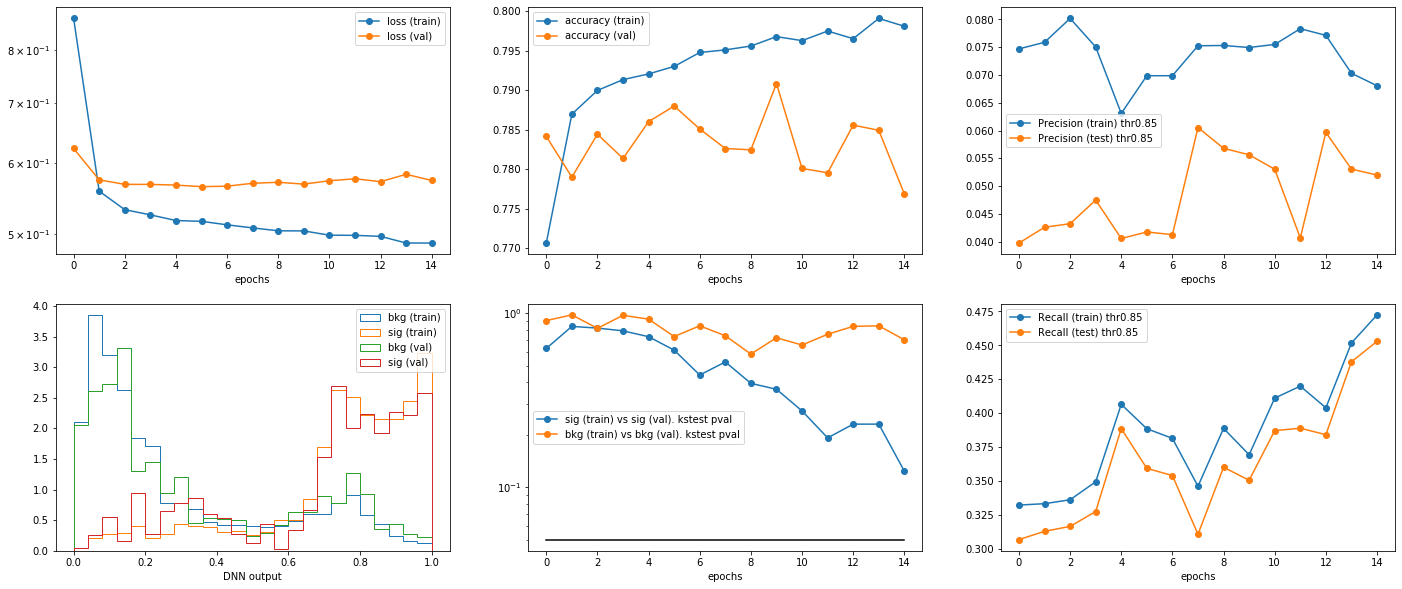

Epoch 16/100
573/573 [==============================] - 5s 9ms/step - loss: 0.4932 - acc: 0.7986 - val_loss: 0.5756 - val_acc: 0.7891


In [ ]:
history = model.fit_generator(
            training_generator, 
            epochs=config["epochs"],
            steps_per_epoch  = steps_per_epoch_train, 
            validation_data  = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[plot_losses, early_stopping]
            )

config["train_time"] = time.time() - start_time

In [ ]:
config["train_time"]

## ROC Curves

In [ ]:
pesi = [0.0011748828421994733, 0.0005619290596088399, 0.0014347091172965724, 0.0009075855501692615, 0.011694420750874995, 0.0020749152074660262, 0.0011188152540148111, 0.0002219870135527828, 0.0010592053314630965, 0.0004547076159644972, 0.00041373511494284635, 0.0007181703620250591, 0.0007011007214316225, 0.0005074744796203087, 0.0008755800147663938, 0.00020334367851717943, 0.001263491351514495, 0.0002788194285474371, 0.0009787856668073112, 0.00039193856898205406, 0.0002445457400811816, 0.0011234994691277423, 0.0008522294347020757, 0.0001966001555490336, 1.9011276446931206e-08, 0.0013128347906571818, 3.742215512150374e-05, 0.001340005825286197, 0.0005892069965768892, 0.00040815517277157574, 0.0004250883286732693, 0.0003734080809105314, 0.00040804992217489597, 0.0005368665395091023, 0.00019009135374414499, 0.002330784881827344, 2.3347830770517885e-05, 0.0018094973890749701, 0.00018009456123210807, 0.0006777061309603894, 1.645905024238679e-05, 0.0009328252293531093, 0.002389355040570726, 5.499565727731524e-05, 0.0004635440975279054, 1.4281144046304234e-09, 1.3296223677036928e-06, 0.0016756439087676912, 0.001115684942031653, 7.197441495456803e-06, 0.0003540678421542825, 0.003013243351561367, 0.0004938679914901876, 1.3608928923298717e-05, 0.0004873459260924469, 0.0007409280476561576, 0.0019092215879219971, 3.826402842282607e-05, 0.0019610862902866484, 2.3996137967023414e-05, 0.0005484085806930483, 0.06285925573792141, 1.5241357703161786e-05, 0.0001685376922719036, 1.688864729506999e-05, 0.00026739324899474224, 0.0007140845153253434, 0.0011350173517458988, 0.0001750165380327626, 0.0005655636491479494, 0.0006940950166075715, 0.0014508980716913841, 0.001124880195974737, 0.00038566550792248753, 0.00022728962304451527, 0.00048239243487783475, 0.0006509365911871255, 0.000477897407880151, 9.424932672390491e-05, 0.004085883967628859, 0.00016537361754740752, 0.001264983284196172, 0.00015401311138143187, 0.00032991570400285527, 4.041822684033837e-07, 0.0003416255794328298, 0.0012518026361862781, 0.000302070837034778, 0.0002166472916937933, 0.000298034646091293, 0.0008263639040502005, 0.0007603159108170262, 2.023480149608591e-08, 0.0008836767567306263, 0.0006182405667029084, 0.003855556573588124, 0.0002687988191019277, 0.0015466360846290701, 0.0005665904190005017, 0.07422174420372706, 0.0003309915180672347, 4.3888348415032235e-05, 0.0005268167209388735, 0.0004758481703098741, 0.0006206292304947296, 0.00013682462859147799, 0.0014787586246998005, 0.0008172091377565508, 0.0009990300902290102, 4.743264969169951e-07, 0.0009749390985002433, 0.000945993939470981, 9.576533619322867e-05, 0.0653162448828023, 0.0002284872300210101, 0.0005183917007544511, 0.0007796689836866182, 0.0007391200049850304, 0.00030430628118203903, 0.0009013742904646337, 0.0006627043080913947, 0.0007684376881604579, 0.00012299544246250631, 0.0006860064787086586, 6.093441901954014e-09, 0.0006030664996526673, 0.0016470162912481706, 0.0005495699922940381, 0.0003640846570147871, 8.371621393483915e-05, 0.0015900501143686064, 0.0001819236754975546, 0.0009553234147441425, 0.0010258686891103793, 0.002099657473685913, 0.0019719677923071186, 0.0005366867160182503, 0.001993578314334071, 0.00016079393553579312, 0.0431965460234289, 0.0016738752550387833, 0.0012733371794415521, 0.0011593190158788306, 1.6267155014967187e-05, 0.000538516993182742, 0.0008848432508093476, 2.4682909105666653e-08, 0.23956685488550983, 0.0011798953122490058, 0.0005463552481996932, 0.0007894636004545716, 0.06614854443381982, 0.001235253269273677, 0.00044367960393376773, 0.060158599822903586, 0.0001904161623797066, 0.0004028410278715759, 0.0009351654641249385, 0.0018434180222466462, 0.0005425373355171578, 0.001095306641046306, 0.00036968102986541446, 0.0007359266934530763, 1.9722392448684276e-07, 0.00041167033781873516, 0.0007569956595664007, 0.0003991825908248641, 0.029696845602863616, 3.719298107963566e-12, 0.0003255027546887788, 0.02222195065425337, 0.0008567900840650917, 0.0010145135848385247, 0.0013702969628349765, 0.0006141652526830423, 2.4263986486875116e-05, 0.0007941227095750953, 0.001148502958701923, 4.498190975034449e-06, 4.538252947438149e-08, 0.0007474589876686827, 0.0011952698501800352, 0.0004088162003436393, 0.00030477492103883917, 0.0006020560882232784, 0.001998278159291308, 0.00012477301476610157, 0.0006957445384766446, 0.0017016825335451097, 0.0014775162421565692, 0.0007384997964915624, 6.161203132809362e-05, 9.429638807108967e-05, 0.0022234304490635253, 0.0006784100443589408, 0.0003483886654613322, 0.0008829782951034205, 0.0007658831104185913, 0.003226295910582292, 0.0017731077867657946, 0.0012504415112742115, 0.0004551641948863246, 0.0006266590760973124, 0.0005274405737524714, 0.00041294149914221877, 0.0015756702450301894, 3.6355693619368376e-05, 0.0037241356047148983, 0.00010755511285543093, 0.0003254205772074992, 3.152340661506873e-05, 0.0016181798560823877, 0.0010169829990312913, 0.0013685188604963868, 0.0016233008881747757, 0.0005429019335813531, 0.0008740029851813706, 0.0012796990329574946, 0.0005835507249157355, 0.00030139480389202496, 0.0011974170870594045, 0.000750743041563547, 0.0007286384790401982, 0.0013234522059808929, 0.003442718862754996, 0.0005343639524673988, 0.0008779669915450813, 0.0004062310539869048, 0.00012889382308927628, 0.0005965703340127985, 0.00033200050259517034, 0.00033676586221384865, 4.8311362289744935e-08, 3.2759520828418894e-06, 0.0009490136025062983, 0.0004927219792588336, 0.0006691072238325668, 0.00041205341276442887, 0.000882417424753147, 0.0014868636607958331, 0.0004137007349864961, 0.0008186940122887064, 0.0003653342530363348, 0.000682198422103809, 0.0007110747996383397, 0.000121082086405615, 0.0008899916641781448, 0.0003362855092272718, 0.0005323286357608776, 0.0012571464316149387, 0.000935212585439154, 0.000629367012549831, 0.0003363404825705357, 0.0019132170642803875, 0.0002878748631698274, 0.0011067539284431887, 9.409119014414393e-06, 0.0006956586334583675, 0.0009508689838572862, 0.0002709721042454918, 0.0009366077365650249, 0.0005492785700107643, 0.0003424383781288932, 0.0007503931376616067, 0.001220071311444635, 0.0021528402293927583, 0.0015408468055366693, 0.042408747105766795, 0.0006645359394005476, 0.0023097487752468185, 0.001172138730159178, 0.0008268873051131772, 0.0004369042583503952, 0.00025029476025899196, 0.015615430102558583, 0.0007330889369844876, 0.0012604558817056663, 0.00044544952398312544, 8.340562171640445e-05, 0.0007042079777439513, 5.682755561047769e-08, 6.1008849033715335e-06, 0.000315944166560403, 0.00042763730377200405, 0.000450074827200507, 0.0014614678850655316, 0.0007238631669624061, 0.0005166607591992907, 0.0007392421546463677, 0.0009274974406249869, 0.0006618971857925896, 0.00019414830996855473, 2.7108886188372407e-10, 0.0015060634918123315, 0.00034255609813835545, 0.00037763190349699176, 2.7162628098477343e-07, 0.00043419451842608456, 0.0014435796504838991, 0.0006814816755516976, 0.0005193303349880879, 5.8084017827269766e-05, 0.0007201567752099716, 0.0005384802462325372, 0.00253317794680804, 3.6343582208613976e-05, 0.0010241070271032216, 0.0003817869099760089, 0.0006411618201213921, 0.0018972259140798292, 0.0006694627230789634, 0.00011713431853405928, 0.0006248492742945479, 0.001171335619828316, 0.001211077077331018, 0.0019144503618731652, 0.0004996260755877554, 7.249287890937397e-05, 0.00013424948678651956, 0.0003972846728875006, 0.0006023472131480549, 0.00015247061644206168, 0.00039226592344545214, 4.0928020926563554e-05, 0.00033266818189426847, 0.000811429847780349, 0.0013238252982032707, 3.825341122053371e-08, 0.0010923580299365074, 0.0004280721813601787, 7.097518531859542e-05, 6.24763062261069e-06, 0.0005233632011338717, 0.0015227562725899514, 0.00043364237376197355, 0.0026229646093885476, 0.0006671748242444496, 0.0018420369052772512, 0.000409952584477206, 0.0013230914679604909, 0.000806112128619632, 0.114696410925718, 0.0010321320818706872, 0.001416763155622336, 0.1783925707543031, 0.0004315758575243217, 0.0005348625783436846, 0.0002816867123059347, 0.0007059834856748944, 0.09366248130922976, 5.2650977964832664e-05, 0.003051448477988158, 0.001964712838091457, 0.0008157309709375236, 0.0008196408983506057, 0.00060951882437853, 0.002364630558356754, 0.0004635103966045325, 6.330060856303405e-06, 0.0008875249466941024, 0.001163929911616516, 0.0011249379460472287, 0.0012578797917349996, 0.00016620054575924167, 0.0008348082677224092, 0.000678370621308712, 0.0014787296459944802, 0.0002725538815715496, 0.0011485762307662899, 7.958242416776614e-05, 0.0010926300645448912, 0.0012997176609704194, 0.0002628352373027525, 0.0004662226356720388, 0.0015335386330494365, 0.0017469515611106608, 0.0012813568195078932, 0.20081541261257413, 0.003060904853096823, 0.0003086519718790381, 0.00024616908997522147, 0.0007234073305931318, 0.0004942446438402915, 0.001790768532129336, 0.0011949207186315051, 0.00030366464647459395, 0.000566868853922866, 0.0010754115678787868, 0.0008482959958514103, 0.0006114519320255615, 0.00047500279189571917, 0.0002289050529708313, 0.001448507518494903, 7.499664610698941e-05, 0.0006701237065995556, 0.0005134131701707738, 0.0014645266565040057, 0.0004252717609302043, 0.0010483975488378581, 0.00029316258544133714, 0.0007318753181923998, 0.0002494418195881101, 1.4163440635266704e-07, 1.1289068230670264e-09, 0.0007963516329148562, 0.0002839545643268517, 0.0009066000355798256, 0.0004710866634491699, 2.508937342677832e-05, 0.03808038499471173, 6.317122315252023e-05, 0.001765164681103205, 0.001519919260093186, 0.0006489469165445042, 0.00037129586971361146, 0.06978461818934525, 0.0005955696077425315, 1.1476525024291724e-06, 0.0027798106874286146, 0.001088468736186526, 4.455329403559166e-05, 0.002256197356061643, 0.0007407643548282139, 0.00043527536645221373, 0.0004522180672516388, 0.0005642319440093136, 0.0016115291068839067, 0.0005319967666014646, 0.0002832820047998015, 0.0018182003557310072, 0.00032352610472472724, 0.0007974749539870314, 0.0007979597054905594, 1.8717494036326318e-05, 0.0006566670918103445, 6.065785726451338e-10, 0.0008896383247121444, 0.00036094381276579636, 0.0002215668904024153, 0.0009965323158329935, 0.00039113214753049854, 7.299615593072035e-09, 0.0016576602090463744, 2.1546797215915587e-05, 0.0006631802882314777, 0.001870302683946611, 0.0004458855716873967, 0.0005508379086046817, 0.0012952524438841983, 0.0008695538534432333, 0.0003166415874873987, 0.0003464899841475086, 5.491683499141092e-05, 0.0016358532268327018, 0.0011019245384791434, 0.0011777575721517606, 0.0009634020136727961, 0.0004963387435742364, 0.0004792002765182087, 0.0012822970603673098, 0.0002863746965871394, 0.001255597109585436, 0.0012173012894253436, 5.394656985928987e-06, 0.0007782737091584004, 0.00042167994883529695, 0.0006233226488796845, 2.1140960796768146e-09, 0.0005536054328945497, 1.1457452198586576e-07, 0.001526098991931358, 0.001423591499267315, 0.0006681856524445197, 0.0004395323753882846, 0.0860732492500805, 0.0005757683136288866, 0.00024264403306462502, 0.0013210340783783691, 0.0005684441615114363, 0.001968051240478701, 0.0005080937982327, 0.0008428653983751375, 7.408730077526779e-06, 0.0013779798248889467, 0.0009781601651367427, 0.00037765395851971, 0.04470229194744078, 0.0012285490398282345, 0.00048400586550178816, 0.00179719898350416, 0.00041231398945908593, 0.0007665105432496244, 0.0017134967293576144, 0.0005159038789233516, 0.000782827208913927, 0.00014146426765876155, 0.0002792417512429634, 0.0007721746725852494, 0.0033870124329319147, 0.0009775520147287259, 0.0014049705777480687, 0.3901014626122609, 0.00040351531695626713, 0.00018669092104547255, 0.0017833275661749148, 0.0008180890458543105, 0.0008290941638300334, 0.00040367153896171036, 0.0009770756858625603, 0.001190168430765657, 0.0004108025499036446, 0.0010149774316452732, 0.0018030513531929581, 0.00022501293513383305, 0.0003762212977061117, 0.0006253194581299207, 0.0005820506801945419, 0.0003988171018589583, 0.0008247673558281536, 0.0007626408708703737, 8.453158704736885e-08, 0.0010849767397098993, 0.0007105116691469003, 0.0014679078229704063, 0.0028806663642833115, 0.0012970030412790565, 0.0012656437034202885, 0.2877187585917476, 0.0008137109038900374, 9.256784870255253e-05, 0.0004481377901158748, 0.0003278514400267297, 0.0005647302427454052, 0.0002650431744794213, 0.001365507528114131, 0.001581403172745167, 0.0001837667254702955, 0.0009719543778409729, 0.0002526580090922096, 0.00021306424663995431, 0.0009535368324515623, 0.0006208563119800457, 0.0003937599667180327, 0.0002889123353797547, 0.00071419810219719, 0.0013631859251520611, 0.001278230133339981, 0.00019017603633491567, 0.0006635759209375989, 0.0007801360001855411, 0.0006078631177686759, 0.00042422120991511515, 0.0007217055744833163, 0.0005159949312657084, 0.00017532557707928574, 0.0006644774219505293, 0.0003865775842560507, 0.0007170918029092997, 0.0006278060027618533, 0.001076002192992907, 5.576064192698104e-10, 0.0011582865843644656, 0.0011366544610236424, 0.0020471532225694406, 8.97994748991653e-05, 0.0006044977385967338, 0.0004038653719639214, 0.000652027019961266, 0.0005966219816521944, 1.0743510720524073e-07, 0.0003677830672997925, 0.001205877069335195, 0.0019003528169243683, 5.351825868567123e-05, 0.0015419035526222796, 9.009920262803686e-10, 1.4781387519227926e-06, 0.0024571206963858454, 0.0004184286551998747, 0.00023521964852964898, 0.0007025002406926805, 0.0019743756344817926, 0.00038611279733969517, 0.0003014732166934756, 0.0018444926062564295, 0.0004088848081095887, 0.0014893205049591358, 0.0004107339532903537, 0.0012202025166347516, 0.0007083023721511729, 0.0010862026298323604, 0.0003393037276830376, 0.0007430547422766384, 0.00034407231123673436, 0.00021216052703797126, 1.7471649511119426e-06, 0.0005332330997295109, 0.000602312141528499, 0.0002675218067686153, 0.00047692646054101095, 0.0005107048614891522, 0.00031372805990748234, 0.000864814798522481, 0.05015870754497037, 0.0009053650474400408, 1.778974095988685e-05, 0.00034878779922824666, 0.0004898266563013512, 0.09004733157687912, 0.0005387153288093719, 0.000785791173598509, 0.000620395988725053, 3.205246640542008e-05, 0.0015012938308712012, 0.3106530143386243, 0.0005418606840779, 0.0007463891265138387, 0.001812304450385476, 0.00014975682029217654, 0.00026026781206031787, 0.0007391031205288834, 0.07891541873880065, 0.0005259966195124305, 2.368709559437201e-08, 0.0008311338436310074, 0.0014742353370253284, 0.00046847403667615097, 0.001080490617978051, 0.0007951758811065806, 0.0006075095286570102, 0.0007872087927401308, 0.000930170514820066, 0.00017754247052284263, 0.0018153137680332078, 0.00047342939236826585, 0.10783911416434075, 0.0016359841903630676, 0.0010267990828410427, 0.00010828428832859148, 0.0012354271033458483, 0.0010773387603764371, 0.0015489627849410365, 4.276866894825845e-05, 0.0003190685219583179, 8.851767258793039e-07, 0.0017050837248128673, 0.00022473204097025727, 8.308373831739112e-05, 0.0019231935298904108, 0.0004832062387732935, 0.0007642076261426498, 0.0009930542080940977, 7.098228665558743e-05, 0.0006087874687490675, 0.0018117408788031965, 0.0016101075689427355, 0.001937002621508466, 0.0004550167406214888, 0.0007037827979468147, 0.0005042811019577512, 0.0011766274851069763, 0.0008558811222393861, 0.0013029549412092239, 0.0005992063520407287, 0.0018076725558046802, 0.0008660555141492682, 0.0004702026752803685, 0.0001818356414291768, 0.0007242878746051734, 0.0005522863122150557, 0.0010557754403455613, 0.0013616032437276733, 0.0016186023292717132, 0.001284644897627098, 0.0011836729490822524, 0.0011440231888560609, 0.0007930207374049592, 2.9903478426328402e-05, 0.10565689215071918, 6.0806776624725474e-05, 0.0012075028056052547, 0.17601067098912798, 0.0005138094222979834, 6.796686813821521e-05, 0.00038145532260191534, 0.00045281012820490757, 0.00026931986109026855, 0.001105551296201586, 0.0014538362358084448, 0.0007015347078212919, 0.0005230850610907538, 9.505723159609741e-11, 0.0008195507312571291, 0.08667309842904397, 3.8426058536733906e-06, 0.07178127584855853, 0.001522109857992311, 0.002278044089314302, 1.7146439815913846e-09, 9.071481252288471e-07, 0.0007279974309193744, 0.0010381312719113665, 0.001754952681952205, 0.0010902339633242942, 0.0012073718893222784, 0.0006471798215818193, 0.001034053288373529, 0.0018643754162919008, 0.0019258612670242188, 0.0005832716431335985, 0.00043663591641377293, 0.00020918153918938172, 0.0004911150388393848, 0.000999714659451388, 0.0014844732186401809, 0.00044600953761248825, 0.0010902246857029641, 1.8490313404961186e-06, 5.779822300111017e-06, 0.0009138561519035711, 0.00034783551317956623, 0.00035030518313471527, 0.002123886835326763, 0.0010695023695847196, 0.0004455397254250604, 0.0008303637666245598, 7.778439128239621e-09, 0.0003854598524209795, 0.0006306543947387558, 0.00038815281433421384, 0.0005802289052154144, 0.000963494485980772, 0.0005170459328717867, 0.0018834758518129692, 0.0004910174050318725, 0.12580724390066741, 0.0007104605392750831, 0.0012286660868161712, 0.00013372600486590748, 0.0008747037132865923, 0.002133854963165463, 0.0007033664675476419, 0.00047077570487953044, 0.00020829838726422705, 0.0012367622473601022, 0.0014610162032817578, 0.04273211260384472, 0.0019928688473654942, 1.3914215304835234e-06, 0.0015141255741843885, 0.00036079507382174246, 0.0021020083731314713, 0.00036865747489852767, 0.09334130321689374, 0.0004874008483315389, 0.0006523853328939599, 0.0005658448923690448, 8.644838392406905e-08, 0.0004494833737248247, 0.000585889358334688, 2.0602205489967222e-05, 0.0014298879440082855, 0.000753007499039394, 0.0022355281081834883, 0.0014250004512730318, 0.0010642621960782292, 0.002198990201229238, 0.0003708428866157593, 0.001111253594917384, 0.0010138164564364761, 0.00016695344888337997, 0.0005154636365778872, 0.00039765010390701964, 0.00252708168358303, 0.06320759193986482, 0.00034940652547740456, 0.0005188749159898063, 0.00012057988587005748, 1.853989539118496e-11, 0.00011467488715452926, 0.001560621185907409, 0.001525087330390721, 0.0008512261412079731, 0.0022691769115277703, 0.0005924043504894342, 0.0004633717032266097, 0.0001536014140192212, 1.0541484555909969e-10, 0.0007130181547658744, 0.0489565673808689, 0.0014048578517976379, 0.00042071644210836507, 0.0009150532453988666, 0.0006038216920579908, 0.0009161837978845679, 0.0006351372598516453, 0.0006266726293829456, 7.199772014820732e-05, 0.0005673141002163666, 0.0006639138002770952, 0.002753057298868687, 0.0008649602173129668, 0.00022158075401259612, 0.0001090756368877465, 0.0011227699933526601, 0.0026047063839642766, 0.002604613450178635, 0.0003897192701152855, 0.0008012936222422253, 0.001438944130736445, 0.0002915682666727915, 0.05150596390456211, 0.0021590948469498495, 0.0013172197033234207, 0.0006904900546662797, 0.0013978219220273928, 0.0007780703384950667, 0.0005899487218235014, 0.00030211346110809156, 0.0006306579524950461, 0.0008543228359665425, 0.0006082464563483884, 0.00019064958649200097, 0.0018768691451362634, 0.0005417787408756094, 0.11302266207477157, 1.7567118676338777e-09, 0.0007428792449236113, 0.0008418131375598454, 2.605813698223332e-05, 0.0007978706538083426, 0.0006222597574750774, 4.406735608313027e-05, 0.000593943713617301, 0.0010914644788000546, 0.0008976242356790288, 0.002085822343058102, 0.0012422236652059424, 5.882868820361317e-05, 0.0017046700725313522, 2.2363457892565217e-07, 0.00046432007345008727, 0.0014013876517538766, 0.0007078092047409902, 0.000378096214158584, 0.0004132142561990648, 1.5364493383509849e-06, 0.00017901088957891824, 0.000794297986986875, 0.001655997058143314, 0.000819489126038612, 0.0010804881741723193, 5.489384708438177e-06, 0.00088395315853073, 0.0008765222399923188, 0.0007398841620829168, 5.88499921553605e-06, 2.120653164179401e-11, 0.010068229844177505, 0.0011244863043167771, 0.0019659577833968872, 0.0015733170357459833, 0.0008988892646445625, 0.00351620649928851, 0.0024787557088047445, 0.0007454501722256503, 0.000156191761662967, 0.0006547551343208857, 0.0016585663924333775, 0.0006936429435026645, 0.00035417527517437437, 0.0007317874968090861, 0.0009404454086024664, 0.001874241426564583, 2.6186046644751717e-05, 0.0007317532021451897, 0.0008590321933225412, 0.0008515348281837895, 2.7254288002271452e-09, 0.0005743858924840915, 0.0009053454878280944, 0.000524953991424653, 0.0003135811315595163, 0.00045621581784023146, 0.0018330474827917876, 8.556102651492994e-09, 0.00015068934484457344, 2.022735127472404e-05, 0.0005725196261387365, 0.0005826640948818143, 0.058814400803551846, 0.0006023514260489945, 0.00041615558322844864, 0.000575196179251397, 0.0012102651685722463, 0.0012238796479830416, 0.0011646464695074157, 0.0009109073980006607, 0.0004503312397308217, 2.964414785620576e-06, 0.0010192730358919823, 0.0008790350001452923, 4.8073653181918505e-12, 0.0020131451763707045, 0.0008884006176298649, 0.0006944210971954899, 0.0001491154226620575, 4.2857124689655106e-05, 0.00032798378027388696, 0.0002640047457401813, 0.00017920627873044693, 0.00036205051788622744, 0.0009993843572013166, 0.0007606071303162831, 0.0032240948077840005, 0.0001591288262296389, 0.000945155221510285, 0.0015224864594366604, 0.0007487671454271724, 0.0006186556589361278, 0.00034142046542185215, 0.000254877365722845, 0.00023136321577711913, 0.0009499325188725428, 0.0012124325097939116, 0.00047912871836963846, 0.000123142320286901, 0.0003305202651494948, 0.0003391104479677556, 0.00014791848746357106, 0.00025649868216014757, 0.00029868069622537385, 0.0021453913061269658, 0.002139518620604039, 0.0005330408894356359, 0.0014585951893199538, 0.001497094583793578, 0.0006909803308560659, 0.0010542698512411082, 0.0004152977510629754, 0.0019632654716924985, 0.0007351184128000149, 0.0007361501269939547, 7.726660422930991e-05, 0.0007651306065218505, 0.000706344849224372, 0.0015422822084683525, 0.0006431924662178377, 0.08852446046700753, 0.0003498568590179251, 0.0006377588674408414, 0.001571245655957589, 0.0008595030560006229, 0.0011132471868390745, 0.0016428674033215746, 0.00036591598624906703, 0.0009031229940138802, 0.0005754868097660383, 0.001081068749489628, 0.0013636215071230855, 0.0011581307790187664, 2.969348718359637e-05, 0.0006483621331870332, 0.0009569162196082434, 0.00044749396919210264, 0.0005486554866628212, 0.0007439892436988795, 0.0003004375890320636, 0.00040128920499014626, 0.0009374946504874709, 0.0009705836316463722, 0.00042712215906518864, 0.0019791537169365336, 0.0005792537880698934, 0.001134170661417221, 3.486712137447465e-05, 0.000736097431590904, 0.0021410091507463236, 0.0004822739144538738, 0.001975002136311833, 0.0012821295422150102, 0.0005315757572476181, 0.00023078166236674703, 0.0018315091559847423, 0.00029013287686020393, 0.0019452496640765013, 0.0011535064724897686, 2.157179295493688e-05, 0.0008526761527805703, 0.1310380514001211, 0.0006597725264055848, 0.001621645636637817, 0.00044184335593846027, 0.0024007549362134476, 0.0006525055239831629, 0.12717468292428377, 0.0010587742020823354, 0.0007551495202426509, 0.0005695098138755683, 9.736819032120155e-05, 0.001013779135087861, 6.14831382739252e-07, 0.0002619572804062693, 0.0006628608435772125, 0.00042848009203956425, 0.0007398300919937075, 4.272627689437345e-05, 0.001779346880921228, 0.0007979835524808317, 0.0004092834515330732, 4.553451779587946e-09, 0.03986001591841446, 0.00043877857870739095, 0.0007539969451027022, 5.756549986055501e-05, 0.00010860775822161803, 0.15142275270100436, 0.17331477222002198, 0.0008216315188670998, 0.000741042815608011, 0.0015060927432729296, 0.0007179790722980867, 0.0010644620625536608, 0.000875003413069441, 0.00015262634504257868, 0.000495909188400149, 0.0002800390600422418, 1.2045173573795644e-06, 0.00011830230880011518, 0.0019512026230728969, 0.0006951588889867134, 7.485962471885036e-06, 0.0011833369754232674, 4.5728030323175404e-06, 0.0005402173852279422, 4.60209102947244e-05, 0.0006120316108037751, 0.0009320278671790307, 0.000340090868867876, 0.0009116342467440742, 0.0007790312843674096, 0.0006433716406731376, 0.0007912418840011477, 0.0004677554120044041, 0.0002978750185225227, 0.0004492528329275356, 0.0006201896573227328, 0.0004903868145429977, 0.000601243444013706, 0.0011794923815516736, 0.03534819544446317, 0.0008641012906630536, 0.00035995194042057443, 0.08605692914361346, 0.0010405647057455103, 0.0006915387944496125, 0.0005153226764485865, 0.0011641619164780433, 0.0012454477769623911, 0.0002668187367752604, 0.000379571137927394, 0.0006950192275864453, 0.0003477461913180385, 4.135998271652323e-05, 0.001017526692043938, 0.0010603771973748163, 0.10864620877257687, 0.00035023010655001516, 0.00035394120971248526, 0.00022645425277170744, 0.0009814790965998626, 0.0003524910353546977, 0.14772120748963966, 8.7276821449033e-07, 0.0005186708846285847, 0.0004715018779294975, 0.00029406193131275297, 0.0004010554951175819, 0.0012437748419828767, 0.00030737594803023513, 1.150512190573895e-08, 0.0011137964333988223, 0.00012571902124490196, 0.001088941079568228, 0.001190729312923304, 0.0021501899801214088, 0.0012083904475135, 0.0007266332624365052, 0.1460279510437649, 0.001447701654126419, 5.230741905181594e-07, 0.00040297113459411126, 0.0016619530107525114, 0.0015327901314849516, 0.001329920600769633, 0.0005449574519066777, 0.002096764091811759, 8.588257896396646e-10, 0.001100700405802335, 2.0165842042724e-06, 0.0005977687491843922, 0.0005669838713241043, 0.002044117891582687, 0.0021704236718334516, 0.0010161666253802174, 4.773124007055959e-07, 0.0018042881391600587, 0.0022249582287725152, 0.0006200963485347414, 9.473907231969972e-05, 0.0005450116239254564, 0.00045468947879920556, 8.461460311197251e-05, 0.0007285846989511295, 0.001205087385767834, 0.00033629748060566664, 0.00047772017630557864, 0.0034640064546814704, 0.0005438245596109754, 0.000403328823780597, 7.808231115643263e-07, 0.0008228932537172152, 0.0004802734305209389, 0.1072126895189794, 0.0009378935823907881, 0.00026364611897715406, 0.0006249034596270708, 0.0009510057615884442, 0.001066160430748191, 0.0005457935555875997, 0.00013625374456430723, 2.3761003628289043e-05, 0.0007555487684863723, 2.308935797841092e-06, 0.001916670217985561, 0.0016292876965398535, 0.0010467786227616848, 2.0014124102502625e-09, 0.0008782025387114035, 0.0010038682945510626, 0.0005923404246501596, 0.00013265533956184907, 0.0017305107169371325, 0.0003504998259097426, 0.00041421129358478094, 0.0003229563164638466, 0.00032430560579765606, 0.00014259026724976084, 0.000572269041889121, 0.0003982572049194744, 0.0031837869898566273, 0.0014447744744400305, 0.0006469433301398778, 0.0013713465115980893, 0.0006584812266854147, 0.002228545611978691, 0.00013831390936902479, 0.0001201377733077858, 0.00040981431777037896, 0.0002492125493736122, 0.0005060438706823292, 8.852649845257336e-05, 0.001484533204811347, 0.000777554277163508, 0.0010762783365622524, 0.001432679870688673, 0.0005226589796966225, 0.000550505351155049, 0.0011992359661317801, 0.00031921447212427, 0.0011325793351637673, 0.0016498241933548478, 0.0007743123555676192, 0.00031114196961510286, 0.0005605164508774722, 0.00011471389973428101, 0.0003204193441421461, 0.0007350190211216597, 0.0014590342428669589, 0.0005721192564663437, 0.0020824404013170842, 0.0009856935660466388, 0.0003666192817908643, 0.0006297746741819266, 0.00028179198726819025, 5.701098769973996e-05, 0.00048404478053863236, 0.0015071624903416278, 1.1755997709300546e-07, 0.0006439923829653994, 0.00079485251738923, 0.0003364849331252455, 0.000429117776560524, 0.0007152161434361234, 0.0009188961349257278, 0.0006183305318110378, 0.0006645788130140739, 0.0006343675585680743, 7.104896099907517e-05, 0.0005534840542574422, 0.0009384360062351706, 0.0012095879331312928, 0.0011057853447343513, 0.0005269889009810911, 0.000446127272006422, 0.0003174249922401124, 0.0006145586768636205, 0.0003382690777715593, 4.6773965558692155e-09, 1.7698283187771222e-05, 0.0019712883004455164, 0.0015605840505791694, 0.0006318438578619305, 0.00021414997517385883, 0.10340905505319761, 0.0005358835193135488, 6.589627304156098e-05, 0.0034346148569203067, 0.0007650606064079537, 0.000499579349025272, 0.0003070625977714962, 0.0012063881978956158, 0.000605080340926648, 0.00015729729376128655, 0.0022712777325230673, 0.0009992221837633196, 0.00031332645994681485, 0.0007752131675148576, 0.0003911627810439498, 0.0006507354574194548, 0.001247390844427213, 0.0004367054549069366, 0.001021754217643769, 1.6816463167647435e-06, 0.000727531375262298, 0.056689601760204274, 0.000346223092886707, 0.0005287733969469569, 0.0006089680138890795, 0.0004957110812002617, 0.00040896317112036325, 1.8879355659554396e-05, 0.0014172108455134153, 0.000839922931605521, 0.00034079015549113987, 0.0004464979827023377, 0.0004720798152335694, 0.0006851967827815288, 0.00032452497542909467, 0.0007902785329419747, 0.0016934050596563572, 0.0004413011770747058, 0.0010865231610356473, 0.0004586360053928308, 5.5784956423314854e-05, 0.00036144219491858546, 0.00029462393612738355, 0.0009028357391867714, 0.0008851050099536973, 0.07037483200655821, 0.000919949037201831, 0.0011044583160392527, 0.00030937820349528303, 0.0014724548573707488, 0.0006009322266326257, 0.001469499683761504, 0.0010308124626072725, 0.0004453375166958118, 0.0013978414154719066, 0.00038209225773423424, 0.000748696842175248, 0.0018875165746387165, 0.001457591697265489, 0.0665940092681186, 0.000906906795012177, 0.0012339317006341088, 0.0006892902930326544, 0.00039745697973961894, 0.000987592345953127, 0.0009734714169042593, 0.0012776669471288693, 0.00036278660917271263, 0.0007712942851996065, 0.00033966068327913107, 5.705412699359803e-08, 0.0007378758940592902, 0.0003511929090519953, 0.002041143757546716, 0.000990201091265085, 0.0018924564951246718, 0.00042804337434433685, 0.0015819229674713345, 2.2242065588515516e-05, 0.0006230736595495174, 0.0011769640440867106, 0.0013004093296901849, 0.0014595089764676199, 2.1418531527240156e-10, 0.0011836372736421601, 0.00033436173844677533, 2.613885794139281e-06, 0.0016626339554032202, 0.000439111118673132, 0.001023453894311692, 0.00015251949800356164, 0.000574508533595951, 1.1555663829101084e-05, 0.05442640109728329, 0.00172328617081621, 0.0015728907591047055, 0.0019021178676283637, 1.953846645352695e-09, 0.0009542187878498603, 0.0022397269751766474, 0.0007069772724673895, 6.069376473633867e-07, 0.00020513822740719586, 0.0008052785966897711, 0.00021767387639704347, 0.0012024894538554256, 0.0004833336171483477, 0.00030717524144589206, 3.919886395180719e-05, 9.856962126632629e-08, 0.0013964993638133731, 0.0003033407695500369, 0.059288171997415276, 2.69387328645394e-07, 0.0018236813585494865, 4.623285390434437e-06, 0.0004030801493463341, 0.002362270098028347, 0.0003572263532244978, 0.00017534015251494293, 0.00027585520025468646, 3.352741260676625e-11, 0.0006703814195348043, 0.00032328039760038427, 0.0009163719254504122, 0.0010035404215010867, 0.0010373651019702054, 0.0006356823996305309, 0.0010023038723069755, 0.001799716399607282, 0.00035159715344595856, 0.0013199451492308752, 0.0003744085462466217, 0.0011983495064167436, 0.0010210850160450218, 2.1280579832302946e-05, 0.0007501778870647212, 0.00139253175226922, 0.00092551664761727, 0.0001646230766493241, 0.0008431203960688854, 0.0014951891216295175, 0.0013428775512723176, 0.05650492361144192, 0.0006030072132056779, 0.0010118409972016957, 0.0014005351712988601, 0.0007583816610887886, 0.0003430831535185713, 0.0004303666867501207, 3.2247192797958895e-07, 0.0005519711288414615, 0.0018857902181259553, 0.0007937656567859991, 0.0005447769129381124, 0.0006403487618994707, 0.0004497237391043164, 0.0003399518071876432, 0.14547914401730452, 0.0005484151976103856, 0.0004960967681669684, 0.0008023422546723858, 0.00024098587221768752, 0.0006452445905069387, 0.0014261318247526028, 0.0019866724718182885, 0.00032002437907979666, 0.0001614764433767968, 0.0007317108308377232, 0.0023094021549709, 0.0003930912395766704, 0.0012412240118088878, 0.00031299754156360356, 0.0006794461531496353, 0.0005712088112292027, 0.0007639027081790779, 0.0014709397677977552, 0.0018470933281332306, 0.0011521203768578114, 1.360829922797605e-06, 0.0003262247142688746, 0.0002944756196465412, 0.0004404146722412978, 0.0004674032516607157, 0.056804263892884795, 0.0004396007201452465, 0.00106161325168424, 0.0006924818825386193, 0.0003143994978251552, 2.0259593124828427e-07, 0.0009071477765852614, 0.0002638973715684932, 3.521111870073497e-05, 2.1927183299825367e-06, 3.44051045649245e-07, 0.0006135288712984082, 0.0006730483746957822, 0.0005906206327269913, 1.4478076781934963e-08, 0.002285153141891697, 0.0003321778013289403, 0.0008230599148950054, 0.0005360048824062236, 1.1615868648508205e-05, 0.0011178424545039917, 0.0008762550098152773, 0.0005591491648536368, 0.001346625623382367, 0.0018111588814728205, 0.00011804711700009995, 0.004997112706745036, 0.00013769123127879433, 0.000552839247695735, 0.0007349015260915221, 0.0015440057202989626, 0.0007510723502959588, 0.0007891040574239968, 0.0018291305038190086, 0.0007400979676123827, 0.0011279805946464198, 3.9739435328842455e-08, 0.0014862970889629558, 0.0005645510883773515, 0.0014018489426562326, 0.00024185003416193855, 0.000678545074487007, 0.000362628906079558, 0.0006362800452483888, 0.0013948466476781968, 0.0008930463377777781, 0.0006733708583948038, 0.0007508816884468621, 0.00121742705060394, 0.0005732354842407859, 0.0006034732750640349, 0.0003776548534445695, 0.0005360630401783597, 0.001244745260442908, 5.211056656063154e-07, 0.0005186081905204969, 0.0012980338542611146, 0.0009555264743435591, 0.001182418275246276, 0.001488792954585109, 0.0017421821071627785, 0.0013132715047100018, 0.0003829139162069091, 0.0003215484781559044, 0.0015468124487623748, 0.0014386024452304282, 0.0005025491329808843, 2.9306524455725762e-05, 0.0009486527651620205, 0.0009112379333921794, 0.00015489395568158405, 0.0002427299296796622, 0.0019357962077404627, 0.0009565194047993917, 0.0011675000646999374, 6.330434012833826e-08, 0.001277399910426947, 0.00033174458146139886, 0.0004026322147381975, 0.0006429129832947449, 0.002377063090401069, 0.0002656253921602585, 0.0003830894437033138, 5.210314808959668e-08, 0.0024127044370024883, 0.0008597348848257328, 0.0005933229180648128, 2.1293339812364487e-07, 0.0006962104973644625, 6.248400740455714e-05, 0.0014144341124974135, 0.00017369442898836526, 0.0015167578531078735, 0.0011437005831046111, 0.0001439881794218464, 0.0003335031821505073, 0.00045556525911762927, 0.002020546058937868, 0.00020159684630722532, 0.0015406726617731516, 0.0006335511718482961, 8.686844539776685e-05, 0.0003074845404313173, 0.0008405178995360612, 2.210594543861905e-09, 0.0009064432035948102, 0.00019434525006298183, 0.0007347387855181091, 0.0013992648958824432, 0.0005603810186733004, 0.000712665936588924, 0.0005624414198320779, 0.17707409680452416, 0.0002782018506448404, 0.11998536615709952, 0.0005300747999798831, 0.001019767944415493, 0.00030601656699052977, 0.0015715461146022808, 0.0011806833006008143, 0.000857450589924037, 0.00015937582416730484, 0.0005271699119602316, 0.000910718570943886, 0.0010050273298152902, 0.0012613974502569784, 0.0020323373500173354, 0.00030736312352109147, 0.001767326416554218, 0.00019334514688895145, 0.0014071223483756987, 0.00048000205108513145, 0.0008341968502154498, 0.0006146373412683977, 0.0017260223820815392, 0.00161326069698855, 0.0005221560923469816, 0.0013213328842370863, 0.00026960579951499145, 0.0007594805592094315, 0.00022930317397057702, 0.000394227496907445, 0.0022388728320344134, 4.6510294865970187e-07, 0.0009492722764696418, 0.0004966567815784773, 0.0008838296454853834, 0.0005261903903713223, 8.183504016149527e-06, 0.042119157156097875, 0.0005465506482030559, 0.0015906331862194007, 0.000413048175255494, 0.002385030444473405, 0.0014469757204805304, 8.800818941268819e-05, 0.000565407866932963, 0.0024797293380326253, 0.00040768394038008526, 0.0020984198964780327, 0.0007871573419599081, 0.0013570871785999591, 0.0004851860776544015, 0.00045278699189060334, 7.065012854861464e-10, 0.0006061497370318962, 0.0011295110458324285, 0.0009789855170585903, 2.894629263865158e-08, 0.001791262403772923, 0.0011965414720025878, 0.0015885397202494863, 0.00214068274680093, 0.10248268727366622, 0.0013193374253771923, 0.00011209754003831761, 0.0006059612463487399, 0.0005421110727182914, 0.0004629407165106989, 0.00104102486422041, 0.00019314536383354528, 0.024063951221529004, 0.0025022470948902744, 0.0010542596050264628, 5.44975462921676e-05, 0.0011759307352161223, 7.569685922386483e-05, 0.0017313839703996467, 0.0007577874444052753, 3.113900170790576e-05, 0.001276293976193999, 0.00031022399773138713, 0.0013050987516341399, 0.0007069181979116965, 0.00035210455053183605, 0.0006649097622130951, 4.8669168220185045e-06, 0.0005907064399812658, 0.0007480054171160181, 3.4291119207196886e-08, 0.001152624401660058, 0.0016345780946487286, 0.00022757097966827775, 0.002576803253812532, 0.000976885541719941, 0.0019281658579391099, 0.0017010557542517077, 0.0004275871451109597, 0.13057331999274277, 0.0008002554282714785, 5.524243245840703e-05, 0.0017010187410098525, 8.712004861627342e-05, 0.0011985426271460561, 0.0007557980884513015, 0.000740884446565787, 0.0012409079509179432, 0.0003956937659213328, 0.0014387120614853246, 6.205864042609796e-08, 3.4855980503756333e-06, 0.0005901074207974574, 0.0006393604724773795, 0.0010595974128949995, 9.809318727160688e-05, 0.0004671740726057115, 0.0007598343815523094, 0.0006313795429468217, 0.0012612772382569776, 0.0014462905118413874, 0.00023092994989791596, 2.5011376809742156e-07, 0.001751396625027263, 0.0021816377699375037, 0.0003629892307574491, 0.0001710036842137393, 0.00036338023886331986, 0.00026739477518791517, 0.0010846153149042539, 0.0009832671321945469, 0.0007600674989403947, 0.00088593174472406, 0.0005889310065681292, 0.0011808063743960243, 0.0008578615739966918, 0.0007642905675773295, 0.0005847252800828472, 0.0001850583231531235, 0.00177461551487834, 4.5041406551686784e-05, 0.0023125835479769347, 0.0005108401851418421, 0.0011370824883862724, 3.995496158760397e-05, 0.0012766175161028344, 0.0004003585058413724, 0.002296994209598379, 0.0006421424703280649, 0.00042199539947202494, 3.2498683621030606e-07, 0.00041967057212767827, 0.000567424749088637, 0.000832259474743256, 0.00032336293580502207, 0.001743727669723608, 0.0007798095023085935, 1.288541589592089e-07, 0.0006366886804788579, 0.0018617110865669804, 0.0008818248598093346, 0.0010250644503408352, 0.0004967947607893407, 0.0010129126232396259, 0.0003424028825889295, 0.0005276594050382311, 0.0013154208519418715, 0.0005856233309017295, 0.0010631616414818012, 2.2224391175160946e-06, 0.00012114190255982153, 0.0673573819873515, 0.0004092994682014879, 0.0016569151488838466, 0.0011042054668044955, 0.0008459837555336072, 0.0013280194815321596, 0.0007546802497318364, 0.000565105553539341, 0.00048525669643749035, 0.0005298571324141728, 0.0005381655003447681, 0.001423509099162014, 0.0016431586416640746, 0.0006920142668714434, 0.000395060126482048, 0.000503817308085608, 0.0010941744117482072, 0.001062179257330048, 5.94485238040651e-05, 0.0003565632977453402, 0.0005702560431046782, 0.0005025805812959011, 0.0013863406007156376, 0.0005250434760786637, 0.0004111492661572744, 0.00021345138403575952, 0.00092572500089749, 0.0007276467090932369, 0.0005457315696427343, 0.0006427788245588277, 0.000633118326404244, 0.0005055718352535738, 0.0004626216381852814, 0.0014193135094325948, 0.003425380252926441, 0.0004221575700041129, 0.0004700577567292893, 0.1600571093832127, 0.00030488782861597184, 0.000313646439636906, 0.0006113765761410698, 0.00020484921018168058, 0.11072940932156464, 0.0005102655195881172, 0.0005014891597057488, 0.0014259442307252188, 0.0009241595094156931, 7.340247120518688e-05, 0.00036356252462660334, 0.0005087497505006252, 0.0010635384591968747, 0.0007608168559286974, 0.00011030993760114344, 0.0008686239783274665, 1.8261705756630352e-08, 8.50104815022469e-06, 0.0002846108192579811, 0.0008258386059876436, 0.0009434438729776793, 0.00043640896502632263, 0.0011999613391087602, 0.00044941527209840776, 0.0002047289706374459, 0.0006250344163267267, 0.00044848798587992703, 0.0005438863518047123, 2.637915815641567e-06, 0.08024845682625051, 0.0006988510792648651, 7.084735027712728e-09, 0.0009866689138614303, 0.0005090214828887929, 0.0004220896713957785, 0.001014540149069635, 0.0010764239122377777, 0.04687477075864716, 0.002032759903621708, 0.0019747407919998667, 0.0012748965227537014, 0.0005029290220884955, 0.0008149663945946186, 7.521721432161397e-05, 0.0006898459797728277, 0.0004467595464158478, 0.0006564662848727003, 0.001460486372108447, 0.0008926374230890345, 0.0006178085484158422, 0.00042242294794525304, 0.0020376796911063745, 1.1793010418208296e-07, 0.00031319646305658035, 1.2125930952974645e-05, 0.0006493674880228133, 0.0003605202863403828, 1.2585812090576493e-06, 0.0013919401155564684, 3.6272545957733264e-06, 0.00027615095638632356, 0.0010872541041091696, 0.04968601052038918, 0.00017488525377293355, 0.2624031635029574, 0.0027819898135884253, 0.0005512294461853933, 0.0006538514732819268, 0.0009926454177443145, 1.4123421904056747e-06, 0.0002401525338974743, 0.0004920051731488576, 0.0008106580230584203, 7.635921177133711e-05, 0.0003362618087694166, 0.0015786186580499587, 0.0007267427304672736, 1.4899856444289908e-07, 0.000350812220438883, 0.0007901892746889906, 1.0844215072399641e-05, 0.0005592965758748279, 0.07487967322691637, 0.0009913300184269723, 0.00033562221397553845, 9.961474485544803e-05, 0.0007264827557483717, 0.0002725930157652504, 0.0011005542745510639, 0.0016660346985501516, 1.544822912579432e-05, 0.0017483132868729115, 0.0005759328388058836, 0.0003707487753054795, 0.0017258822920808968, 0.0015347933618992656, 0.00022657674164331524, 0.00023953652006673812, 4.6237561870887285e-06, 0.001251678915702872, 0.001281611942373161, 8.959284737627189e-05, 0.0005128169971703448, 0.0010503582947015526, 0.00110012966733413, 0.0003255501376088323, 0.00047085463135034027, 0.0004594658928275252, 0.0015561672038813272, 0.0005144040127905496, 8.470349475104248e-05, 0.06968081211827754, 0.00042992639495846563, 0.0010803915226345875, 0.0005244011852397052, 0.0007632992972887097, 0.001173181445106729, 0.000727104837858464, 0.0009682340465085791, 0.0005347498065765625, 0.00240390469100414, 0.0005505980804406636, 0.00023686112789410185, 0.0014437185656854202, 1.6018154647336415e-05, 0.00035297248208090163, 0.0005505762196780791, 0.00026703357484618933, 0.0005134809297151285, 5.974492618709512e-05, 0.0010541054806097758, 0.0011384896135292605, 0.0003117170814465193, 5.1609639282317634e-05, 0.00044456529164752824, 3.0583029566145213e-06, 0.000260029015695598, 0.00037910882104622685, 0.0007937537014678733, 0.0006589162122493959, 0.0010369737353058451, 0.09152210382429075, 0.0014805343793994447, 0.0003342116319671762, 4.753615441418516e-09, 0.0003895695557610194, 0.000773253560982659, 0.00029623429034829595, 6.995601052921572e-05, 0.001273414450443274, 0.000621936229523149, 0.11006213333016086, 0.0003019513059557385, 0.0006696895968317101, 9.951032174207247e-05, 0.0013883127687547474, 0.0022595572913147463, 0.00018029619617493945, 0.0007170747981176294, 0.0004625091143083351, 0.0014439181745409338, 8.647485415315741e-07, 5.2726328621876486e-05, 0.0002400327755547294, 2.6320850900847988e-08, 0.0010015982964078436, 0.0001334635320719341, 0.0007829626452821737, 0.0693106199303544, 0.1300060839396027, 0.0013279481535506822, 0.0005374432737247694, 0.0010106405179736832, 0.001782702437265793, 0.0011957548240757736, 0.0007819918295396474, 0.0009529640785446891, 0.0021068501097475938, 0.000230383695437684, 0.0009708767689715047, 0.0003388809466315031, 0.0009934658311175134, 0.0006000590666893851, 0.00012329798336331238, 0.0005493574165368355, 0.0011033352825123945, 0.0004727282814449037, 0.0017286919310007432, 0.0009481675242374422, 0.0013014717780949537, 0.00031868154294764026, 0.0003554064605711942, 0.0010238866929322254, 0.0009851746583718398, 0.00022541616202194936, 0.0006862017892044029, 0.0003896662003282514, 0.0007829729922030975, 0.0006775068554624675, 0.00042953098059692784, 0.0005388022243673246, 0.001165169566239727, 3.004574795114618e-05, 0.18290505509598234, 0.0010083263590284525, 0.0003180164935382434, 0.00144526537246067, 0.0008208573272295161, 0.0012420566849317594, 0.00037606330554060876, 0.0011629320765950508, 4.7089087213575e-05, 0.0016834618430911382, 0.0006643998518292551, 0.0005894272522711931, 0.000855819005542174, 0.00026296423357753874, 9.3781062711954e-05, 0.0020834525555774065, 0.0015719159180872936, 0.00046398292564221386, 0.0005358087791444132, 0.00031305158704011715, 0.0026482502450590984, 0.000565620386737197, 0.00044109513821043406, 0.0004631382403766785, 0.11548308884698051, 0.0012027659801302636, 0.0008186614419524427, 0.0003707500495240595, 0.00047280836726862574, 0.0015173781970569107, 0.002169292119622569, 0.0019165103269463235, 1.0163067380661398e-05, 0.0015853342905839762, 0.001412737499030202, 0.0004032363056049944, 0.0005121274133860122, 0.00021368545263075463, 0.0008407478077909303, 0.0007003879715842192, 0.0013191469765419521, 0.000390168461159498, 0.0006166714419439359, 0.0004547896038570367, 0.0006083103662394092, 0.0016498822744191214, 1.2740205527938688e-05, 0.0008654123316317754, 0.00150524468381902, 0.0022847908139229873, 0.001041026306503245, 0.0016507530974035724, 0.001469629864595368, 0.0005237417738323155, 0.0008043559534064592, 0.001523744576944367, 0.00044718574139754097, 0.0005297053118609697, 0.001220412475571721, 0.00035231757264538927, 0.0021277627196122544, 0.06866105581623051, 0.0014476638737389849, 0.0006199044525353973, 0.002638553842623698, 0.0012837945058988345, 0.0018901143338693083, 0.0010599796749469063, 0.0012928350452583654, 0.00054964659061553, 3.572600410547981e-06, 0.001311834288080095, 0.002094758123862571, 0.0006312965107360617, 0.0002889175467675139, 2.685058955747161e-06, 0.0004091632688048694, 0.0006163992283567204, 0.0005146029404366615, 0.0014023140477199185, 0.14597358187150036, 0.0009309668512385324, 0.00020728859964105073, 0.00027599440935421356, 0.0005778516587079483, 0.0009567522958830322, 4.400520773050306e-05, 0.0008151977280485491, 0.00036570060283246163, 3.319044055460539e-07, 0.0003084579964458219, 0.0011983629314035662, 0.0011483145038629953, 0.000679916719749299, 0.000828297520634639, 0.0017895653153647893, 0.0009292520249640058, 0.0003779869464298749, 0.0013312500309367646, 0.0005644721956586085, 0.0004891372026342045, 0.000549741256580596, 0.0006102616324798262, 0.0003477286842049922, 0.0010245929752342193, 2.042371538571829e-08, 0.0007661171049345768, 0.00032684776932189114, 5.2755996607040524e-05, 0.001462746249845911, 1.7596377199961635e-06, 5.096587159458428e-05, 0.0004428728801848769, 7.712499278826695e-05, 0.0011783441525522451, 4.495092725245357e-05, 0.0019747625791813918, 0.00043880691078505043, 0.0005392652181765621, 0.0005245986903391407, 2.788602451451789e-06, 7.331495414748606e-05, 0.0008301174836061653, 0.000567018333655251, 0.0013957302238249536, 0.0004248697621913324, 0.000606939788181405, 2.361063288816974e-05, 0.0004798159581678311, 0.001042480090516139, 0.00177257539891808, 0.42254311312904436, 0.00017872131260504443, 0.00043029764421823784, 0.00031860850813086693, 0.002953484395681038, 0.000592662287655301, 7.426169557261047e-05, 0.0010076487368598894, 0.0016883048797653932, 0.0006403028953293616, 0.0011566606546579968, 0.000762926638394356, 0.000537746271447682, 0.0005332595224736427, 0.00042472648888844356, 0.0005991287962374147, 0.001180378947503908, 0.0007214104020025822, 0.0017624539959932546, 0.0005752920602093798, 0.0007482194768590792, 7.846168158942183e-05, 0.0018589262528310492, 0.00014207391039448974, 0.0008135845559586114, 0.00012155709915749756, 5.909603143215683e-05, 0.00041607694981671105, 0.0008035758531955675, 0.0010747771304134126, 6.475279912167754e-06, 0.00012481900421041587, 0.00012734921703424384, 0.0003576413388996157, 0.0015621805710469572, 0.0005091135616913746, 0.0018168724422802588, 0.0011876998134455411, 0.0004839356091294111, 0.00014969621868146, 0.0012377104213665308, 0.0002782614805479512, 0.0002826476679870114, 3.156418926435169e-06, 0.0018997953771266144, 7.143869312883754e-08, 0.0020296727409353345, 0.0010294827352214696, 2.292615648068734e-05, 1.9979755652302334e-07, 0.00020029593210356357, 0.0006420108325333173, 0.0002543922469890576, 0.0006893175946956964, 0.001872421311349412, 1.754709074163531e-07, 0.0006727069746139312, 0.039990330461343176, 0.0004745823220231154, 0.0007161111953500071, 0.0005198664688642302, 6.537559420881746e-11, 0.00045036645191156454, 0.0007576562768243639, 0.0013705610078749203, 0.0020878178633629493, 0.0003974880184509947, 0.001708947338469886, 0.0007617944053710674, 0.0004866352143360415, 0.0004076396370949709, 5.913061590270957e-05, 0.0004153787492194261, 0.0010019349714679225, 1.6692021406927029e-06, 0.0008650568778483828, 0.001351099030755904, 9.224170627639506e-07, 0.0014507563407609335, 0.00037049671785431424, 0.0005721852094982528, 0.00048487527623798215, 0.00101174541247901, 0.0005174922575428026, 0.0019524832858669728, 3.592048954006508e-05, 0.002597580403920709, 0.0008685789527399076, 0.00187343643816547, 0.00034361951005172636, 0.0005495269401070827, 0.0003105689653422694, 0.0005228804577651131, 0.06699498276676366, 0.0019016516062993016, 0.00073673726633079, 0.00011842965116504223, 0.0009025604192533789, 0.00032511404971329716, 0.0006602882113954375, 0.12243826227296371, 0.0005635501985172314, 0.0015154481529050818, 0.00018620981275766814, 0.0014847299138471537, 0.00025427207171237936, 0.0003169449420246014, 0.0003403849083535449, 1.3837328571251939e-06, 0.00032858402606256637, 0.00021497567441787355, 1.0994839267268016e-06, 0.002129732312515672, 0.0011772930421678604, 0.0010742357971029843, 0.0018804739951696237, 0.00160400304146625, 0.0008112181732314124, 0.0006401481035742232, 0.0012511394896765975, 0.0007979276488768107, 0.0011071324076690346, 0.0010400063265732092, 0.0002925814223161572, 0.001644771953255975, 0.058531720978804595, 0.0005448930481784805, 0.06404061456011453, 0.0008826364844399447, 0.0007008947135971202, 0.0002378185095412816, 0.0003080926233972264, 0.0005778786055377375, 0.000733073992433093, 0.0005940233412948135, 0.0011920442092607309, 0.0008832494988916047, 0.0016884449684639868, 7.368009257399992e-06, 0.13479951657581632, 0.0009002331400725052, 8.638614114580107e-05, 0.00016988525907682774, 0.0020330905577216093, 0.0012140425140391485, 0.11754645511746033, 0.0005260315871416973, 0.0015625969930733814, 1.0130574201810917e-05, 0.0014838738037325258, 0.0005837960655828509, 0.0008300405846019887, 0.021788421002994694, 0.0009493394919086555, 2.292726258833263e-09, 0.00045765546073654344, 0.0014148246310047693, 0.00016240165275300755, 0.0004919707778989108, 0.002078305364781376, 0.0005785431127336613, 0.0013846451986307107, 0.00036258074499073966, 7.526337615789554e-07, 0.0003936128919536095, 0.0012103192282493344, 0.00026995988984509025, 0.0017743243382678968, 0.0018025311174079714, 0.0004093603654792237, 0.0006510085223991202, 0.0014663169451406225, 0.0007791634313246479, 0.0016148406149500201, 0.000477715099291172, 0.00038816024942684265, 0.0005610933610787558, 0.0011136370256327852, 0.0016568349901091408, 0.00020013341916485567, 0.000560101475912117, 0.00028732476885566803, 0.0021353626259304104, 1.260738336237611e-05, 0.000889084897910177, 0.0004894449190486379, 0.07717832740877578, 0.0010671079807222602, 0.00041703867979142254, 1.0487072407127964e-08, 0.0005297530716469411, 0.002167943682309529, 0.00020553932116561943, 0.0013297505570948537, 0.00032233740600276685, 0.0003939813336925405, 0.0010142859856322167, 0.0014978617380127944, 0.0005295510649125188, 0.0025929618932394173, 0.0003919473274508846, 0.00019700983363227985, 0.0006693983291170887, 0.0013540819160279684, 0.0017091842925481538, 0.0008525548565844465, 0.00042987362632991333, 0.00034836449075219657, 0.15847648286056853, 0.0003191320793466345, 0.0007658364879171794, 0.00021843338302381205, 7.569234612455677e-05, 0.0007634911819532423, 0.0006992320623938336, 0.0012232076894335725, 0.0010088964185092952, 0.0007029941484141998, 0.00040803100803890553, 0.0015832716380749284, 0.0013844637493374329, 0.0005319505452193845, 0.0001801751197090997, 0.000705159092358116, 0.0007713679051861111, 0.00020866067394609302, 0.0006305065959744117, 0.0006784543852309372, 0.07204994260548495, 0.0008879166825063789, 0.0004361867587265025, 0.00031988026814073854, 0.0012096092901822066, 0.00024770643600127826, 0.00037915648453851555, 0.0010286991282909877, 0.0007139402269726028, 0.0010090681246628546, 0.0006089941034404724, 0.00078672422254113, 0.0012875517546735243, 0.001075730142811612, 0.00011335827052965148, 0.000654547703424818, 0.001184965668999262, 0.0005326330450203295, 0.0008880865786731323, 6.213058081360662e-05, 0.05147025479721736, 5.562456926890521e-05, 0.0007421386010603669, 0.001448098205460594, 0.0006876067556485837, 0.0005921485181030409, 0.0010666552089406386, 0.001311221507867366, 0.000755198706020779, 0.0027024376450941797, 1.2150145079813945e-09, 0.0003031459567184435, 6.07132419953233e-08, 0.0038907380429814412, 0.00024285233863824255, 0.00039239776408493985, 2.0747797277091975e-05, 0.0005774479049862842, 7.47818484421694e-05, 0.001698468386955863, 0.00011638968209837903, 7.881760895839865e-05, 0.0006196278694959566, 0.0006607146012512262, 0.0003881434138080579, 0.0003717500348358327, 0.00116169795288085, 0.00010640552125379911, 0.0004611006971027021, 0.0019907614400244663, 0.00044550464806756147, 0.10329906608451514, 0.00047292538298953843, 1.3525854908988818e-06, 0.001390877702852072, 9.288038739829503e-05, 0.0008363782863970374, 0.0004888707481546741, 1.6814788471659756e-12, 0.0008109896608153509, 0.0007372387466095216, 2.761131228798841e-07, 0.0013127663410627103, 0.00045037767284301293, 0.0007494852442266302, 0.0003335804117326799, 0.0004791452227094762, 0.0012939412854319362, 0.0004757544511472061, 0.001084580204206939, 1.7074745055386625e-08, 0.0012741227803386077, 0.000779019214226858, 0.0005339915900005706, 1.7601032070241414e-07, 0.00037849567252955154, 0.06560867611414657, 0.0013483032147420197, 0.0005966027197097059, 0.0009102599524516613, 0.0008034754179865551, 0.0005293751937552513, 0.0033305189624672385, 0.0021502078318749386, 0.0001768863331689426, 0.0012301101586675767, 0.00023542711492233895, 0.0003974926257462466, 0.001000780000354857, 0.00023842654918339662, 0.0005441035111229463, 0.0005164004417724771, 0.0009793236548477841, 0.0004423033229294038, 0.0018917123325388147, 0.0006518260065228002, 0.11996991945977081, 0.0008081833435164315, 0.0009869209549897952, 0.0003789414216508927, 0.0003988547512352474, 0.0006201159525512746, 0.0008547618704328689, 0.0019331617814967803, 0.0007088255462106507, 0.0012117915768351914, 0.0006301366779258543, 0.0006158313372421262, 0.0017237438620862652, 0.00028506405592622136, 0.0015194391715592215, 0.0004717866045011343, 0.0006201383850829808, 0.0009080256971598381, 2.083553724251954e-05, 0.0005360203895903427, 0.0008370157414593953, 0.0009505078891335762, 4.5579049832522655e-05, 0.0006003014361281508, 0.0005839161298793073, 0.0008002518137288218, 0.0010034470773218791, 0.0005637574645664385, 0.001068625196980196, 0.0009759319547157635, 0.0021991170652193716, 6.355074336049299e-05, 0.002062198236569329, 0.00022892246791953512, 0.0008320385346647489, 0.0002647277494620533, 0.0006250550846150329, 0.00019715253829966623, 0.0005853160787257994, 0.0007822415198296337, 1.8181796240069634e-07, 0.0008247294087442659, 0.0002803333451981547, 0.0019765792731022713, 0.00021662722584480195, 0.0013446443546439686, 0.0007798041080389517, 6.0143099366391996e-05, 0.0008784589028183056, 0.0010696798675151513, 0.0007051823587799291, 0.0013089051606196113, 0.00014457207485891557, 0.0008029594304707372, 0.0013445112297467976, 0.001139479434814961, 0.00029429666363788097, 0.0009024470819982628, 0.0009972976819295192, 0.000370294806909732, 0.0007498168819458726, 0.0005228494217924783, 0.04214254885750433, 0.00048647603412618935, 0.07044462016230128, 0.001190245287223862, 0.0005270844914479662, 0.0010246897574997316, 0.00010347328711950623, 0.00043656002176363653, 0.001276980837937371, 0.001127826399882322, 0.0005755770885250057, 0.0005276790415232845, 0.0002374211686726226, 0.0005741103595066091, 0.0004652614180251416, 0.00043280977395633433, 8.438341128896147e-05, 0.00027414850707571306, 0.0022268770419728396, 0.0006377304325975215, 0.0009102623264588569, 9.699511715187717e-07, 0.0005748884417307111, 0.0014581548541613561, 0.0006779727157126508, 0.000999679123383538, 0.0011091328471090104, 0.0008861349668329479, 0.0008738474292436484, 0.0016276203322147448, 0.0013673241969805222, 0.0003479751314341089, 0.001573214012019064, 0.0003535159320944428, 0.0009700132506634574, 0.00034106793047791696, 5.240373947642637e-07, 0.00042903726266945764, 0.0009094924144201498, 3.651383091485288e-08, 2.555873811312775e-07, 0.00031637206015943016, 0.0006774574332269052, 2.547441882348314e-06, 0.0020878932581935837, 2.200825900413404e-06, 0.07437089105060521, 0.0008947602637757047, 0.00047261926705539095, 0.0013153993769076564, 0.0006968876755637431, 0.00015831219849588555, 0.00043174433769683135, 0.00036147341313464966, 0.0007895637294575503, 0.0017227217155518192, 0.0009050535623153935, 0.0029678859647360506, 1.34935532229608e-05, 0.000683310720056848, 0.0005522047110288211, 0.0009310973967483364, 4.325254533337249e-05, 0.00010908911834937419, 0.0003135414546300653, 0.0010722138596940675, 0.0012912115611608424, 0.10379852978321509, 0.0006808693810889788, 0.0005445693390116455, 0.0009809260746874392, 0.0006654222827711529, 0.0003245088960626351, 0.00045945899762158283, 0.0015981993940783856, 0.0021596647895319177, 0.0009128349676637737, 0.00028332959098983717, 0.00048367708096607294, 0.0014573940281931218, 1.1693654802126526e-07, 0.0014806910449862518, 0.00029834419428228766, 0.001167449353843114, 2.082013748310483e-06, 0.0014159060474575255, 0.0010896091926071321, 0.0008218530761861161, 0.0006440604608838146, 0.0010279034063934965, 0.00034478443229636873, 0.0006004095591559919, 0.0013617272914393092, 0.0007931164597414866, 0.00185636655304603, 0.00034091934108167887, 0.0008971775570678847, 0.0002561882806082962, 3.30711068033623e-05, 0.0005640701233917633, 0.0004695072180838477, 0.00027162928597492604, 0.0015095972151334535, 0.0004229816538948078, 0.0007735586559532474, 0.0006488510309388142, 0.20691336244323175, 0.3445041057184708, 3.1714573066121346e-05, 0.0005320884262892912, 1.7286426249108112e-08, 0.0006848571848450786, 0.0006737278811375011, 0.0010954858747275805, 0.0006842522199945573, 5.8867079443795025e-05, 0.0006779715338741988, 0.0751464183550713, 5.855704909948432e-09, 3.941580245326592e-05, 0.0006442434503777148, 0.00031463586067721186, 0.0006250464140872132, 0.001224505335511812, 0.0007421403086637792, 0.0002881292447487041, 0.0002092521561661766, 0.0004160804466561287, 9.810771153044577e-05, 0.002108371564725771, 0.0004962759031477758, 0.000478953735886579, 0.0006639004827723421, 6.70130714714096e-08, 3.702899002116881e-09, 0.000637169971460868, 0.0009828868413949369, 0.0005373474775670738, 7.171934934825594e-07, 0.0016446907640431734, 0.0008782855607490563, 0.0002487707888026072, 0.001086441013085511, 0.0011194947849268366, 0.0003572762256862558, 0.0007069304383958153, 0.0002160596197263883, 0.00010310068082584092, 0.0009960961924566935, 1.144968886970507e-06, 0.0005358179520018483, 0.00021596646060334333, 1.3939840442562376e-09, 0.0004214084808744494, 1.0757228163337926e-08, 0.0001632405553170861, 0.0004436564298761544, 0.0020146126180288367, 0.0006638291282754203, 0.0007738241200544772, 0.0005405212339801945, 0.0006499160532518128, 0.0003447110722129681, 0.0006434550064636384, 0.0031831083028697697, 0.001041430135044195, 0.0016241392276147074, 0.00039074876047522273, 0.00036864098535893805, 0.0003893643407266397, 2.6068026158474348e-05, 0.0002857610003427435, 0.0014765363714850763, 0.0010697727808131575, 0.0010310356858906338, 0.0009854404253553885, 0.001968655012138748, 0.001957403315030202, 0.000835294806869948, 0.0007696157004033619, 0.04384159282757903, 0.0008874135596651048, 0.0005076049760970622, 0.057761772280104165, 0.0006988528059351824, 0.00040667669034540326, 0.003246787090120795, 0.0006224290545889888, 3.973982950410023e-09, 0.0001426571751121424, 0.0011210103411574625, 9.50292383924933e-08, 0.00017515027836081552, 0.0010224248240583618, 0.0007742860829884632, 0.00041348559813024217, 0.000583549398767117, 0.0004277984604318804, 0.0010515621920338103, 0.0007270636309417308, 0.0006952955624808272, 4.518993109029802e-10, 0.0006187884479059715, 7.477653318414725e-05, 0.0012051972566574484, 8.703766408358965e-05, 0.0005194859622303708, 0.0004024623847573808, 0.0007923866356221357, 0.0006425618700733796, 0.0004887010064039656, 0.0008704769584628987, 0.0003184227980217452, 0.0005068690162674486, 0.0010156742055460353, 0.00234350902351573, 3.02088199839013e-05, 0.000536071125670186, 0.0016545996582901484, 0.0018909201889925477, 0.001750692093130448, 0.0004805450703076389, 0.0012045437325389208, 0.001947472161841511, 0.0005593552264693237, 0.0008925716719182364, 0.0006532246672710511, 0.0012380083175760673, 0.0011916338157587076, 0.0020156002295644766, 0.0006950668386268455, 2.9611830482723906e-05, 0.0004896845312403262, 0.0006668798035178038, 0.0022341828446916945, 0.0013071750602841885, 0.0002838082446753811, 2.89466787614067e-06, 0.0003240825876889849, 5.077784882125316e-05, 0.0016241679999555816, 0.0006281682717553923, 1.0660664381401527e-06, 0.0005686673706869605, 1.3792056507264865e-05, 0.0002853670933132651, 0.000256762394023683, 1.6024176414940562e-05, 0.017234021850378506, 0.0009074015960271824, 0.0011093165537414003, 0.001034789085875775, 2.190764765108892e-05, 0.0004749603962580063, 8.366467724070508e-06, 0.0006997615992371517, 0.3272888917069485, 0.0020961338096876217, 0.07107334725947423, 0.0011377264618938627, 0.0011401859943810735, 3.639448127599452e-08, 0.0013243274550958722, 0.0002282725733990547, 0.0010667391710167597, 0.00016340540685179578, 3.572178485323014e-09, 0.001274165495845542, 0.00028117054222513845, 0.0016511374038717028, 0.0007066158448787088, 0.0011077753122867731, 0.00022961231907594326, 0.0006369240918845507, 0.0004817973478614588, 0.001158595568430009, 2.3439955228186573e-09, 6.327626188938664e-05, 0.0005009373809372125, 0.0013272311663082006, 0.0013894238439763498, 0.0016543170385109496, 2.3946203185583506e-08, 0.0016541771118245437, 0.0006425587068003022, 0.000941438833856432, 0.0007615594289296706, 0.000583899803068669, 0.0018748312730487802, 0.001523569513410895, 0.002665877964195817, 0.0012615130480821155, 5.971328468623409e-10, 0.0007432499872785079, 0.0007168965930723598, 0.0008431206706228125, 0.0003508681153038053, 0.0006868782007036855, 0.0009330858370757997, 0.00062936898810448, 0.0004876833536144225, 0.12577220918396598, 0.0011378818796023587, 0.0005657815240261569, 0.0012461692615602562, 0.001108925988428947, 0.001208173307273514, 0.0010121744912037279, 0.000329936474143499, 0.00040117290025672744, 0.0011218381365352252, 0.0022092057678642064, 0.0017054993738740121, 0.0007452906580430418, 0.0014442133497017161, 0.0007121615476487392, 0.0015728230260562647, 0.002144081912221712, 0.0014628483030451151, 5.3987055650413284e-05, 0.0007823637181593982, 0.0004896653016440082, 5.463523537493461e-10, 0.0005320963194656877, 0.0003283400887870497, 0.0008313093908072778, 0.0001260535981767501, 0.0007378360368665216, 0.0010681033877173655, 0.0002790989435658898, 0.0005362793037664299, 5.482795995380734e-09, 0.0003015674086536043, 0.0003380548823041979, 0.0005052036716235159, 0.0010389064381600812, 0.0008989106841249352, 0.0015320628597286358, 0.0006893746251108531, 0.0008713038301496215, 0.0006351926174763328, 0.0007930638408026702, 0.0012107486773987183, 0.0010586181247951, 1.7952823831517308e-07, 0.002481837166529069, 0.0008466355489791542, 0.0002148976873610331, 0.001958127600192274, 2.7640372771930118e-12, 0.0014899909305202226, 0.00030714625649010536, 0.0007969898546583803, 0.0011323063239620907, 0.0009785415118320315, 0.00015426921938661804, 0.0014728293936192706, 0.0003390255131535237, 0.0004374220932671504, 0.0008628070617784959, 0.0009142357584816346, 0.0016808859572706373, 0.00038243881662127036, 0.000568489371138548, 0.0005555089233517032, 0.00044959598059398194, 0.00020455745298550212, 0.00019044663796250762, 0.00047716698225465804, 0.00029754576783405385, 0.00038640332083586754, 0.000880251378123204, 0.0003316543350732718, 0.0007949587257333921, 0.0006977079994997367, 0.0010957520975296464, 1.2020555137141934e-07, 0.0006492289000426055, 0.0010924321296626243, 0.000579576440906638, 3.753076853607987e-10, 0.0007033693735166621, 0.0007933596644984697, 0.0004959308249979541, 0.0016308773572968362, 0.020875944693259305, 0.0009152852282932951, 0.0006623282057871411, 0.0008773091419593737, 7.924820031608565e-06, 0.0009730073958098649, 0.0006510349950562657, 0.0003138750471557752, 0.001496612924598925, 0.0009488214664264385, 0.00047381634278247217, 0.00015640311412281206, 0.0022319162756623168, 0.00036535002226000684, 0.0014215345944830348, 0.0012617045866454863, 0.0016329678997523528, 1.4435455272163491e-05, 0.0002831394626600483, 0.0004519913259121316, 0.0002626234504404697, 0.0002514567359424243, 0.00047673694300892205, 0.00044556085725773025, 0.0012712881479822542, 0.0005420547880340353, 0.00025565713507361533, 0.0008622364043537723, 0.0009752879277865217, 0.001381431782866532, 0.00012847130919294068, 1.707831952915775e-05, 0.0004708856623326349, 0.0010091080349719994, 0.09321374052522277, 0.0006447707760614366, 0.0013625252537053166, 0.00012884552590451687, 0.00023573215074662628, 1.9602058365719275e-06, 0.0018770436314092, 0.0008446835751566063, 0.0007956152883130603, 0.0009798153185244516, 8.077973837979866e-05, 0.00043756776109423324, 0.14100528102347587, 0.00027585283686353077, 5.865618325665091e-06, 0.0011009671742177004, 0.000420893356441427, 0.002317280293053058, 0.0007811078856911566, 1.362414017888542e-07, 5.2765387982450514e-06, 0.0005850815576935031, 0.0003314693706793563, 0.0001705465414843712, 0.0017770207132333379, 5.802544737102816e-05, 0.0002720853802845596, 0.0008809204453212092, 0.0009288428900781711, 0.0002281037203348212, 0.0012863072964245774, 0.0007444992570312189, 0.06345395826851684, 0.00038762627073608423, 0.0016969342884915672, 0.0002527325743948651, 0.41222757698336365, 0.0006988021305800453, 0.0008068049064250815, 0.0011071399661879296, 0.002504480202532488, 0.002860920429084836, 0.00021020319462150707, 0.00023135411956751991, 0.0003646284525123602, 0.0005489107875467937, 0.00031585010159362886, 0.0014820013139263532, 0.0007568723378364026, 0.0017152756567401135, 0.0002534073445471236, 0.000989001599346545, 0.002311047177617703, 0.0005813740292877713, 0.0008847263429534384, 0.000521313721358528, 0.0005326068177039903, 0.0006185021239424961, 0.0003773564861344018, 0.00028933317149338104, 0.0008124012691459019, 0.0011367769763843201, 8.003868861904955e-05, 0.0005567175823921266, 0.0005249545242745099, 0.001653182401220355, 0.0008839943258257577, 0.00035660718714259563, 0.0009510715915745737, 0.0007451649886824124, 0.0006379449507341619, 0.0007492116184673784, 0.0005613402709978588, 2.0788703601613348e-07, 0.0016694149494627818, 0.0008688682420569924, 0.0009083589339908311, 0.001406667977336438, 0.06391858421903214, 0.0007768164545418533, 0.0008423979934642365, 7.034636347308993e-05, 0.0018504477797723527, 0.0016415472051765786, 0.0004231893252973921, 0.0009009091923556664, 0.0007455640592229023, 0.0004056225062315784, 0.0005933015310548241, 0.0017762341381407677, 0.0014909767430204624, 0.000506548618249334, 0.0002655093705687526, 0.0003032552998790931, 0.0004727314206990778, 0.0017102698059819341, 0.0008622417413029001, 0.0015415299986599124, 0.00035152114233872955, 0.050247383495258174, 0.000640555202815931, 0.00039884742631025584, 5.014877827105959e-05, 0.00037480692395785103, 0.0010401034362710131, 0.0002765981343703529, 0.0022083952657201847, 2.6486121474863226e-05, 0.0008881515012149424, 5.079948661481691e-05, 0.0007527290869606329, 0.0006366082039648497, 0.0003872922647227185, 0.0033007783499114773, 9.427887286428674e-07, 0.15851386672421308, 0.0008460086224018284, 0.00039130809239747437, 0.0003091890650157943, 0.0013952668084209906, 0.0005094683697563143, 7.754433232589851e-09, 0.0003764464439520893, 0.0007371611787300793, 0.001341491891101119, 0.00044596027072943927, 0.001028344052212573, 0.002308668218542446, 0.001791781611843495, 0.0013359919026223336, 0.0008568512223438735, 0.06983389997956335, 0.0016380262614548735, 0.0010166423004831751, 0.0006512089911191078, 0.0004533211365871666, 0.00047870315150674267, 0.0017313293244901713, 0.001478119552921332, 0.0006397504942628638, 0.028008128480064745, 0.0012639400992800352, 0.0010263465256139307, 0.0006985257121186934, 0.0009333475834940301, 0.0009646377370496391, 0.002052579999283323, 0.0005976002826258104, 0.09287573694726796, 0.0012371541369039466, 0.00010293030609881042, 0.0007108650406488755, 0.0013153847442060758, 0.0020174844551513202, 0.0011118278579288717, 0.0008184949409033694, 0.0003490926429410882, 0.0005322837364892764, 0.000997766722198745, 2.9749644228719526e-09, 0.000391311224186952, 0.0017777207718700971, 0.000899009406046376, 0.0006542562773474037, 0.0013702935950611233, 0.0004639511844388598, 0.0005781604900798722, 0.0006395696685522128, 0.20712429057046908, 0.0006997760386522538, 0.0019472105506011127, 0.0005614157901010632, 0.0007065552841770444, 0.0003359008993142433, 0.0005701093253280931, 1.600314747871363e-05, 0.0006235308674666688, 0.35097181170055464, 4.7139835294588594e-05, 3.869242956185336e-06, 0.001150107801208615, 0.0006156181075471509, 0.0016032629816445053, 0.0005728372265152924, 0.0009497124344126975, 6.761041811679672e-06, 0.00015422750102807, 0.000594316678344282, 0.0006475934305770472, 0.00012148925395674069, 0.0009484626638746658, 0.0017940822102776954, 5.2222211559272734e-05, 0.0005814674299058667, 0.0006143570999899744, 0.0005484157454410884, 0.0017860120747272494, 9.742079608533508e-07, 0.056428272432307344, 0.0003122199098556908, 0.0001918118139834125, 0.0005428889423152647, 7.175238156381646e-05, 0.0012361169847559042, 0.0006471147418719762, 0.0006007453235910482, 0.0009821979038382573, 0.0007745198423841351, 6.744125810044882e-05, 0.0007839225129686934, 1.6909725835165657e-06, 0.00047960577627647585, 0.000584866196958629, 0.0009089195667872721, 0.0001430786172009311, 0.0008590971419498452, 7.757325471160464e-06, 3.173848288620808e-14, 0.0005711738380160598, 0.0017607229141469595, 0.0005436361732011001, 0.00037046034729221005, 0.0011551956184010451, 2.2226306972057368e-07, 0.0007585375980149573, 0.0007770448058957835, 0.0018114247561926457, 0.0008692478538450401, 0.00043532533271350765, 0.00023901907593711693, 0.0002717632340430171, 1.969416809967814e-05, 0.0010484169803173552, 0.00013352067957523122, 0.0009046595222663336, 0.0006577233169158256, 0.0010948958832605604, 0.0018813515200612988, 0.0010105850774645812, 0.0454591691561153, 0.001166336722524803, 9.753976218046225e-05, 0.001415175825556417, 0.0005473469833524492, 0.000918708649166452, 0.001242919779817845, 0.0003006696249245496, 0.0006529119367688741, 0.0003670688318081263, 0.0004531879068176223, 0.0007697014456356594, 0.0017644798042832598, 0.00046588411602692886, 0.00026368346095690884, 0.0006188801037486502, 0.00030019088151548017, 2.930513480193436e-05, 0.0005473237517823919, 5.031558621625523e-06, 0.08959256583116575, 0.0003443157810148634, 2.8042183735508555e-05, 0.06322520448428948, 0.00015429447615492, 0.00016739680325715366, 0.00031825851775891536, 0.0020474916032482303, 0.00017720088600989734, 0.04243300210483465, 0.002113235570093439, 0.002217858062602547, 0.0003986186570127774, 0.0012859898812327296, 0.00012835759021635922, 0.0006803479142478798, 0.00030396819987674656, 0.0009038825451099057, 0.00159940272880113, 0.00015601039808578677, 0.0003839938440246255, 0.0006584941424545687, 2.8616034917314664e-05, 0.0014012941310978034, 0.00022591914458078055, 1.1199261148557656e-10, 0.00011077016389719937, 0.0013277548589320858, 0.00035437002710627985, 0.0002662024906530677, 0.0009636662011379916, 0.00042747637676657046, 0.000564052674602772, 0.0007820001126052289, 0.00014395962592654457, 0.0012850983780448785, 0.0005467091416701984, 0.0002432557137491328, 0.08539197435791002, 0.0017184734350169494, 0.0003108591259917314, 0.000283338008795705, 0.00034017178306742563, 0.00036396338846459255, 2.645949653114716e-05, 0.0007180074624566877, 0.00042787898662853313, 0.00038505905747138316, 0.0006812630760268237, 0.0003015635830369467, 0.00023583663969814928, 0.0005416767245445645, 0.0011206027914964472, 0.0019716630769777512, 2.3817957039225655e-07, 0.0005512524182898209, 0.0015055051753632986, 7.578296622992886e-05, 0.0007359539984397637, 0.0017107296708960412, 0.0008453317640852523, 0.0009080103276301245, 0.0006442192134322848, 0.0003893653497661573, 0.00043657055316802365, 0.0007226031063819501, 0.001655799321557424, 0.000342758779597513, 0.0006521924114614763, 0.000262927762609266, 0.0009941646997876316, 6.6527144443365e-09, 0.0006643743300583012, 0.0001936099093142817, 0.0007171161307026343, 0.0005651730710044238, 0.000233933589991512, 0.0018542929859798173, 0.0009484159335069924, 0.0004074129364011967, 1.640095808728376e-05, 0.0008286925502149025, 0.0010804191377250178, 0.0014138532314374804, 0.0005264144569078536, 0.0007712664070094592, 0.0010301668103342937, 0.0019664270385019713, 0.0006496240696580674, 0.0014559110531198948, 0.00027990825353806765, 0.0004711811859219276, 0.001886317190167496, 0.0008365238140875006, 0.0020834561617576633, 3.4847006373812906e-06, 0.002599597157092287, 0.0007021941825131185, 0.0002913270225017425, 0.0018978952063981875, 0.0004434594586605507, 0.0008651187888639946, 0.00028564510405878026, 0.00047961940023081125, 0.00041679318954803926, 7.307357738442729e-09, 1.3017574294897937e-09, 0.0002402412138715638, 0.000554342783576818, 0.0009316823581712795, 0.0004426370719689729, 0.00011754116325529704, 0.0005804784837043918, 0.0003138473013501229, 0.0010065711551943313, 0.00045590670434097927, 0.0006753296054089043, 0.0002762583281800187, 0.0005699418875457779, 2.383771208970986e-05, 0.001865755343759234, 1.3269533589327209e-06, 0.00033275642499716596, 0.0012703279407136048, 0.00031345149532430096, 0.00010036358217795987, 0.04490649435391257, 8.420888242070524e-05, 3.327807945076253e-08, 4.227277412455533e-05, 0.0002638507400136453, 0.09929602744442907, 3.6379712440060834e-06, 0.0006076886241717588, 0.0006327256385689336, 0.0003639413819223353, 0.0013474724919576258, 0.0006100784961921544, 1.4977407386004273e-12, 5.921007446626542e-05, 7.684015487067073e-05, 0.0005984837959469375, 0.0004108429824275794, 0.0009633461133704139, 0.0007930693303583342, 0.0010073650717099282, 0.000814010489380976, 0.0012655922476372424, 3.249589816520466e-05, 0.0013993842790883885, 0.00022633140580925604, 0.001405726190253222, 0.0011240056388667331, 0.0019240263544269627, 9.403766921092597e-05, 0.0001348935195490268, 0.0007539548344210764, 2.058925105569406e-05, 0.0006409919694066334, 0.0008749449524194585, 0.0012123538947621392, 0.0010478009319071309, 0.0001994238300910415, 0.0002761327479253849, 0.0013086248615489368, 0.00010072127355301455, 0.06080298903272769, 0.00034248294313999565, 0.0011589743604539903, 0.0005205485835112791, 0.0015075663854597675, 0.0007548933415379574, 0.0006015088262238543, 0.00020999187421404838, 0.0006361960972441541, 0.00044685599141283775, 7.821813780694342e-05, 0.00016507804371334916, 7.477262042782517e-05, 0.00010210526034136934, 0.000818127076656091, 7.330074572459212e-05, 2.2062484474172504e-05, 0.0005538129783014243, 0.001048965322204601, 0.0002498024983715798, 0.0006370530512244101, 0.0005007899171446167, 0.001126972419536706, 0.0002841435083388048, 0.0006539428411447671, 5.371933330056659e-05, 0.000985441953301129, 0.0003007740524155337, 4.0221593863467003e-07, 0.0007728762608572798, 0.000687992712907129, 0.0017605110166466072, 0.000779803504088142, 0.0026541397146594295, 0.0004263470798130662, 0.0005996918473609504, 0.0003930491444143608, 0.000900534170541488, 0.0007253457643121328, 0.0009921232301866934, 0.00032674940912181405, 0.0014760790654107766, 0.0009810021794919948, 0.0005544070104929344, 0.0007749603513305433, 0.00028921822853891793, 0.00020566851984712712, 1.1250977051585646e-06, 0.0006888960409757583, 0.0007423269453488892, 0.0020222498666853934, 0.00037660421060317027, 0.0016193600811244067, 2.3292752465567453e-08, 0.0005776895612049141, 0.00039296281682179993, 0.00041929198755188106, 0.0007304989742519506, 0.0003516631276891042, 5.4612372420104695e-11, 1.695879705275196e-05, 0.00038852864063041207, 0.0005432528741311425, 0.0014289627652594357, 0.001293384751743062, 6.46093863426609e-05, 0.0006081305870545793, 0.000383718383136023, 0.0002725897996916463, 0.0008418021553248771, 0.0006987943409339892, 6.356745826125762e-07, 0.0017252298222114229, 0.0005350975413633986, 7.340307245570463e-08, 0.0010915981064048249, 0.000598625254927956, 0.0006149488706570693, 0.0001807462983896101, 0.0006983360896359895, 0.0007895464333871307, 0.0007505454404820556, 0.0007622395956815378, 0.001153660222059432, 0.00042930715734561736, 0.0010205086856093786, 0.0008347896595054807, 0.0005630715547190156, 0.0007581437792230904, 0.0014425549312403704, 0.0010878174000089678, 0.0019688973328635495, 0.0005299262886030188, 0.0007753849522141143, 0.0001565553246205133, 0.0018937691639064023, 0.0012569804485333756, 0.002812616020944196, 0.00046934730976735673, 0.0003374582808561279, 0.00024973794770664936, 8.386479938512337e-05, 4.8522095769334744e-05, 4.185215946112338e-05, 0.0016932416225391722, 0.000530464132959372, 1.1095493488125331e-05, 0.00034801299894644176, 0.000521392742216268, 0.0006731462263842988, 0.0002518207719990946, 5.58019590915404e-06, 0.0011907742590686516, 1.0987636603082995e-09, 0.00020283308494427072, 4.8092041757915166e-05, 0.000633901363983784, 0.0008054556413600666, 0.00037058238775678474, 0.0008400584758502408, 0.0008844330825030263, 0.0008258089995956068, 0.0009010284557176472, 0.00019429493318443147, 0.0011659279712370207, 0.0005818580703724574, 0.0006975834714304289, 0.0003655636134786036, 0.00045469467755631656, 0.0008903008360253556, 0.0005309399608934391, 0.1420887409358183, 0.0004698043948222323, 0.001968558683629306, 0.0003188839530497763, 0.000638989521019173, 0.15520578947818767, 0.0003600988718758805, 0.001602840206306437, 2.5643342309353463e-06, 0.0009375643980292, 0.0010248441648205103, 0.0007800050956293029, 0.000404206631098861, 0.0006350131960639727, 0.0004353996162969282, 0.0006936150100960603, 0.0006607551609850191, 0.00030415579015033895, 0.0005053106631699502, 0.00040594322600111656, 0.0017710932047011996, 9.511474334518696e-06, 0.0012538888850752116, 7.587100384307877e-05, 0.0004901290314030203, 0.00021635567348915705, 0.0018126541422749014, 0.0006666251500199765, 0.0017527174259992313, 0.0003159939484518934, 0.00020931505678895804, 0.0008797829498208007, 0.0005484186642498663, 0.00045647003040248863, 1.7729769331724864e-05, 0.0006991880641860446, 0.002020737123457475, 0.0017341969629450175, 0.0007432125666331389, 0.0004713396536980738, 1.7499573483790537e-10, 0.0008707704695311382, 0.0004309187861857341, 0.00014110173972942648, 0.00023619227784130688, 0.0001908271815015653, 0.11970003253807997, 0.0003029083377649532, 0.0008543262469768407, 1.5886144561654307e-05, 0.0006703728250542956, 0.00024961421626011355, 0.001564568417803905, 0.0013104516054260947, 0.0010050387331823729, 0.00048016227263264174, 0.001126561706104966, 6.785864922529638e-05, 1.566046372976173e-05, 0.0015970751905563713, 0.0002661549112200423, 0.3102479107148249, 0.00028465531912264387, 0.0018402504244318023, 0.0005989493823871125, 0.00038005661740324364, 0.0007393197980782596, 0.0009332192708618822, 0.0007012106231737177, 0.0005461100243157544, 5.756671022823133e-05, 0.0011401197640814205, 0.0002303697366646899, 0.0001580843837083146, 0.0005251633814216047, 0.00041741306579812264, 0.0004973137175731369, 0.0004552582375086318, 0.0014070442674587618, 9.235356559353846e-05, 0.00037467674682948205, 0.002490792515104077, 4.776427939863473e-09, 0.0006021864544014806, 0.0013123061998245602, 0.0005705002488806259, 0.0006177716017157801, 0.00014514474045690767, 0.0007385053757021468, 0.0006223525846785324, 0.0009325756832705969, 0.0006021928935491181, 0.0011085296297358178, 0.04266638174268358, 0.0005413329844121996, 9.284368899615159e-08, 0.0006328863991003551, 8.214966495696552e-09, 0.0018073387454319147, 0.000856925067233603, 0.000580430473682554, 0.0008795429839220286, 0.0005668802978975567, 0.001722523724989769, 0.001086740565998035, 0.0005353689651986392, 0.0007306813074822693, 0.0002644220044914062, 0.000431177213166164, 0.000792402653690645, 0.0008313278951988246, 0.001523778800943663, 0.0012595601964775992, 0.0013165336606359474, 0.000352646385233275, 0.00031369534511228544, 0.001601481360384157, 0.0013556813798556605, 0.0003507440856998415, 0.00010990062882289186, 4.030581350626402e-05, 0.0004622967700733834, 0.0010628371023356906, 2.9079609548610793e-08, 0.001029087495876936, 0.18006821736340914, 0.0013489367903102756, 0.0009058447248893531, 0.0003977038881416746, 0.0003945704708017948, 0.001195477184878922, 3.773772898483961e-05, 2.7080422264842218e-05, 2.6837980096213593e-05, 0.000436636225675279, 0.001471665134828201, 0.0011770740449672384, 0.0026013498545016936, 0.0003299615717846797, 0.0007115698004637065, 0.0013062845560739894, 0.00020193524674125255, 0.00034768486127433393, 0.0005523557848888926, 0.0024204631448791277, 0.0011284634424073231, 0.0009569394033354583, 3.474788818824198e-06, 0.0004430593631496473, 2.443232892355058e-05, 0.0007532978579815586, 0.0006525747660339519, 0.0003321981543557344, 0.000758631256809659, 0.0014382333871371252, 0.00045124979466842067, 0.0003838207919649672, 0.0015636950009747122, 0.0011813883707108776, 0.000530908728202326, 0.0010840164256800539, 0.0018433376570323634, 2.096794064758439e-05, 0.0007359382949150097, 7.001156757969156e-05, 0.0010292330951539612, 0.00015078591004387548, 0.006050289348757525, 2.6113510379109813e-05, 0.0015835999909120792, 2.5699101335835252e-08, 0.00020354242075586464, 0.002053274135434453, 0.043166553696251685, 0.0007068120300829716, 0.0018571065397330424, 0.00043510076055860617, 0.0003582916183797636, 1.1860681001709303e-11, 0.000676035344527958, 0.0652799307682804, 0.0007831399356050641, 2.602741283314018e-07, 0.0005034184642459863, 0.00024078905098839167, 0.0004230975070391433, 0.0011228055821321534, 0.0004568870266960472, 5.6023020648688224e-06, 0.0004623129891560665, 0.0006793963063007654, 0.00039640375367514495, 0.0003145707071236665, 0.0724642503265735, 0.00038697385666104953, 0.0017157978663878593, 0.0002002016745562505, 0.00013762153265068215, 1.1559754621702075e-05, 0.00048487828624186696, 2.5984190132263867e-09, 0.0007163444799736665, 0.00040815724308054856, 0.0016987424643532115, 0.0009903724347080668, 0.0015968583591789542, 0.001600409473311732, 0.00021705829513322207, 9.282858247161161e-07, 0.0011435784003420552, 0.0020010249027224095, 0.002293130593993743, 0.00010617839211105185, 0.0008613384259244214, 0.0008414207044223079, 0.00021988514931766068, 0.0013083769941143626, 0.00030022777927369665, 0.00205696820803141, 0.000699694896213172, 0.00013152479977712652, 0.0017034600541479266, 0.0005378963316841118, 0.00216859064732694, 3.532129239334345e-05, 0.0011907643453803035, 0.0013839172206672116, 0.001119166912954985, 0.0003473300190114775, 0.0005517859077935188, 0.0005802451839008905, 0.0007109583002718999, 0.0005907687986155258, 0.0014223174108584662, 0.0007241380721660233, 0.0007615295221540495, 0.0018520373652004727, 0.0004661980961011266, 0.0008041591204966972, 0.0010567634289348389, 0.0018630769884575627, 0.00040348017305070626, 0.00037016344793917725, 0.0005196839764373943, 0.0004186823512749828, 2.568775353046356e-05, 0.00035318386079177485, 0.0007495499337332465, 0.0003768044289613839, 0.00018775904568538952, 1.295302379601085e-11, 0.0007034120573875977, 0.0009461293265785924, 1.036182285964752e-06, 0.002047711831967987, 0.001876664952562378, 0.0011014580267456747, 0.0015834800241596415, 0.0005195930158577837, 0.00025672391688190405, 0.00046230905104368474, 0.0006135595185223478, 0.00022434108270391097, 0.0006866129546942522, 0.0006382462846132662, 0.09844877820153602, 0.0005237760037435965, 0.0037097230468094503, 0.0005230883889197353, 0.0006230490046986401, 0.0005432006745573483, 0.00039091902634045303, 0.0003157713899471107, 0.0007999068241133871, 0.0013916923894748872, 0.001051221652966252, 0.0015201931870804665, 0.001282355499363764, 0.00042766444424763235, 0.0020470290466516935, 0.0009997261188811166, 0.10249080289332362, 0.0016232326921829282, 0.0005099344932460222, 0.0005141052599140048, 0.11960801218844293, 0.0002551511409118706, 0.0005406935757316228, 1.2409245691809415e-07, 0.00060616107156523, 0.0003671436199364878, 0.0015802784540175172, 0.00039793171365517073, 0.0014609037462739569, 0.00042293881881127923, 0.00042806344652830257, 0.0008393581945658717, 0.00014393132110454115, 0.0013718822732655374, 0.0019050562460864264, 0.0017672426994531372, 0.001285493405854382, 0.0010582492524075068, 0.00036241526542411595, 0.0011958493792355298, 6.759459908737279e-09, 0.00043660855886797274, 0.001466883128526607, 0.00023442391617423428, 0.00039035313331762096, 0.0003075069535650955, 0.0004693550285053023, 0.002013943185977935, 8.022391741307701e-07, 0.0016157600790038544, 0.002373668702972908, 0.001043559653244129, 0.10827445472260742, 0.002559190067651183, 3.989777286167941e-08, 1.5219283431379838e-06, 0.00044944953114106623, 3.809617545214362e-07, 0.0010698146057176953, 0.0011941268796270233, 0.0009559740218862662, 0.00017588451926342237, 0.003323247566633092, 0.0005252327375679143, 0.0007855828144348197, 0.0011199747536530928, 0.00048032980524617284, 0.00014648345286046404, 0.05076291817741406, 1.4814496426055278e-05, 7.599235530712368e-07, 9.25409329624859e-05, 0.00038418597086123786, 0.0003578341589475029, 0.00019703943592864, 0.0005306224601822323, 0.001741837017055215, 0.0010107021364977892, 0.21558865603699878, 0.001819616077133714, 0.0003732961699726707, 0.0019473448750338225, 0.0007864385317510046, 0.0007708774810119825, 0.0012446486281451018, 0.00013963591008343305, 0.00040154080228023073, 1.3972460527479008e-06, 0.0008138469079442985, 0.0004612182654494626, 3.2878087753297515e-09, 0.000628227607181039, 0.0012184351935597307, 0.0013445540617185614, 0.00013189545445362554, 0.0006698380588723629, 0.0004904994608845362, 0.0010338869670383811, 0.0014083407019639092, 0.0018696886204554656, 0.0008022594505712174, 0.002083984381037491, 0.0004888031726493402, 6.107656896445163e-08, 0.07173157023480325, 4.201350999930662e-07, 3.31091040773584e-05, 0.0006952677766755463, 0.00045730114569075164, 0.00022500220869761385, 0.0009553315304781327, 0.00017755808309307116, 2.3651233697927936e-06, 0.15616832157778893, 0.00015574401956546744, 0.0009247683255831041, 0.00022906197987854746, 0.0007432868879955053, 0.0012747407923900185, 0.0014977996760414947, 8.502190915423624e-05, 0.0004069270794799117, 0.0018726985382756583, 0.000867443667686568, 0.000831275581803809, 0.04301477305238934, 6.196498182599148e-07, 0.000397522351472177, 0.00024817678096564064, 0.0004196860014952462, 0.0005292482553520255, 0.00019956382341510285, 0.0031576787196399623, 0.0006216042103141278, 0.002463740075506036, 0.0009339703509703038, 0.00031199089113839983, 0.0002784825312048118, 0.13827201112513612, 0.000744936827990949, 0.0015478589119977805, 0.0006659561150625903, 0.0006624147828257164, 0.000768684312590473, 0.00046421716145658904, 0.0008640489988016552, 2.7488938515464774e-05, 0.0009129690045946205, 0.07119537753218552, 0.00045485332732827903, 7.638890683212724e-05, 0.00011856085345267427, 0.0006954875258417098, 0.0003867917575587349, 0.0006075568259860297, 0.0326634938653071, 0.0006649683461279661, 2.80747076541061e-06, 0.10347239469685328, 0.04523869264142365, 5.4539669888963806e-05, 6.501954736638687e-07, 0.0005943257818721036, 0.000956710405619983, 0.0005967515293155544, 0.0019019931835365076, 2.4802330173199064e-05, 0.000760132311116584, 0.0010124374527768756, 0.0008718792211086637, 0.00032175702845681404, 0.0007746308003074119, 0.002105916500317294, 0.00048382853066049146, 0.001045980840098356, 0.0009140832626430212, 0.000301360847094155, 0.00011376740244455821, 0.0005463494430741083, 0.0005465068065396522, 0.0016485997327132214, 0.0002619211272676923, 0.00041818134293264485, 9.437665345558554e-11, 0.05895865441647777, 0.0005278619451988708, 0.0011424161909928375, 0.001009714303760611, 0.001786722783525865, 0.08953786078404516, 0.0007937734845350267, 0.0006290305705627209, 0.0006397330684443491, 0.0006778308997625922, 3.028128160368617e-10, 0.0010681475591943204, 0.0004733281281461102, 0.0009523045357505459, 0.0013155074500284382, 0.0016259606266996213, 0.00044671966665977533, 0.0003428354965996163, 0.00036696443811042056, 0.0001702405776637963, 0.00010365539074991312, 0.0018569503543351532, 0.00010685135707887604, 3.107618217550749e-12, 0.0009771122235372068, 0.0009552079618925786, 0.0018231425164570458, 4.046244575504508e-06, 0.00206676730645077, 0.0010047331565933792, 0.0006360927364190275, 0.0005500824877245372, 3.73162604566482e-09, 1.2856959739938402e-07, 0.00022770649956337316, 0.0007884836366111773, 0.0018623851884816047, 0.0009811809075707535, 0.0003859703466678199, 0.0007798653155767027, 0.0019461099320554533, 0.0027407748072313036, 0.0008690148007566413, 0.0005549599884829431, 0.0008777754717145237, 0.0007118523032508074, 0.0016607415895648252, 0.00041435495800662913, 0.0004152731426868534, 0.001919801197190573, 0.0011800297782927351, 0.000566876902494292, 1.1007425286890662e-06, 0.000285794234848664, 0.00033822478877709245, 0.0007305422205966797, 0.0002602848472349041, 0.0022543402754812343, 6.357270278043422e-05, 0.0012733393555813574, 0.00072638584708774, 0.00021980181188365803, 0.0009329268927597617, 0.002515465142406796, 0.00030978521627709137, 0.0032438399270920126, 0.04801915352109083, 0.0002805165656568312, 0.0006624982344827921, 0.0029941834228737543, 0.0014532491219826096, 0.000471856530388982, 0.0013811457032185223, 0.00040191052229852643, 0.0009007644708326287, 0.0013107086188628822, 0.059716259593190796, 0.00025124211526559974, 0.0010675850654999635, 0.0016776592408136671, 0.0008682097768028434, 0.0019382162512736106, 0.0010982539285989286, 0.0004146490474602305, 0.0010945476749217207, 0.0008830119379073324, 0.000613997697923992, 0.0005771191442358986, 0.16194636075866053, 9.007949798824327e-05, 2.0362567347625728e-07, 0.0007010993888053304, 0.0023724815293055678, 0.00018311005054789863, 1.6792734121990775e-08, 0.0022555024397227373, 0.0010434543071063073, 4.3212217103675565e-05, 0.0004003740862630969, 0.0013534105738735131, 0.00014391790212259372, 0.0014083624523387153, 0.001118184484330316, 0.0012682136432173978, 0.0014220367997331493, 0.0024698363569211294, 1.4100880658235576e-09, 0.0020332386325752692, 0.0003265494662869312, 0.0004994329927884435, 0.0006601730080979171, 0.0004785162548719662, 0.00014256641595748927, 0.0015634891604609338, 0.0003365232055430392, 0.0010273194756517624, 0.0024401577177948826, 0.0004078754759098582, 0.0009155499511495977, 5.2165179510762835e-05, 0.0007502806651096169, 0.0007989240819323564, 0.0009393927332175595, 0.0006603113995254253, 0.0004399480560058377, 0.0006833052203786464, 0.000664205577656995, 0.0003002484363023726, 0.0006137026090319503, 0.0010271804374441527, 0.0006733833291620777, 0.002206534971318769, 0.0004360248883025981, 0.0010153612976752154, 0.0005799836519078395, 0.00019648042210045028, 4.849827160113859e-05, 0.0002506347799612954, 1.5842428503368004e-09, 0.00035036879616231494, 0.0004433074317130594, 3.2465621669287893e-10, 6.795596382056044e-05, 0.0005055454234330005, 0.14239630990955135, 0.0005740816763037072, 0.0006040012601519415, 0.0004715599840717208, 0.000532227923204148, 0.0003920266152199398, 0.0009014402121848635, 0.10252651312873948, 0.000513069017583031, 0.000986544423020121, 8.193254179650833e-05, 0.0014294364814537363, 0.00036031332431083526, 0.0005274366275068938, 0.02781829372931194, 0.00032688900392431657, 0.00028968922889358235, 0.00040815827559959094, 0.03804585003010673, 0.000360568309891396, 5.037567692745071e-07, 0.0007089490189198258, 0.08631278188817978, 0.00022005068058801727, 3.272977002944323e-05, 0.10964861805903263, 0.0013743544153936955, 0.0022294060468322115, 0.00022719732531554628, 0.0015095175884267448, 0.0008095015591842753, 0.000441225449776935, 0.0003681820244695462, 0.0014752388602388869, 0.0025056509243194603, 0.0008343618964267532, 0.0005254724520809379, 0.0007624578145212102, 0.0020637902050070264, 0.000791589569112964, 0.0007541552595454995, 0.00032714118408591907, 0.0008936862225183494, 0.00021375875981680833, 0.0007893553000829205, 0.0013579838804632191, 8.069474274376108e-05, 0.0021302529170009413, 0.0005664527068370373, 0.0003575740570237657, 0.0014276847761930038, 0.00017043521206205908, 0.0009649238514479944, 0.000294733522931187, 0.0006444859283442337, 0.0010119591280009915, 0.0005818587388856638, 1.1276132368777316e-07, 0.00011526567359043751, 0.0016282260706934543, 0.0004614338145293649, 0.0012079535000525323, 0.0029073674964725264, 0.0010095205084129776, 0.0014328404338445895, 0.0005462188374083908, 0.00027478367229513364, 0.0007271185678376137, 0.0024711384808632775, 0.00013667876202650567, 0.00013843846805598346, 0.0007450341627146415, 0.0003778296657828688, 0.0006323748115306168, 0.00042944800327054657, 0.0009093217755474763, 0.0006527964272768744, 0.0013033735238181842, 6.931717964012797e-05, 0.0035512482988810123, 0.0009552870667629174, 0.00020798453951477973, 0.0016293814447744445, 7.513803475191428e-05, 0.0006588751574183967, 5.003358298498853e-05, 0.0006633824209762392, 0.0014045096573817649, 0.0010239806594104783, 0.07368646308552991, 0.0003254263628318688, 0.0013274049695266145, 0.0001466428674111738, 0.0008236797351809327, 0.0017410938629151141, 0.000537981851837455, 0.00040271590725629873, 0.0017122505077901634, 0.0009049449969103826, 0.0009571975192926358, 0.0003800635782386201, 0.00028307988837978796, 0.110847153715715, 0.0012067233360260564, 0.0002721281079173003, 0.0007541646469122065, 0.0006609512964858903, 0.0013311110280462778, 0.000274440947011129, 0.0012573135879110195, 0.0009021251359180572, 0.00042581912907462336, 0.0005411548348647244, 0.0003786328162701564, 0.0005990050291233162, 1.2196820885183261e-06, 0.0021407490074767353, 0.0005004509302816109, 0.02826198579971052, 0.0005356013839626027, 4.926811479750944e-05, 0.0010318483097652945, 0.0006726808307460173, 0.0008660211481381994, 0.0006463317182936955, 0.0011935463754918964, 0.002319636294740551, 0.00040983542092716074, 0.0018447060986193425, 0.0013006203070932228, 0.0008786561625288839, 0.0021344347010256765, 0.0008716108440401526, 0.0006084853712602368, 0.00030734779606258746, 1.895861429622726e-05, 0.0011906802238003473, 0.0006840447409978348, 0.0006774303842429333, 0.000993906554642273, 0.044476681259647065, 4.701729896209645e-07, 0.00015174137177024214, 6.0421858059088465e-09, 0.0006644735772498533, 0.0010791461363282688, 0.001298473338155235, 0.0006476790924223802, 0.0004928351263647607, 1.05633863355866e-05, 0.021271243053207305, 0.0007975835409427564, 0.0007891129429500127, 0.0018101280388717748, 0.0010568325944696636, 3.652797112140184e-08, 0.00039878393154377245, 0.0010170790337055277, 0.0003335884265253871, 0.09135966431961957, 0.00035919165754424786, 0.0005665028473984328, 0.0005567139317976933, 0.00034207506382137376, 4.0305303050904495e-05, 0.0005015422965697485, 0.001150508663847601, 0.0009227867694993246, 0.00010338390102199773, 0.0002806671396392776, 0.0006156356630780967, 0.0004988206183812691, 0.001200235930162303, 0.00015015722650155833, 0.0007024631433094101, 0.00011234811569861162, 2.2868888136791115e-08, 0.0017878343610903814, 0.0004101520533876889, 0.0007910867922414922, 0.0015436813447612333, 0.0005691290030280837, 0.0005966141326634709, 0.001970210198085826, 0.0007508228493502494, 0.0005912672633535989, 0.0007247731257708304, 0.0029530039829569754, 0.0008497279244389413, 0.0007129243961272142, 5.9877169754958194e-05, 0.0003589923263246772, 0.0013445281556647617, 0.06868495980489593, 0.0014310287750526434, 0.0011758930439701879, 0.048153103982976404, 3.456639470662421e-05, 0.00032743510675124163, 0.0023049003253927504, 9.892818226615784e-05, 9.529097678391789e-15, 0.0006098175791701805, 0.0004349063081803673, 0.0027158556603650414, 0.00042162746364097977, 0.0010514857188210422, 0.0003081203229544527, 0.0003047476989382841, 0.0001227404917004313, 9.878947796217263e-05, 4.730757934488182e-05, 0.0014507140884853409, 0.0003139799455966868, 0.0017285420679896673, 3.756910005474768e-07, 0.0006623870948527799, 0.0014327420800678665, 0.06884888299310789, 0.0014386247828794081, 0.001053192427235092, 0.0003876517686257582, 0.0008113229516535358, 0.000299120267863271, 0.0011989061683304661, 0.0013987701941793392, 1.8876066805682202e-05, 0.00029966733377481935, 8.05395053549708e-05, 0.00031725611133318933, 0.0007919051197254107, 0.0007476179163502905, 0.0007301371879735263, 0.0003786562235886481, 4.813524271586564e-07, 0.0006799687708065906, 0.005780030905705502, 0.00010373648481844485, 0.0005826796315613696, 0.09029661807322133, 0.0018467405039255015, 0.0008742312188368741, 0.11186705677597358, 0.0016127078108784515, 0.001942488876385398, 0.0006594986735603026, 0.0010733032913622649, 0.0003792532711887051, 0.0028402021615912543, 0.0006771648594357013, 0.000379709875835405, 0.0007563392513054045, 0.0007203449102599473, 0.0008797299890046648, 0.0003930309926089601, 0.0016052488361203642, 0.00037332090702983997, 0.0009621187348444703, 0.0009478954619840791, 0.0016546812395903925, 0.000718190920154244, 0.000515208342984825, 0.0014491243133860367, 0.0011062298532430988, 0.0021448785777550827, 0.00017120074674545257, 7.62308818921198e-06, 0.00012777317511359823, 0.0003428656145534114, 0.00038009911827724895, 0.0021555708467276714, 0.0008086146625634744, 0.0017711262433382853, 0.0004952322260113344, 0.0006988318080237622, 0.0007137801697627544, 3.846532049777049e-12, 0.0004175301657981754, 0.0006900310251053049, 2.5824871072338726e-05, 0.00022503972857932235, 0.00024112187372036592, 0.0004973798211297533, 0.0004647016336531247, 0.0005083433554135044, 0.04529025041233767, 0.06632839825201448, 0.001202348078493394, 0.0003644025044171155, 0.0028180789782860528, 0.0008784794080579167, 0.002435693409262657, 0.0006525607640203044, 0.000578940825789266, 0.06639470233338715, 0.000624751974383015, 0.0005848045970343571, 0.000738159159623958, 0.0006247299984483262, 0.0007084806446883804, 7.188116444758932e-06, 0.001664044444281522, 0.0012370936410624747, 0.0005934040195129747, 0.001462557453839609, 0.0016090849984675116, 0.0012624703388849248, 0.0005447839071175532, 0.0021064392370177946, 0.0012316850646159768, 2.027646683682053e-06, 0.0008300420730427647, 0.08575841450327422, 5.482666134181245e-05, 0.0008502831986443062, 0.00045335750899757845, 0.0006789678628748017, 0.0010836061310822418, 0.042112569161845144, 0.00044265483833136945, 0.001320168284067232, 0.0001790685905601317, 0.0010273088319241773, 0.001510865073378367, 0.0005888697136987223, 0.001658238802172994, 0.0005429813714293868, 0.0007407390215548392, 0.00028447197111455206, 0.001255188634352474, 5.50699325732792e-06, 0.0005410219692924645, 0.00020781463466293068, 0.0004789692707091918, 1.989368700891037e-05, 0.0006991755726659986, 0.0004121852993382411, 0.0005764770805998002, 0.001250024718423945, 0.21363531600390623, 0.00040687528865144244, 0.000787666302454112, 0.0004020557426829765, 0.0018729853466767912, 0.000836903387354431, 0.002585086778420373, 0.0014314099721236492, 0.0015964411378041232, 0.10582936587925862, 1.807480203393835e-05, 0.0005755285472697468, 0.0007185589101840641, 0.0015157448619022192, 0.0016446269687213385, 0.00045950040307264585, 0.0014507361962182543, 0.07123126660903835, 0.0007047138606972606, 0.0018034464571904873, 0.00152740988270673, 0.001777337080957165, 0.0003905952170716094, 0.0016251504305683656, 0.0009150149067399795, 0.0006318905715282067, 0.0009140545215317937, 0.06003769477535986, 0.0014411518665262196, 3.6436997149630497e-06, 0.0013986598906908997, 0.02143776761418363, 0.0018420678797541614, 0.0001642867528449084, 8.47061362447557e-05, 0.002456939308537836, 0.0006783220988483792, 0.0020360454586610065, 0.0004023724703451162, 3.4398291429175136e-09, 0.1459599366786993, 0.0006568248288254911, 0.0007055982185105772, 0.0003253151951000958, 0.0004925017310296615, 0.0015338708226168307, 0.0035728285381901818, 0.0005522900458728828, 0.0008209883928686697, 0.0010327956180827187, 0.0001806070205254569, 0.0004270191070684535, 0.07152439252614916, 0.000220323086418686, 1.005846428953559e-05, 0.0002540756391014111, 0.0005061662085829964, 0.0006872517200446332, 0.000830406040023366, 0.0013122479166816393, 0.001050008303640718, 0.0008090674608653431, 0.0006788819306994047, 0.00015909685358180768, 0.00031018411735800745, 0.1198514056174308, 0.00035467854786450754, 0.001023009545459694, 0.0014171919997637487, 0.001209226524583695, 0.0009624205012657367, 0.0011157601325441425, 0.0005994045874994828, 0.0015355638807220823, 0.0010882372909489652, 8.306048030564623e-05, 8.203545100579348e-08, 0.00035194884252755525, 0.0014619906883966325, 0.0003695144433300704, 0.000902878818501666, 0.000310255350133452, 0.0005912298174009438, 1.2474004225352597e-07, 0.0012962905901526545, 3.140914969698001e-05, 0.0019196407066292638, 0.0008788304587780318, 0.00033431173647373584, 0.000303058037956243, 0.000837131289508155, 0.0010277973383212066, 0.00037686500493685457, 0.0018065585024682669, 0.0005001313237065361, 0.0003972239723656716, 0.0022163863175869093, 0.0005985035246517362, 0.0009035626822554184, 0.0014726448213117865, 0.0006955825151401332, 0.0012734944484720453, 0.0009764039992297943, 0.0014287675138636912, 0.0003133159180104863, 0.0016341495333387797, 0.0005273791416243593, 0.0005087775456473775, 0.00023852647677826886, 0.0008540907992667941, 1.9374421428464659e-07, 0.000603889450351343, 0.000364603792676871, 0.0005518537656271041, 0.00018659952024231005, 0.0007781485088088751, 0.00046118465189496515, 0.000519955844991183, 0.00018372191060338433, 0.0002978402032357317, 0.0007741077671154159, 0.0013489464980520676, 6.647864837678256e-05, 0.1116533971862701, 0.0013098324169462199, 0.0004965099165240121, 0.0014682481226011544, 1.1979404445432918e-05, 0.0012437249069045628, 0.045934419081209474, 0.0007315430469267842, 0.001718996342231892, 0.00036973172475805255, 0.0005656451547320514, 0.01647652334141683, 0.0011981315245034947, 0.0014200405387809253, 0.22180001389759557, 2.9766456328142427e-05, 0.0007072915308571117, 0.002011543140414251, 6.805571104251238e-05, 0.0008425026310053701, 2.2863834856079868e-07, 0.000981722692252909, 0.0003904823774066229, 0.0008078372996549669, 0.00014584199649811342, 0.0013388849613881987, 0.0008627786120709879, 0.1282666969051941, 0.0009651641889548163, 0.0006915078964283334, 0.00012136227068585833, 0.0006037623869925831, 0.001047901174759395, 0.0007448957923344005, 0.0008023463168478088, 0.0006348537367382586, 0.0005823702240326446, 0.00032994959935023986, 0.0004278428408046359, 0.000440850627258566, 0.0006826240698117867, 0.0004040120581638699, 1.9402533892947697e-06, 0.0004043602934482764, 1.537342071461465e-05, 2.0855608606779308e-06, 0.0020023268899203887, 0.00011479906787361178, 0.00021692693076663807, 0.0004895348518676167, 0.0005420322516341056, 0.0007169896976350077, 0.0007893127916248397, 0.0014496891421284966, 0.0014268463965343972, 9.806137838065412e-05, 0.001753790028370245, 1.058678023589897e-05, 0.0009272046568620967, 0.0012043800063914428, 0.0004944610844126559, 0.0008364883484365032, 0.001944299994076845, 0.00017224150842505296, 0.0006327636171151816, 9.175185917052584e-05, 8.81488397446457e-05, 0.0004995981239591758, 0.000753028198966355, 0.0005446449546943556, 0.0008809443563819527, 0.000473255717456794, 2.3284917032629893e-08, 0.000658157437742381, 0.002373604000776498, 0.0015913278619576084, 0.0007589995334407318, 0.0003388191425825204, 0.00063187353620873, 0.0006046851753296736, 0.0004484629010275646, 0.0005204242681917585, 0.00039122689703511866, 0.0005047161045214328, 0.001207217484432348, 0.0005464121230432464, 0.0008888538785594756, 0.11742620170079801, 0.0005116376950742372, 0.001512447027312008, 2.3537577369401073e-07, 0.00036480480546649015, 0.0005721868291117076, 0.0008055528806822365, 5.9823063183454135e-05, 0.21335439532873246, 0.0008205877017323773, 9.441042825191186e-05, 0.001723032277858637, 4.182579434913609e-07, 0.0009944516430632003, 0.0012627575321983741, 0.0009058407031671294, 0.0006382561062145024, 0.0007112546064496164, 0.0006122856489186925, 0.0012772439424932553, 5.7216493185293815e-05, 0.0009287904018991698, 0.0009377785706583093, 0.001183683843562372, 0.0003335693801883745, 5.4169113713883933e-05, 0.09971128829508386, 0.0003727868519525651, 0.002071643438672371, 0.06846914627862982, 0.0012983546342972274, 0.00016715835176056123, 0.0011302841831389967, 0.0015537153413448708, 0.000921392722560725, 0.0007330734431670761, 0.0011035946350676262, 1.3903518741664677e-05, 0.0003784610480324521, 0.0009016028550162821, 0.0018657715004905828, 0.000703341469395416, 0.0006495121858593151, 0.0014620972213492663, 0.00013221701781780882, 0.0015022560065468032, 0.0015869889876712145, 0.002008720932560064, 0.00110037355699457, 1.1583990907759696e-10, 0.03743236905130335, 0.0007809154794573992, 0.0008564224683026541, 0.0001935126617252149, 0.00040977148722902586, 0.0016364666054827614, 0.0016221721779564036, 0.0012148020115464282, 1.9028831852302043e-07, 0.08965374565463394, 0.0006083397841973675, 0.001097655831956996, 0.001156850851927388, 0.000569985664772936, 0.00011117970930281685, 0.0008974378787282321, 0.0005240629212117525, 0.0001289036690915767, 0.0009959696227887721, 0.001026795472448654, 0.0011074437457929075, 0.0005948484058067692, 0.0006727496701409546, 0.0005635245837930191, 0.000714435433418574, 0.002431958110446941, 0.0005988434096598472, 0.00014663567407139784, 0.0004229206392969996, 4.1768504562887694e-08, 0.0003481716535070263, 0.0009870164813681145, 4.5570064088904765e-06, 0.0014130747870511743, 0.00037278745067183277, 0.0010859801471872924, 0.0005350214331447254, 0.0004042681421739711, 0.0006851753874845024, 0.0016508038351288356, 0.0006363153149935376, 0.0015203582323540645, 2.532200449706918e-08, 0.00201689841789251, 0.0011034455058132032, 0.00013014864332213416, 0.00021793508427754422, 0.0010233579515295853, 1.7398610382171552e-09, 0.0011031208871468755, 0.0008719622229164994, 0.0014686577622120436, 0.0017345082622629191, 0.0019756200515494366, 0.0007086133162140611, 0.0005917716819988837, 0.0014242722900682265, 0.000865621038377294, 1.4137614740922402e-12, 0.001969486011992692, 0.001974698497364076, 0.000934568132136349, 0.0005215575015953388, 0.0009574019311191934, 0.06280613173405553, 0.0005957376401701038, 0.0011159377422726216, 0.0007630998483656878, 0.0008980091378905393, 0.0017155865746074, 5.4193754070597686e-05, 1.2470687366758848e-06, 0.0008071863246672667, 0.00025169453279745904, 0.0003528903817761365, 0.00029234858848882294, 0.00044987870830286283, 0.0005449835754483929, 0.00039127569104490447, 0.0012331508809748314, 2.0581769178337774e-06, 0.5241795572457628, 0.0009461195043779327, 0.0005526158054786856, 0.0002785438502610054, 0.046434676240269604, 0.0004650719345310434, 0.0003198512438504832, 0.0007567691856853586, 0.000671503990962889, 0.0005381508706553156, 0.0003393021927213278, 2.760992064749461e-09, 2.983265929956378e-05, 0.0010038164758681698, 0.0005346249179465281, 0.0008422582206193478, 1.709405832667891e-05, 0.0008136202629255461, 0.0005201861999176808, 0.00012500017614313906, 0.05903633459747053, 0.0018751228173863198, 0.00016691225802400688, 0.0006668268057631586, 0.00031787607754801464, 0.0014483830638541797, 1.3417576293292942e-09, 0.00032187878037286675, 0.00021708197325028488, 0.00040258208876390005, 0.05164135472246389, 0.0004718133289326264, 0.0008384113671926499, 5.026684350710376e-09, 5.1911284679490645e-05, 0.0011662989361822466, 0.3317207408726184, 5.54161423712689e-08, 7.593137002382381e-05, 2.5992968593312724e-06, 0.0012702201967117806, 0.0011025327849761087, 0.0006818025584948489, 0.0009081238311818131, 1.2385402152735487e-07, 0.00040263453290158036, 6.073449949757759e-06, 0.0004397352542847318, 0.0006159776001034146, 0.0003736275121378984, 0.0020299569789369847, 0.0014856730421933804, 0.1041051381947896, 0.1075809478829691, 7.299644545161355e-07, 0.0005066161185402898, 0.00012976920822408504, 0.0004847966683388109, 4.269791468515548e-07, 0.0005215189832696, 0.0011164068434022306, 0.06646220573896172, 0.0013735220415799243, 0.00039717984255060166, 0.0027689312807837358, 7.034816546100277e-05, 0.0015023348090959612, 0.0004903292377107013, 0.0020490866743720073, 6.551963128195136e-07, 0.0017281609165490628, 0.0006436426053969646, 0.0003263538766609932, 0.0004539629279757088, 0.000957322148306489, 0.0013007104466663767, 0.0009360423889973798, 0.0010284472439348587, 0.0010944467369686014, 3.013588212970162e-09, 0.0008185001833218312, 2.5067074996097526e-07, 0.0004451539231372333, 5.3742369354733015e-09, 0.0003779882467703531, 0.0002138147014857478, 0.00032972689119376247, 0.0001311410123227923, 0.000382953294347052, 0.00027593574188105045, 0.0003180126267054092, 0.0011997085283901724, 0.0008799931714504459, 0.001307811258006122, 0.14588914891596202, 0.0003227338982713945, 0.00025101634541755053, 0.0007671614907985573, 0.000246008450983656, 0.0007870126573693707, 0.001265401317409251, 0.0005613742129050084, 0.00022230290145900438, 0.0012117423535873972, 3.3600599271967353e-09, 0.0004032768645678508, 0.0005318841050593326, 0.0017694146578702342, 0.0004387876509866148, 0.0004759400652720958, 0.0009629902421126413, 0.00018855300913436928, 0.0007344796417205453, 0.0003221915845201538, 1.9078888044821055e-05, 5.6107919171219434e-05, 0.0005510984303592985, 0.0076229731951720165, 0.0007877414337305621, 0.0008760690545559615, 0.0007149701672335896, 0.002030504949162995, 0.0004837533093130398, 5.492649634708398e-05, 0.0008783797612194636, 0.016516816006893347, 0.0015480498015441374, 0.00011819783708482896, 0.00044941741393736634, 0.0005545082127611279, 9.968805208492212e-05, 0.0003661159867234464, 0.0005085575419258503, 0.001054044568803098, 0.0009090505628741248, 0.0010539370516813805, 0.0004145299685718968, 0.0017306545433529179, 0.0011709385930178443, 0.0004636608109372219, 0.0015780523360794973, 0.0006468203256628229, 0.1314197208919473, 0.00023164619829018927, 0.0008387739602567353, 0.002108630153780406, 9.618961574776914e-07, 0.0005288434490858553, 0.0005182687878078117, 0.0005194095711280974, 0.0008196973424902142, 0.0010654364977327095, 0.000535496914083034, 0.0024795726125130214, 0.0003743421682524441, 2.152969148765981e-06, 0.0008072378344584442, 0.0003217212482065717, 0.0018557809175782161, 0.0013092781283834713, 0.001107688123726627, 0.0005216326933444824, 0.00045811486067653636, 8.509730194909885e-05, 1.590193509893453e-07, 0.0003991989079803376, 0.00042863980416450867, 0.001849226703118922, 0.0005858149783354535, 1.9370173646734807e-06, 0.00039880236863370247, 0.0009331621334301544, 0.0006153627621675494, 4.3679022193481604e-05, 0.0013870515443505248, 0.0007340947941393775, 0.0002013846119060048, 0.000909522826124731, 0.0005227620399487566, 0.0004026945558441372, 0.00017248387140158085, 2.474802105891191e-05, 0.001283703480171633, 0.00038070467172676643, 0.0008109578197900957, 0.00038776345479361564, 0.00041646018363125474, 0.0007170575983231598, 0.0014538077734351776, 0.000355741662240347, 3.5677552417660786e-07, 0.0004916979478900805, 0.001835631156903476, 0.0010467478432692665, 0.0009045820497808537, 0.11381742902634552, 0.00034169572085754687, 0.00019065827419757411, 0.0012214766627341683, 4.6850064050339136e-05, 0.0006339728164028577, 0.0002894448710630428, 0.0005079425860045645, 0.0003410417423051515, 6.654285407141594e-07, 0.0006067654540006037, 0.00047203696605279435, 0.00033144126873820793, 0.0002644428910030613, 0.0003674198179688434, 0.00115661543752544, 0.002385274558374751, 0.18020480744285672, 0.0004843705909455703, 0.11849220492643917, 0.0009348316778189046, 0.03755518073960005, 0.0004325775042438602, 0.001561097855145478, 0.0009298647119556315, 0.0011222836317331258, 0.001204065469586303, 0.0003899356827655344, 0.0006537840463532594, 0.00205684230234628, 0.0005410557641857099, 0.0020612798400837847, 0.0005713686904226198, 5.176501248942102e-10, 0.002187253113458024, 0.0008224552823671799, 0.0007604949669786293, 0.0002647831966768408, 0.0007654674081457408, 0.0005026217946599756, 0.0005833345403395866, 0.0010483041860515228, 0.0008136089402455, 0.0006132943394809254, 0.0013972237521143252, 0.0006705503651943122, 0.0014298461991916636, 0.001397246925104336, 0.0022869696623852914, 0.0008542243722363717, 0.00015663049828127024, 0.0004513769055261113, 0.0008043425863355839, 0.00048761185390032815, 0.0005894020441568047, 0.000489563462211038, 0.00018068885404524783, 0.0006736808533047561, 0.0005623940565739675, 0.0014519917468689848, 0.0010828086091874333, 0.0007829182696272826, 0.0013341293277874399, 0.002020640287481688, 5.876106073927475e-05, 0.000782000150745561, 0.0002796897403660557, 0.0001007688527882555, 0.0008450448036729443, 0.0021298300482993945, 0.0006713722720292491, 0.0006716698067678454, 3.768884484408444e-09, 0.00014673622759507, 0.0006265244658147887, 0.001650653839582721, 8.041366118372172e-10, 0.0014127934458610255, 0.0019966095961303247, 8.638900451738784e-05, 0.0008189862364537907, 0.0007152474619007961, 0.000813186261338687, 6.3958727160102e-08, 0.0005669259097554227, 2.260209437740119e-05, 9.711886035597478e-13, 0.00019503565791605633, 0.000573098393520473, 0.00047084507755441895, 0.002212370824764492, 1.8888473249318015e-05, 1.4466667135038146e-17, 2.8004767117306826e-09, 0.00016612050805393225, 0.000453922877789489, 0.0023537489652755, 0.0005054250051596844, 0.0012526714601859951, 0.000537444005802907, 0.05789747261976211, 0.0006275871542683205, 0.000509254587429497, 7.329052862131966e-08, 0.0007790554705315637, 0.0006655150965141515, 0.0004701665015304841, 0.001458014261792313, 4.805231155746671e-05, 0.0008934967874363733, 0.00032090376837861886, 0.000568353462003112, 0.00017011005053712113, 0.0014281090753066178, 0.000772229020790274, 0.16938723662256147, 0.001665244933888537, 0.0007275220202016241, 1.2605648504351956e-07, 0.0023997292926053798, 2.4512689449082495e-12, 0.00021251043615383688, 0.0013440929069419732, 0.0024486367098340194, 3.643745417515076e-05, 0.0005585570708967171, 0.0004015228336711257, 0.001325676528871437, 0.0009461537914884225, 0.0006255356893229976, 0.0009933223032336247, 0.0004947571392683904, 0.0014698396241665562, 0.0011859786019776642, 3.937584151158269e-06, 0.0006385362904656707, 0.0008178278256089424, 0.0009768669104805714, 0.0006302822289009125, 1.0473255688352035e-07, 0.0013486649125040223, 0.0008177497410338831, 0.0012080399962126507, 6.535411128773952e-07, 1.232185412318972e-06, 0.0009112839987116424, 0.00102289633244873, 0.0003343990015876259, 0.0003960181133258177, 0.0034494164779533512, 0.0007170432763831806, 0.0021138934749836994, 0.00022174258774547228, 0.0009238411789262555, 2.9609987244137767e-09, 0.00017728617985276004, 0.0005705407996157587, 0.00011168624101168064, 0.0006325036125417595, 0.0010405783799867655, 0.26036633436162326, 2.496796608043898e-05, 0.0012494883021563856, 0.00048278780296183774, 0.0003616924526065599, 0.0012447824977663434, 0.00028380477727889535, 0.14294902424675343, 0.00018375116902546434, 0.00013710820065820936, 0.00037668031089068484, 0.0007581559395172778, 0.0006494427321987058, 0.0005589639623825504, 0.0006558916841944697, 0.0007220603248552746, 0.0007116406326499662, 0.0003790342113283624, 0.1120961020932737, 7.038935974023068e-05, 0.001394546299170839, 7.576294684797283e-09, 5.1613123640323215e-05, 0.0005013295393463858, 0.0018691535799976275, 0.000491305983908178, 4.8826230080034684e-08, 0.0005151358666884134, 0.00038126749884267574, 8.686834140250785e-05, 0.00031526137553377335, 8.946901543509947e-05, 0.0007697464050655228, 0.0012539931950185641, 0.0012843970618968633, 0.0012842113176254372, 0.0003918670607968477, 0.1310260233325066, 1.2886651777628796e-06, 0.0012359653469207483, 2.8658457586267298e-05, 0.0008165592933156168, 0.000691653246682615, 0.0008278135851072019, 0.0015719488227017486, 0.0005869417103228456, 0.0005409854242667096, 0.0009176807263130508, 0.0006992542581394437, 0.0006934878472578714, 0.0008720447697044689, 0.00012969543584266842, 0.0006152034933962959, 0.0007886547089328231, 0.0012168301288034945, 0.0019746096722321996, 0.00045633987348949476, 0.00045593827063148063, 1.3011734396577144e-05, 0.0004540980768435341, 0.00017930821582367383, 0.0009981799648063664, 0.0014742142074648597, 0.0005911370617965331, 0.0011538104718308948, 0.00048695271572637207, 0.0009824359096766238, 0.0006463546261385785, 0.0008451624542846047, 0.001355681365820668, 0.0005773022956521302, 0.0002541572618198294, 0.00047751984536558237, 0.0003716120332035011, 0.0005476408382474508, 0.000734956603314427, 0.000754540801615564, 0.00034983518435731685, 0.0005524736249413057, 7.369778442440342e-08, 0.001122588190881525, 0.0015205044780399594, 0.0005070099055836226, 0.0009522421102837744, 0.0017921093834288178, 4.10845427638046e-07, 0.0002050703694005526, 0.0005501122404687293, 0.0006963437521165398, 1.1185610424429239e-07, 0.0010380454023336517, 0.0022276876440581635, 0.0006792942706853384, 0.00040348070429704956, 0.00281463424597757, 0.00012126357457811467, 2.1072489774791955e-05, 7.067122806654509e-06, 0.0006559544293641712, 0.00047450782132535814, 0.00017785958268863865, 0.0005167654884917877, 0.000728073853917671, 0.0011394335017219437, 0.0006247314439735358, 0.0007561266122805811, 0.0010150127182361542, 0.0011240790529590161, 0.0007894202599414762, 0.0002979588077778712, 0.0002285396454994006, 0.0003937981793945236, 0.0003209381298354947, 0.024589049797321422, 0.00023445510400353672, 0.0005584659172719568, 0.0024309269489036643, 0.0018124813213926973, 0.15903635394596297, 0.0004455173046905519, 1.8670680490833407e-05, 0.001380859545312825, 0.00031207555855137923, 0.00026046116955938533, 0.0012946039792723458, 0.0008592044058102641, 6.538462783937478e-05, 0.0003555169370320525, 0.0005360851752277804, 0.00037360592900218085, 0.0022222753808186706, 0.0006427465953005963, 0.0011507499556665307, 5.642753934886955e-06, 0.0006685906348727292, 0.0009691156659578291, 0.0003786800645874319, 0.0006256560565671722, 0.0004899844586899624, 2.7344451682386015e-06, 9.904750859611535e-05, 0.0012967686132174913, 0.0005051804288471604, 0.00035637561871857423, 0.0008000376483986261, 0.000911617804199973, 0.002623821113405254, 0.0013673252961179392, 0.0017752007614975519, 0.001040109719010878, 0.0005922844644467616, 0.0007266708262640377, 0.0001299610563444789, 0.53960660998071, 0.0005262784702823288, 0.0005585303649619549, 1.6765889371582545e-06, 0.001285901039121112, 0.0008532860045998007, 0.0007678762046284943, 2.4539775373952216e-08, 0.0005257246161632497, 0.0013419004418862037, 0.0010979609667653085, 0.0012285434396174936, 0.0010698169371194841, 0.00042873151531509204, 0.0028289062196149473, 0.00043793320927637227, 0.0005563966753767951, 0.0005530842198420068, 0.0012645665294668707, 0.0004726755135507645, 1.2314677221195396e-06, 0.0015244319752340482, 0.0004075081998505303, 0.00010801792748735372, 0.0002663084439127834, 0.00020423200723849024, 0.0008534158034206304, 0.0004897368370369026, 4.2223803149641394e-06, 0.000737502379859495, 5.7173031878036746e-05, 0.00041908890043947816, 0.0009020786280280575, 0.0007672797785358732, 0.0009305328003081992, 0.00025321822318785105, 0.0009751776986524869, 0.00029284694443308505, 0.0009613979880920575, 0.0009490870059402044, 0.001734621061164024, 0.0003693056484560411, 0.00047650872906610035, 0.0003685911691412121, 0.1787405397088034, 0.00022585611008680252, 0.000962545249961805, 0.0007728133127675075, 0.0006902853204380148, 0.00033390662636797227, 0.0012440011893459512, 0.001017796982035014, 2.461676194724361e-05, 3.7756020437722094e-05, 0.0005009708677394408, 0.00014184637969002725, 0.0008951076074242124, 0.0014101930561886988, 0.0007446071951255768, 0.0007627635765554055, 0.0005535361937536792, 0.03370720060600218, 0.0013577819825327721, 0.00028595237821006213, 0.0005881876892943714, 0.0018244130074530267, 0.0019909184071950944, 2.0533791117618692e-09, 0.0006020036782581896, 0.0013954840180681197, 0.00045261109018018906, 0.003702911649926764, 0.00047633769228040874, 0.0007731793997953226, 3.09678955129244e-07, 0.0012578035568983545, 0.00027187325527418813, 0.0018491710527056067, 0.0008421196809030363, 0.0010832898955874298, 0.0013995597244686954, 8.527115780571484e-08, 0.0019582203442372157, 0.0005601184321070401, 0.0010114247858418611, 0.0003063446346517692, 0.000998109142351505, 0.0006706270964806895, 2.537232305352873e-06, 0.2774805671768543, 4.495483934976403e-05, 0.0008511348182945437, 0.000935757487163775, 0.0014270624906139256, 0.00011800528171083593, 0.0018020322868353292, 0.00039402402043412583, 0.00023997057234389412, 0.0002189722505932597, 0.0003325814365503576, 0.0003497933788171584, 7.178426020284388e-06, 0.0004641665215593988, 0.0012511690801593445, 0.0001628588856028366, 2.576736977839677e-05, 0.0009379518347102958, 0.0008457575773631869, 0.00033153294085821983, 0.0013112864054316859, 0.0003760803091353222, 0.0005445143262286516, 0.0011938006190758917, 0.0009699418286349329, 2.7083253705921792e-05, 0.0017331717338142844, 0.21868568463797736, 0.0017716966237706394, 0.00048687988304996655, 4.8279306229073196e-05, 0.0009237562637955301, 0.0010890082588095053, 1.2570301608393635e-08, 0.0003913323850843013, 0.00023755037923269944, 0.0007785713157040946, 0.06747775440500668, 0.0003478561510960046, 9.708370598973802e-06, 0.0006908484029114021, 3.434789105306905e-08, 1.2437902113812055e-06, 0.0012465011216257504, 0.0003886480369309463, 0.0005097659434833452, 0.001002020110963047, 0.0008862122942599729, 0.0005045034203841451, 0.00015441943821919285, 0.0005589345167406503, 0.00030774821654094684, 0.03703319964939309, 0.00017689103928197642, 0.0008801841958301602, 0.0009742509086789065, 0.00024554135910655726, 0.0005386978819393669, 0.0011087480292552008, 6.729322315345071e-05, 0.0009574846477582949, 9.400536491961367e-06, 0.000808487166041063, 0.00015871251025048136, 0.001829459848145058, 0.0009470427198185913, 0.0010017069754812164, 0.00047929202777305407, 0.0012688426901309277, 0.001145231998931281, 0.0016313095175686566, 0.0006771289694084345, 0.0018649271260869453, 0.0003767155461559521, 0.0017923985225510948, 0.0009758782442351944, 0.00024390886064322721, 0.0007122549811861873, 0.0003019603523783718, 0.0006940894913989224, 0.0011803141839039182, 0.00046349013951662817, 0.0008073809778942443, 0.0008502992299647411, 0.0014288218874836645, 0.0008128818689493414, 0.00037729080044988304, 0.00041521075866427165, 0.0004494623565563579, 0.0003514690076473911, 4.3470357385487146e-05, 0.0012837336711186383, 0.0008841202819609812, 0.00039927192643764706, 0.0006162530976917079, 0.0008110171881621309, 0.000599104501034652, 4.3289030818261305e-05, 3.473813617767342e-13, 0.0002227448355411471, 0.0006767646486192033, 3.1166553206444327e-06, 1.2532091271868995e-07, 0.0010103794213456704, 0.001332145788135382, 0.04915308491339623, 0.000635866144606979, 0.00021703976414572142, 0.0006106145853610485, 0.001970651202248126, 0.3241404049577928, 0.00046198538317982466, 0.0014211889449367923, 0.00038693667887967865, 0.0018127417160968863, 0.0005185109460958861, 0.00045653560398024135, 0.00021969666086729697, 0.0025526619394190585, 0.0004934166536843379, 0.0003867949377272954, 0.0008139599760623299, 0.0008396033099615007, 0.0008611572313409841, 2.0421409731922005e-09, 0.0020488619106448767, 0.000740614656209198, 3.928931094275604e-09, 0.00047096826884591243, 0.0005404283607104208, 0.0006851574167684179, 0.0006481040401928779, 0.00029238416100017405, 0.0008168364264321067, 0.0015726450720815308, 0.0010123784851724421, 0.00011850641208124668, 0.00020557355564386907, 0.0010881981566874825, 1.9689827431493233e-05, 0.0003413279085589476, 0.00012627029838316797, 0.00033960402931253154, 0.000896806401024116, 3.2102269116141534e-05, 0.00030323790286481843, 0.0024740669658317336, 0.0011019705277881212, 0.000612436389892113, 0.0006761386620401468, 0.12329572756087752, 0.00019078742182212079, 0.0002699363383875233, 0.0016823719546965278, 9.282633774806e-05, 0.0016083399003538838, 0.0008971228744029694, 0.00028268515158335093, 0.00012449541924316882, 0.000525236792743463, 3.098538121958119e-05, 0.00043569984295521177, 0.0005963384752427708, 0.0009099450089101949, 0.0005160503912984021, 3.8879489797432245e-05, 0.0007601533629190933, 2.9490987536641932e-05, 0.00045614694340787693, 0.0013267461311721066, 1.1640374413398995e-08, 0.000421931389891005, 0.001678402639355533, 1.5562104573356252e-05, 0.0004220899596941851, 0.0009563361873225792, 9.343485940596604e-05, 5.2468382031208554e-05, 0.0003589739031758514, 1.881564439461949e-06, 0.00024610144674481804, 0.00023896118264753804, 0.0010718544146353856, 0.0005247184532226934, 0.05742237256736989, 0.0007705330197437833, 0.24296661786694634, 0.0004174100070106037, 0.0007813161897626791, 1.2192478804439638e-05, 0.0003329527073501612, 0.0018339847055846828, 1.0511301212061083e-07, 0.12599174973567331, 0.0007802377811793311, 1.5344643904107972e-05, 0.0006993236125406657, 0.0004274427329655681, 0.0011427771859626864, 1.5678879370158872e-05, 0.0018476052910059637, 0.00042359252260852344, 0.0005382868683754726, 0.0004850105988167177, 0.0006921312589126882, 0.0003559002895187191, 0.03748750176873162, 0.0010152836325562913, 0.0005768241455966715, 0.00047706711717661907, 0.00038694859615300844, 0.0008173220221581254, 0.0007333396982247125, 0.0010598574884597147, 0.000697603646345059, 2.4111142315376264e-05, 0.0019480596092393576, 0.0003312242303483728, 0.0020011946673858176, 7.57688630379255e-05, 0.000934231041245212, 0.0004804785722742064, 0.0012476019126416232, 0.000924865608956796, 0.0008512353948078102, 0.0004913861065248236, 0.000978782245448561, 0.0010531960551731052, 0.00025975625189116866, 0.00012632380311757607, 0.00114699647417655, 0.12053614191659243, 0.0016434363094407175, 0.0012460851732342397, 0.0008171531328380425, 0.002227989994801598, 0.0003630683758832307, 1.2446983274084042e-06, 0.00034654757257719144, 1.0454713293418126e-05, 0.0006465554607030402, 0.0006646339286745561, 0.000885149745180088, 0.001681357514608568, 0.0007986349514699637, 0.0006197218717693316, 0.0013273390473673998, 0.0002541775366836553, 0.002187953693770535, 0.0005116654479123074, 0.0014049531140048685, 0.001251882255533647, 0.0011628034776422593, 0.0005908778649981885, 0.0010224428860330197, 0.00012453383304845687, 9.47936111131729e-05, 0.0005827009881360542, 0.0006610191443240279, 0.0012234203828269457, 0.0009376602646262194, 0.0003096896582444795, 0.0009497972060687527, 0.000666869348227023, 0.0030566684234809563, 0.00020034515407504306, 0.001631244064880683, 0.00018109878411749926, 0.0018104605375940195, 0.0001563717550281931, 0.0007552570963514961, 0.0008610866251680176, 0.0013692002031653744, 0.0012119135718093857, 0.0006788395831064741, 0.0005856107296579955, 0.00041558423392252055, 0.0019663867089797353, 7.831657807816609e-07, 0.0016431419977053956, 0.000297607251436217, 0.00043939975774545854, 0.00022259988962982925, 0.0005512125553224725, 9.261974429431916e-05, 0.0012948053499042007, 0.0007883081040918873, 0.000373128433445859, 0.0007000413511966691, 0.0005975127314832992, 0.00020252069513151624, 0.00013241728080306986, 4.4264681487931545e-05, 0.0006543324899988998, 0.000586070028187458, 0.0010382686205089127, 1.3893550275628833e-05, 0.0006676574067541795, 0.00037117757525171463, 0.0010802920914528714, 0.0007595531156266366, 0.0007098406248164097, 0.0008817828703586722, 0.0007391208863868857, 0.00032740245803618143, 0.0005671028190938512, 0.0016694714182604313, 0.0009182618948498874, 0.001105454631288513, 0.0003490149421007773, 0.0007728601367295898, 0.0007184879341198655, 0.00035521425103544267, 0.0012208865362010892, 0.0008584830697153563, 0.0003153484654327627, 0.0005036390267805303, 0.0007057580246106442, 0.0013055061025299224, 1.3926349459489492e-05, 6.335425919357855e-05, 0.000486814232348473, 6.939284488751754e-06, 0.0008391048031064252, 5.7455333095093837e-05, 0.0007587416813112362, 0.002427912655924008, 0.0003117864951202747, 0.00041544161907184127, 0.0011267647749828213, 0.0006891895043652809, 0.0005133983944016612, 1.4522713327393987e-12, 0.00041553500004859196, 0.1250602935162564, 0.00018000371943226317, 0.0008751911744119176, 0.0003505155921369591, 0.0007525217069502086, 0.0005886202150835733, 0.001115687904107518, 0.0005077992366982898, 0.0011795279672925992, 0.0008271837421219094, 0.0009888971857953076, 0.0015271408150770343, 0.000395897618520058, 0.0003624920376122072, 0.0002975823066174487, 0.0006467002715536167, 0.00016116409404538182, 0.0011235253441955913, 4.297345818758137e-09, 0.0006203869390861912, 0.00045909145887438685, 0.0006082545179945079, 4.8824844098464444e-05, 4.402811287729049e-05, 0.0008851837139450489, 0.0006924493950639871, 0.0006876390773368528, 0.0005729505338381594, 0.0009451011983158402, 0.0007349389927484704, 1.8680800022071567e-05, 0.08357887005278578, 0.0005143511951724151, 0.0014497631081457157, 0.0005765846607816087, 0.0018570876623306405, 0.00021366869026987937, 0.00044108575887567424, 0.0006283486532084909, 1.1990693805662656e-07, 0.0002375945223384822, 0.0005101566774784686, 0.000704689325806595, 0.0007236697134532582, 0.0003416443177557021, 1.1495851156852151e-08, 0.0003411617949527293, 0.0007511614834436017, 0.0014918287276061378, 1.2223299308117873e-06, 0.0015897589321957856, 0.0008293642163164545, 8.3796416790702e-06, 0.00026216815703649157, 0.000527547404851783, 0.0019783527815400415, 0.0009798962469067202, 0.000908782897812707, 2.4151407511801792e-06, 3.905783650102442e-05, 0.029222046199920495, 0.00027246941898529384, 0.0004257699340330108, 0.0003084625784235646, 0.0007062142247404839, 0.0007192468757382777, 0.000462426874779843, 0.00023600482766456633, 0.04095054684524126, 0.001541421204850324, 0.0008405632644562189, 0.001296862130849903, 0.000668282082662903, 1.9736654720884944e-07, 0.0020431857672473866, 0.0018795488365269059, 0.09338321058090815, 0.1559582340881647, 0.0018425486791409085, 0.0007975078493618361, 0.00016463397122688645, 0.0008222896858665752, 0.0014853853386427012, 0.0013469430255954994, 0.00031957929192178434, 0.0009356960929472007, 0.0014453252479279966, 0.0003856506773367684, 6.804479236644814e-05, 0.0007348172682683274, 0.0005823535938088223, 0.0007413371190632003, 0.0006412991458066116, 0.0005737072922815546, 0.0017535597384865, 0.00040794514833166065, 0.001537346120208963, 0.001005961361377806, 0.0013188139250488427, 0.0011419940348099864, 0.0006680809553473743, 0.0005311264487578336, 0.0020212726768325706, 0.00027204350988853837, 0.0005675211362080666, 0.00059326486044162, 0.0006662522699719005, 0.0016713366377580038, 0.00141729194903093, 0.0005341660708679286, 0.0008532265349972797, 0.0013029159694131947, 0.0007386873377657493, 0.0005644735683122101, 0.0023910941943716107, 7.251936472197528e-05, 0.0011764524007771197, 0.0009941482347902019, 0.0012407497260672373, 0.0005735681611958565, 0.06682503888274338, 0.0007642233918952467, 0.0027418153967011037, 0.0006816392010116375, 0.00036961565839848217, 3.327480414918215e-05, 0.0003873954935804614, 0.0005942668863696431, 0.0010130735663756553, 0.0005835207480855501, 0.0023913418204364752, 0.00047790834228662936, 0.0002818692637682278, 0.0005767778710056653, 0.00044702919868188365, 0.0016339791861629139, 0.0009909869946432674, 0.0009782021210904394, 0.00021060032468386762, 0.0004584266989169478, 0.0009263284077793265, 0.00015441575671580328, 0.0004680025876599895, 0.0009633301160848821, 0.0012297757852023914, 0.20048086568567106, 1.6215733032212268e-07, 0.00012000856964070569, 0.0020319142543159955, 0.000427026719165563, 0.00040424993781092156, 0.0005869092765431057, 0.0007384821340225444, 0.00016268954408516672, 0.0007693720284103959, 0.0015785766354646739, 0.0003671332301408148, 6.981358795569854e-05, 0.0011625769411091195, 0.000643490425933041, 0.06781633990536619, 1.9546462095941107e-05, 0.0005007275816505018, 0.00041818064603654667, 0.0014401552408873138, 0.0001951864321956141, 0.0005201679235844947, 0.00012140547514671044, 0.0016444390538565223, 0.0007612003507355316, 0.0017104635430389074, 0.00025654473895366436, 0.00014362846724887032, 0.0010169772706846852, 0.0003068037395325378, 0.00010267018659528448, 0.0003218887518568767, 0.0004857296033704496, 0.0002961920529411628, 0.000326088067899617, 0.0013130880863103946, 1.807666570192569e-08, 0.0009907101043123655, 0.17483139737687103, 0.0008743143792882105, 0.001030071516756517, 0.0021252571836501664, 6.404769894919834e-05, 0.0008309720927597614, 0.0010150795459037151, 0.001238691335709745, 0.0005421270675691169, 0.0010193478252743518, 0.001159471791923965, 0.0005226412780978639, 0.000997582355135464, 0.07102081210422197, 0.04244756629816254, 0.00020090621907119718, 0.0002664833696937184, 4.823296828055194e-05, 2.0688257721773004e-09, 0.0019752184975943216, 0.0001648524325130969, 2.766904589510837e-06, 0.0004945059878113675, 0.001140121153233627, 0.06966838344341117, 0.027042634584895663, 0.00013749588214888398, 1.4078452694198924e-08, 7.551283697867475e-05, 0.0007378863246869433, 0.0003183880620044532, 0.0005161466057388665, 0.0004162365106561677, 0.0012796527349983853, 3.6654877417155595e-07, 0.00021475013936959523, 0.0006017746156704457, 0.0010932042357652606, 0.001514509788000298, 0.001167042293502236, 0.0006329765633566889, 8.151486842367662e-05, 1.0172515178296745e-06, 0.0007494475811352288, 0.00043616526712146977, 1.0010034845110442e-16, 0.0007332557779824633, 0.06887981333815218, 0.0014582447693651307, 0.0006792774252556958, 0.0006003222453559863, 0.0007409234676546898, 0.0008009451977741958, 1.0160017912537284e-05, 0.0010751100432573083, 4.707069129930083e-05, 0.0007840681758376611, 0.0010480043023520533, 0.0006478584995327052, 0.0013440334262268393, 0.0004056469160232454, 0.00022753066740316364, 0.0006350398639483758, 0.0014746336539471327, 0.0005079979759170534, 7.824787453989813e-06, 0.0022311180755970445, 0.0023049412528097887, 0.04511341046793228, 0.00042237631787079227, 0.00048032407666545384, 0.025477402732431872, 0.001457426105856377, 0.0005222543352743935, 0.0008371002743246094, 3.006086909633815e-07, 0.0006260361161502853, 0.0014150555829215998, 0.0006963623688777882, 0.0005489149424673295, 0.0006219999421009991, 1.3998982434494293e-08, 0.0005374089704601045, 0.00029828770669729844, 2.5717640317170977e-05, 0.000987902754487813, 0.00045912553472097947, 2.098138188802158e-06, 1.1613449394630436e-07, 0.0018664438992546312, 0.0001490250432421715, 0.0005267370329598745, 0.0011960586581706329, 0.0010973960159409918, 0.0003625467492814404, 0.000734972639219521, 0.000676056484218019, 0.00036203640974331414, 0.0003678418585696762, 0.0006879590735934896, 0.0014775326719949516, 3.851727577103029e-08, 0.0010087033077204922, 0.001584847425851069, 0.001267127608737874, 6.0814129357775144e-12, 0.07213264727105174, 0.0009630729232655316, 0.0012179253478502377, 0.001143595625086733, 0.0011660554923956274, 0.0008842888626689993, 0.0010140020161728362, 0.00022771305263035945, 0.0016793211768742283, 0.11315522938532999, 0.002052732996564724, 4.221703361669546e-07, 0.0009788565388707479, 0.0003433950768113728, 0.00024230065151817747, 0.0010768068532995704, 0.001579329311047546, 0.00041443621952066034, 0.00035635881265677947, 0.025065378101580472, 4.55245394518984e-06, 7.2536792795223775e-09, 0.001978478034134301, 0.000880263253560389, 0.0007771602574760415, 0.00035098584437234787, 0.00047666155870905945, 0.0009087397212288485, 0.0004947384947285476, 6.106556801505647e-05, 0.0007631367782362985, 1.752909530094871e-10, 0.00142578845581472, 0.000468510486788298, 1.8961232231550142e-05, 0.000664652638453777, 0.0009458211471296671, 0.0001048364225662095, 0.0017821917422594649, 0.0004947805710268877, 0.0009192190435383856, 0.0012984022991515325, 9.502293142887029e-07, 0.0007659229824030375, 0.0005671585244898884, 0.0005929235496895529, 0.0022233999335773405, 0.0002843773873203341, 7.385382183566095e-06, 0.0002223918997915547, 0.0006062679383416175, 0.000770377863668075, 1.3506952474992018e-05, 0.00038558244179100437, 0.0643894994157006, 0.00025201497954225894, 0.00041500688727600906, 0.0020558742619536225, 0.0011892166721680344, 0.0005288221349378684, 0.0003898581009276018, 0.0004563254485739528, 0.0005440231547768122, 0.0002722995428656925, 0.0004401283407679228, 0.0009202261332671353, 0.0005249221966100319, 1.3474289929635216e-05, 0.0001025132539826577, 0.0005364963217516938, 3.121991180775329e-05, 2.0879831440615e-05, 0.0005560197949310765, 0.0009654813360154105, 0.0005652561809001359, 0.0006107980002517011, 0.0017606530650793326, 0.00046712083244942007, 0.00040551560027092954, 0.0011096353581249825, 0.00044691353606934127, 3.07733934757622e-05, 0.0007700809139291635, 0.0005302058496089076, 0.001207011221406697, 0.0002797218529836359, 0.001878748625001683, 0.0012498376038044053, 0.000732110282518664, 4.1847087961384745e-05, 0.0003528631652578782, 0.0005022030645704426, 0.00038087839001365475, 0.001453543991560035, 0.000353839845622033, 1.2318472210075073e-07, 0.00036199637350489683, 0.0015064662813013812, 0.0007220516108682411, 0.0005238231882218982, 3.596740361962033e-15, 0.0007885435795888102, 0.00020308369985206395, 0.0006831209701936814, 0.0013650591207424565, 2.556605013851403e-08, 0.00014713801910463142, 0.0009377783252283579, 2.902498325377554e-07, 0.0005155118038165762, 0.0020692155651759535, 0.0005571248455417949, 0.00013656391003667641, 1.00609105450628e-06, 4.0405900904310955e-08, 0.11969905708129001, 0.0015589886708287644, 0.0003943545887931675, 0.0017250975330408767, 0.00039433668236068744, 0.00036582138564287, 0.00044908462536695206, 2.238882905629063e-09, 0.002138580720898074, 0.00030902403721722683, 0.0008653502589346246, 9.276037052429755e-05, 0.0658184883025836, 0.0009355316685350625, 4.74079044920443e-05, 5.09211810995911e-05, 0.0019320479653955908, 0.000748781405554476, 0.0017407571963788402, 4.9664592855162515e-09, 0.0010448329316296214, 0.0004902282191216379, 0.00033145023450403946, 1.3219447909893318e-06, 0.001919217063044777, 0.0006030807548478664, 0.0007835829254194094, 0.00039799242749787185, 0.00020076608522874586, 0.00172704894869359, 0.00022463793881961124, 5.2966410807757624e-05, 1.5400084683081665e-05, 0.0005546001475986182, 0.00013974825050545444, 0.0011616503631928332, 0.0008521065588402073, 0.0009963287382893983, 0.0009165852202185938, 0.0021521873115398988, 0.0008124464637387238, 0.0004957963486776989, 0.0011638457219197357, 4.64885488190006e-06, 0.0007292289412522384, 4.406921721031295e-05, 0.0007898260534963434, 0.0007065489228760914, 0.0006805995375251817, 7.301015768780852e-07, 0.0005136570815236615, 0.0976853110659656, 0.0002136114938740049, 0.0823462027667083, 0.000481895455405291, 0.06282709517875103, 4.040946283875621e-05, 0.0007406455107218367, 0.0005546237588362858, 0.00026563994721589277, 0.0002673082850495441, 4.4185566331874475e-07, 0.000493874873646325, 0.0007065680790120251, 0.0006103185959337876, 8.278264533425054e-05, 0.0007609392610856196, 0.0004685132409618659, 0.0006645160498484736, 0.0005651183484945048, 0.0003218501878230549, 0.0006055200904444969, 0.0020134922845463357, 0.0006862469221243225, 0.0005523553414996737, 0.0455084675498818, 0.0018116898974014717, 0.1644941443034243, 0.06110507341808804, 0.0005267432604380112, 0.001415631117724262, 0.002173123167709997, 0.000786435029819429, 0.0007964847679148336, 0.0006063261052143158, 0.0007346228163461162, 0.000388501547720334, 0.0003311984216917035, 0.0014217074200817258, 0.00017861712738273866, 0.0002695602136835473, 0.0009882643206714863, 0.0008592519076210559, 0.0010329906630956475, 0.0004977822876408391, 0.000516586395510154, 0.0005695799309286912, 0.0003910271387312584, 0.00045136920706986545, 0.0006745810743238449, 0.0013856995130083914, 0.00042191324795239147, 7.508620885348461e-08, 2.6861081521151787e-05, 0.0005198376406613193, 0.0003768484537295832, 0.05034994269742579, 0.0004039843281452405, 0.00032223332439099297, 0.0002434221378437054, 8.598119174290156e-05, 0.0004541797321211553, 0.0016924146858191707, 0.0003384616992827903, 0.0005445943810994728, 0.0006592562552636684, 0.0015809643209922506, 0.0007045278788818623, 0.001104255624698141, 0.0014213258618499427, 0.0008507302992941813, 3.72581826991324e-05, 0.0013958399740882242, 0.00023487530635810103, 2.4148569296569677e-05, 0.0003805710586753164, 0.0006454341446337151, 2.626988152109321e-05, 0.0010910926299876292, 0.0001507975431881172, 0.0008961839302875555, 0.0007774417931275933, 0.022119166865875818, 0.0021069538097017886, 0.06649458351077214, 0.00022605399043100458, 0.0003725045117357128, 0.0011956380585135943, 0.0004959402569604409, 0.00010517941781685845, 0.00018066151876172562, 0.00090679275290955, 0.0014777425675172714, 9.004385249568106e-06, 0.0005273607336132618, 0.0004274475436859847, 0.000912761975512819, 0.0011300076824968701, 0.000626375289186417, 0.0012212658341138561, 8.068585719778109e-05, 0.00044251717383124374, 0.0016827037976066173, 0.001078321040616703, 0.0006124018778625659, 0.0013166496556824498, 0.0005739318834981678, 0.0009508269952418631, 0.0010235924461484082, 0.00032909760891960965, 0.00038215456185171603, 0.000993915571085969, 0.15055377610374063, 0.14266145464111307, 0.0002604467667267665, 0.0010975420720495893, 0.0011746221200735901, 0.0019347481662799983, 0.00043090619956900433, 0.0015679394271400956, 0.0002811699449086891, 0.0007996766806675222, 0.0005455343011645876, 3.847861325466474e-05, 0.0009503632325744564, 0.0003667989096354633, 0.00029361971521808914, 0.0003652730616441018, 0.000729777802777742, 0.0012063521403498628, 0.21953613159262989, 0.0005553843042530413, 0.0011456553583641864, 0.0012535084584856743, 0.0011457984143757038, 5.988878193134505e-05, 0.0011557757444660174, 0.001360053736994407, 5.014613159182725e-09, 0.00028033894108505123, 7.557844747446846e-05, 0.00014953145582259682, 0.0009466732242774825, 0.06302536118601364, 0.0007103982980397101, 0.00100554718767452, 0.0007004202733517998, 8.939201918994868e-05, 0.0013399078647347012, 0.00037406890661092796, 0.001698272767865637, 3.930382461241474e-05, 0.0005152264989215938, 0.0009449451333073122, 0.0002561096358356654, 0.0008946984837799771, 0.09977611323743248, 0.0004235942294723172, 0.00043247445591049666, 0.00021175791664214278, 0.11545372933647727, 0.0006086871777105058, 0.000720573952530774, 0.0008514181764732481, 2.4921773020512697e-09, 0.0012529850297809267, 0.0004970300237765341, 0.0019650436484343345, 0.0016253547203833984, 0.08958076495412655, 0.0002376066546666833, 0.16243905902135294, 0.0001478230168364501, 0.00038064528727656347, 0.0005186050200914396, 0.0009738865098928321, 0.0007917526375406137, 0.06670475112038882, 0.0005881830453600242, 0.0008819005785242403, 0.00038498358049533765, 0.0011285608533733366, 0.0006028758086491919, 0.00015732991017706292, 0.00019944724075570352, 6.623289225988551e-08, 0.000861087256671594, 0.0004177490411107855, 1.4515081815376931e-05, 1.7229486254082472e-06, 0.00031309696844643975, 2.5220379141967813e-05, 0.0004195910552472759, 0.3061764756392221, 0.0005280304905157128, 0.0012844583532362463, 2.304985709357475e-08, 0.002601943446691052, 0.0013512567644102446, 2.991553593119266e-11, 0.0008416539967134014, 0.0002506574297749488, 0.000682769974182305, 0.0010266904201262919, 0.0009068950168948528, 0.0009450752594219456, 9.383803566344902e-05, 0.0007118746924225023, 0.0009437390101853574, 0.0013456576617025026, 2.7861993400627756e-05, 0.001930287447407694, 0.0002735812411609109, 0.00017680203662603184, 0.000746733310216101, 0.00033749790247398516, 0.0014846471116637782, 0.00019670798113903637, 0.0016764185177281625, 0.0009045206509519803, 3.1311428656334636e-05, 0.0003352454894901071, 0.000646471453191159, 0.0004619676799884144, 0.0011723598971621146, 0.0004667894179321747, 0.05080930408053695, 1.4547473467371852e-05, 0.00042114650025356243, 0.0003489026293794208, 0.0009462885105432319, 0.0010403283934568993, 0.00038453414233156354, 0.0002709770836729878, 0.0010777063715752763, 0.00021903273970629432, 4.222000586184792e-05, 0.0001402583280084013, 0.0006117998973925854, 1.7185923224008188e-06, 0.0013270956098983709, 0.0006365524724741425, 0.0005442091583484403, 0.0005060562364324607, 0.00038644221102778994, 8.253471177367373e-05, 0.001145350026363447, 0.00048819756621815553, 0.0005723474119403514, 0.04471420384038005, 0.0011777612688309437, 0.001710300782606048, 2.741037192332417e-08, 0.0009396569917798756, 0.0012720849917564675, 0.0016322811871293985, 0.0019574175852395187, 0.000621030973209411, 0.0006536414742925414, 0.06926638367684863, 0.0007204791573375354, 8.889637733736504e-11, 0.0006696123407387447, 0.0004927092797362441, 0.001957307137014967, 0.0009884545353460025, 0.0008752241704850338, 0.0008472758794133514, 2.6213148232057737e-08, 0.0016657424325580436, 0.00011615460803644828, 0.0004053702095805501, 0.00039004319661805383, 5.0333771144085585e-06, 0.0006249462212412867, 0.0006681955621916231, 0.0005001349866631204, 0.0007800889357338768, 0.00020329255271941317, 0.0005156850464585902, 0.00029941045011111365, 1.0224699876098364e-05, 0.00033794632387635124, 0.0005107274899827024, 0.0005091427762652663, 0.00011831841386998566, 0.0004903314913895421, 0.00027525169422617303, 0.000469477966031251, 0.00031542925753333775, 1.7179884069208796e-06, 0.0003794120601050636, 0.0004266661529853291, 0.0007342018156620499, 0.00039570358189312333, 0.0006202820690133537, 0.000178514444558458, 0.0005673880866905769, 0.001884633631233642, 0.0008380500213658121, 0.000533575471899024, 0.1104240149103452, 1.184795216823499e-08, 0.0005937165487199208, 0.10592189421003204, 0.0010911308240995883, 0.0008410256541906057, 0.00029133123713283207, 0.0009021631138568806, 0.0004569270888624176, 0.001474011735034583, 0.0004091546502172603, 0.00024530174893623347, 0.0003665948734513219, 0.0011697413480331437, 0.00026446053017757036, 0.001328805384809596, 0.0010261243334119424, 0.0015243709091825068, 0.0019592990144201355, 0.0010272535886526846, 0.0007708052148658819, 0.0002701761941928171, 0.0006529351682348977, 0.0003698098163421043, 7.590698108647656e-05, 0.002111205834030802, 0.0024684834300506323, 0.0004583825152464054, 0.002103689829623438, 0.0008158951359854586, 0.2056091038178938, 0.0003044262377272207, 0.0018444600260084335, 0.00058514105206965, 0.0015512631495205478, 0.00016692822551454204, 6.403854662537149e-05, 0.06843753024397366, 0.0005955145489854669, 0.0014829430661394134, 0.0007194499629133115, 0.0007339953366952466, 0.0004230869997297011, 2.1402022161281534e-05, 0.0007072874003802994, 0.0016020642849841745, 0.0009875319649436626, 0.00023379979911342395, 0.000532301138015771, 0.0020513717969165607, 0.0007891550733561364, 0.00014448538860880973, 0.0014108610276703866, 7.458314995797606e-07, 0.002362433157917996, 3.0346430592549986e-06, 0.0008957489398935466, 0.0007281899746547593, 0.002339788442260263, 7.986220998830744e-05, 0.040417921961658276, 0.0007817105068065137, 6.179101752681439e-09, 1.5468349521474675e-06, 0.0011713617012829832, 0.0006210577177111078, 0.0012408013270297925, 0.0015284708328835669, 0.000995549538067235, 0.0005382635073075679, 0.0014543001360518915, 0.04452633190621005, 6.919507996099002e-05, 1.2469511927163955e-07, 0.06126068441019528, 0.0006954789752921411, 0.0011311438960612558, 0.000907282574909338, 2.1603200806995772e-12, 0.0004001190056862544, 0.001597519694169248, 0.00033526343290454227, 0.00047205299729288677, 0.002109438383515524, 0.0032047531099831587, 0.0005542171491445553, 0.000909082054564961, 0.0010522314488944974, 0.00045420811157461874, 1.6365062650193427e-08, 0.0006216583777118703, 0.1983346321080966, 0.00025586361344644056, 5.294915829504275e-08, 0.001106927224374156, 0.0005376173081904786, 0.001585439885596739, 0.0023232072172482314, 0.0020040183580384663, 0.0018721916622317452, 1.9257791139625984e-05, 6.501386329097554e-05, 0.001719781683622554, 0.0002147117391780743, 0.0009804610592378956, 0.001557092462030817, 0.0011782222323836467, 0.0006207840165677193, 0.0008241779048722446, 0.0005812135105968215, 0.0005210355413836808, 0.00015652087172714544, 0.00014090789218176126, 0.00023365063846237332, 0.0008529021751688356, 0.0020140748351081313, 0.0013925245551682768, 0.0003345174235774818, 0.0004552837452265492, 0.0009687860870521328, 0.0521966765162057, 0.00032190017983704935, 0.0005335155498430056, 7.896571978781618e-05, 0.0004384824975394898, 0.00027131052305093246, 0.0008430800457547857, 0.00043674075606437525, 0.0005509938511491745, 3.871854506616292e-08, 1.7076066527241314e-09, 0.0005987227970187796, 0.0004685595657001324, 6.059003190420628e-07, 0.0011512325936282142, 0.0002663421230504513, 0.002096410559640833, 0.0005408695462295391, 0.0024474998594447846, 0.0003514987493563698, 0.0002997320273479455, 0.0003597871063715201, 1.9586236974579827e-07, 0.0004719034144193176, 0.0011694763509255044, 0.0006046181660326907, 0.0025057792960072735, 0.00039249677836372215, 0.00048086262092253125, 0.000740092936639413, 0.0006661114413702426, 0.0009422435572598245, 0.0006185086754053983, 0.0006351820977809349, 0.0015078030814189125, 0.0012443665775165307, 0.0010686300303620036, 0.001289738476874388, 0.0009783592986485337, 0.0004990450941424863, 0.0005368013939905462, 2.1280319533098458e-07, 0.0004073634330441492, 0.001002068029956699, 0.0008440529308039301, 0.0009648773586760454, 0.0009275192972777139, 0.00031369163153107397, 0.002313587809595521, 0.0006668744804525019, 1.2434740432633049e-07, 0.0005219847560615187, 0.001055599860098388, 0.0004462851379716753, 4.977310779957582e-05, 0.0004320970716375596, 0.0009645879323210197, 0.0006095621581243762, 0.0006391810736083282, 5.318617868216188e-05, 1.9203788115785754e-06, 0.0004423509598834654, 0.0006398543973252461, 0.0010337037557038205, 0.00026038359813062846, 0.0011346248474744464, 0.0005164648239172415, 0.000362450107555918, 0.0005281521735709407, 0.0012484193199861708, 0.0007074664234395561, 0.0011129666522357751, 0.04370465339856211, 0.002260763921529199, 0.0012088580447345016, 0.12104719496038012, 0.00012225338363320578, 0.0008974768231222998, 0.0005412627185712693, 0.0002452294704991606, 0.0007749408389043431, 5.203602004880493e-06, 0.0010560084440957944, 0.000760483461999869, 0.00023535051706870247, 0.001609259467512735, 0.0013171109756291769, 0.0006492146638261387, 0.00029105577791796206, 7.74718085220606e-11, 0.00029992596366843854, 0.00040331217575851453, 0.0007100218486631828, 0.0005684847016830523, 0.0011276328183555335, 0.0006165635583399928, 0.0009510450064209528, 0.0006647660430385464, 0.001228739112139424, 1.272157063689049e-05, 0.0007756918097576747, 0.00022313950053440978, 0.0005850890415671793, 3.1973355443435664e-10, 0.0002483898065124945, 0.0007384520335967244, 0.0012106442225602863, 0.0005982518663941471, 8.261303487170146e-06, 0.0005040190961107685, 0.0015716236292583517, 0.000833036571635467, 0.00032038777795418403, 0.0002594554147815208, 0.0006980825772344168, 0.0014820743744081415, 0.0008464029506321817, 0.0007027870076607595, 0.0007340015677962369, 0.0010804621379791432, 0.0006086509917223795, 0.0015435371768398212, 0.0010942271640583035, 0.00042927592912533137, 0.00048291261738367825, 0.0006554998116820019, 1.0187187243030847e-06, 0.0006192624671908167, 0.0005115521444254372, 0.00023260818728042105, 0.00045947753840839563, 4.2500451831256034e-05, 0.0012666834600873324, 0.0010007845536243575, 0.0009596204905242129, 6.161476192316342e-06, 0.0008000327144072191, 0.001124929477168455, 0.00037311993180753184, 9.60751069760033e-05, 0.001962509278463911, 0.0015386747986168095, 0.0003452052536219956, 0.06836946507878716, 0.0019537706609830717, 0.12179939425325285, 0.0004517941160059663, 0.0002981769343666754, 8.138836238734064e-05, 0.0006088938035727319, 0.0005667244679864222, 0.07218443405340687, 0.0005101581444737691, 0.00056152095490504, 0.00041637473777740846, 0.0011748646774367225, 3.991736191762894e-09, 0.0009001948216867747, 0.3806503106888575, 0.001129796184462417, 0.0005657501411638661, 0.2215321453864269, 0.0011043235364141975, 0.0016638501897306968, 0.00038928732128414034, 0.001141967918632002, 0.0006154151615764456, 0.0005434792919627567, 0.002050230828832363, 0.00033950438806109787, 0.0004017729978923087, 0.0006596745861722811, 0.00037897105442166203, 0.001376581802794802, 0.0007126006814768162, 0.0006993386807349891, 0.0012335054646659424, 0.001382139291332703, 2.4487409793739672e-06, 0.0006250669481475346, 0.00023727829970093237, 0.0005653258309684471, 0.00047466528582035256, 0.0020299755692342607, 0.0007668692134838183, 0.0009202580498904015, 0.00011430298309683508, 0.002209492101491126, 0.000999261377975753, 0.0003982036860012942, 0.0009084277703745288, 8.856000821634243e-05, 0.001870787254527335, 0.00044268597214866995, 0.000642814480560333, 0.0005685069865338686, 4.06227261799306e-05, 0.0014074285129284784, 0.00041398637327278614, 0.0002417559284641943, 3.346333078168143e-10, 0.00046775366112464494, 0.0005692524471094161, 0.0007741161196179421, 0.0016636758300661286, 0.0008341348288460988, 0.0004167502743742492, 0.0006949400531208844, 0.0006265232917175641, 0.0003466961136870075, 0.00031933863956130594, 0.0013383039907464804, 0.0008689547102203309, 0.00023605426997673614, 0.0011107412273355347, 2.6246487008034166e-09, 0.0004244181835668653, 0.06683126919211962, 0.0001717644017650423, 0.0016582821091167986, 0.00028615307116947595, 0.0002465814950084539, 0.0006444819582932787, 0.0015075780136391244, 2.691231625629562e-05, 0.000670585217382576, 0.0011260295114947853, 0.00010253417630637773, 0.0009990860207484736, 0.0004294030965429672, 0.00012220157423305347, 0.0017662291379536132, 0.00043730155817495213, 0.0006472386489393482, 0.00040728077553760553, 0.0005408900366438686, 0.0011214833033148265, 0.00025923593118247777, 0.0006547546011631344, 0.000593472631274614, 0.0002883013608872138, 4.314640765060748e-05, 0.09354749384429575, 0.0016502213344884455, 0.0009077649922894697, 0.0005794795153877406, 2.6646403050103017e-09, 0.0010050906778349754, 0.001279337481777123, 0.001041755518036661, 0.0008416168270376648, 0.00022268121712632166, 0.0012310258066275542, 0.0006329656879842713, 0.0005874982155837308, 0.0008258425002565919, 0.0007937613917242524, 0.00037566317437202266, 7.260011517368987e-07, 0.0011263502913499005, 3.1867377684269854e-07, 0.000737889932449583, 0.0009817188675520921, 0.0006860668356858801, 0.0006386282983296934, 0.00031014960858644986, 0.00036231303720160384, 0.00031626415297299486, 2.317436211179872e-09, 0.00039769722770555696, 0.0005704898969721224, 0.0004902070206314318, 0.0010615337910722291, 3.413019007960269e-05, 0.0009412908314201263, 0.001139522740431716, 0.14262989024388426, 0.000681789881768363, 0.0011268740216306096, 0.0009146920264229126, 0.0004675174068843863, 0.062360503573108086, 0.0004972325860847774, 6.560363392801761e-05, 0.00039773800923430675, 0.0007310789848226136, 0.0008660824115527883, 0.0008334093252775871, 0.0011163597837041711, 0.000905863301403027, 1.3420084807371175e-05, 0.001302116079867351, 0.00023639086402997707, 0.0006463066103712339, 0.0015527913571620696, 0.0005888021062993852, 0.00035501195458385144, 3.330007379461865e-06, 0.0006956874486966836, 0.00021991775695491092, 0.0009972271251672932, 4.808681352899713e-06, 0.0002574740588577258, 0.00046395846821697793, 0.0011200691625966506, 0.0004879181678483755, 0.0009740420506628155, 0.0006076421519209999, 0.0009392575018209726, 2.3288901234027236e-07, 0.00122519229318273, 0.00041768259942245124, 0.0013554802621752117, 0.0001159995641056864, 0.0012256348424692128, 0.0003599050006629877, 0.0004213057934497652, 0.0003761698741622917, 0.0005198111411841289, 0.0020623712794760993, 0.0006392027552776095, 4.264607106396353e-11, 0.000900564057798321, 0.001297727193861178, 0.0007259622490664178, 0.0009498959511344254, 0.001054103419030911, 6.359990911614295e-09, 0.0007248705865069684, 0.001054238777317343, 0.0005198826555421295, 0.0019219802025020937, 0.001992558064724962, 0.047927801152246, 0.00027636749244774357, 0.001234595974825759, 0.0018327608047949493, 0.00034392439250786075, 0.0010939924686175803, 0.0013014760378273443, 0.0006432377530549343, 0.0007959274870428973, 0.0016717717444743388, 0.0007520134550853104, 0.00043852781053483616, 0.0011053648523304581, 0.0010707734933941802, 0.0016507520842944786, 0.0004206060860082793, 0.00013122482519642493, 0.0015443545591216801, 0.0012010792391678826, 0.11021089753001959, 0.0004119922620386087, 0.0005059722864277978, 0.0010348714535052415, 0.0011347562011207375, 0.00046027844674286595, 0.0015480536568534167, 0.0007380513485578895, 0.0003762909734921792, 0.08462458105246244, 0.07233021795418872, 0.0002095570902684468, 9.544722335670075e-05, 0.00013800344595102832, 0.00020110834852901977, 0.0015016291052220407, 0.0014834396822604888, 0.002079691527547012, 0.0014467105822927578, 0.0014332404760663648, 0.0011322763216005157, 0.0009821002038291342, 0.0019537166873940127, 0.0015070827101632456, 0.0004043030752156599, 0.06426143388151166, 0.00023107544148235918, 0.0004567383205881283, 5.0155804645605005e-06, 0.0007368233198363977, 0.0014692303167510733, 0.0018500911006359092, 0.0010201041450852574, 0.0004966317354022308, 0.0006383470669610988, 0.0012900130357474053, 0.0011050407353597241, 1.7803088341012277e-08, 0.0013094254026736118, 0.00021182298650728937, 0.04733295560981787, 0.0015828649919144516, 0.001260332160841409, 0.00032703565893750795, 0.001159394820264475, 0.0008821808521660297, 0.0005875585566695329, 0.0002262889078697023, 0.0767786806772706, 0.0006969291418163709, 0.0005224758753379167, 0.0005236841249754044, 0.0005093372485507141, 0.0003962443186410446, 1.9803424482793716e-05, 0.0018037941790914004, 0.00043538599006165846, 0.000966993003197789, 0.0005057903772048811, 0.0015395038858646353, 0.0007925140072889633, 0.0005904720076475538, 0.00010557819083258572, 0.0013560522190530376, 0.0003160748307590875, 0.0011465341768814791, 7.846525967124615e-05, 0.0005995468697619707, 0.0002781249195742548, 0.0005212073114358955, 0.001433219256508259, 0.0003386609533045365, 0.0005453755415166781, 0.0004312837567100373, 0.00021279173476641721, 0.001312513230925711, 0.0006504847725296316, 0.0011892796193179265, 0.0013981973578314376, 0.0014650576052588845, 0.0011359785243840843, 0.00022460282502715203, 0.0007355877146306976, 0.0007325885498783672, 0.0007169827022153695, 0.00020466623911437706, 0.00045162797980295217, 0.0009334800708477115, 0.0005431258874620949, 0.00033629863216535534, 0.000774662543988361, 0.00022341488108044446, 0.12084786211986474, 0.2921858327192921, 0.0020750530398789897, 0.0007310159654632856, 0.0012194066735059358, 0.0006370350885708852, 0.00043733157292493444, 0.11535359038639315, 0.0005395709996391916, 0.0004432954737663143, 0.0009176598780340818, 0.012064019448731249, 0.0007464698448286958, 0.0006787676428485687, 0.0007458695563815172, 0.0006987033761540721, 3.0281001335574816e-12, 0.001810651764740852, 0.0003933653239166206, 0.00023056513405743894, 0.0003795742970024914, 0.0006020033106752665, 0.037098172594126066, 0.0012008144350106073, 6.306635961449072e-05, 0.00040921711718263677, 0.0012195470523263803, 0.0013128942006078803, 0.000432282447231762, 0.00037234336808971466, 0.0005504077401181176, 2.948695515584262e-08, 0.0007138919376109709, 0.0004806598690503716, 6.489578660949446e-06, 0.0006861830144275987, 6.365545543770317e-07, 0.0002997803749606752, 0.08601202225746168, 0.0006009124344450625, 0.0013267415705609967, 0.0004990014806316963, 0.000556311789305658, 0.0005288252976902675, 0.00024188572152420194, 0.002095700876631535, 0.0004909946048635821, 0.0017151451368364434, 1.324683680917976e-08, 0.0009999288868641901, 0.0006611434110725769, 0.0007867358851651491, 0.0011644228930197547, 0.0002334367394406065, 0.0013082541597249139, 0.00048281912561251296, 0.0014080955111551306, 0.0010682764128624848, 0.000706792831913778, 0.0005100526052488389, 0.002270508651947447, 0.00018282929314938226, 0.00022742966856307675, 0.0004093505379803517, 0.00047868253484028656, 0.00010166967579559374, 0.0007405500038499495, 2.227900956692828e-06, 0.00013231893819882172, 0.000757766953188348, 0.0014128928947874473, 0.000894347969185346, 0.0017973124464089813, 0.001211332699696576, 0.0021306170685946664, 1.3983231687491418e-06, 0.0018910240214451927, 0.0016173054489753969, 0.03287030183278965, 0.0004807669394316133, 4.740076426076754e-07, 0.00033096928108251216, 0.0015143363487234963, 0.00162217723463693, 0.0009233272764688856, 0.0006157562174084336, 0.0013036523860615386, 0.0006992576394445342, 0.0006183564436474106, 0.0015817049417162822, 0.0003399007987965223, 0.0003253508817882072, 0.0011479879317395506, 0.0008184461694897904, 0.06885248405359717, 0.0015029026194524856, 1.4869530321199275e-05, 0.0004263965219991114, 0.0008931112864244778, 0.0015371409179217885, 0.00019428058741529795, 9.810111678432007e-08, 0.0003581881815245989, 0.0010275415558576887, 0.0005298161201395046, 0.0001591524043268554, 0.0010374646678288752, 0.0017590130012354367, 0.00045062005656938735, 0.0002205325989468737, 0.0005451165585579402, 0.001281853098644562, 0.0004531706599047715, 0.00033735591546237427, 1.4095888868045636e-05, 0.0008742380512413658, 0.00037890593367578335, 4.5322477157450424e-05, 0.0009038979868738075, 0.0003167097309006162, 0.0006688314559026246, 0.0015762299156514626, 0.001281973587836517, 0.0005104746658131802, 0.0007074494828172504, 0.0012419299677749703, 0.000993513934932796, 0.0001899340617387287, 0.0017732823068654746, 0.0002042233502539144, 0.035631282222516936, 0.0007350555826334955, 0.0007267868638058684, 2.3233644137080762e-08, 0.0006400401540923181, 0.0017767188141099889, 0.000169202768949351, 0.000536601223321444, 0.00181377169189218, 0.00036275944591373247, 0.0006302407304316494, 0.0004355449328670889, 0.0005247504141835213, 0.0010822398468543573, 0.0016876551867409896, 0.0013605343758188813, 0.0008216457027219918, 0.0008730968992787982, 0.027535396726656808, 0.0012145178792230715, 0.0008359740270017919, 0.0008587193919849988, 0.0004886206094554396, 1.0765884916087336e-05, 0.001540288192506511, 0.0013882299701038045, 0.001133013928411255, 0.001163528084712619, 0.00039064301962800835, 0.00045765486991221804, 0.0017861077567492539, 0.0005951508581244458, 0.0018677639843534737, 0.0017944541778393372, 0.001970423141122017, 0.00033647793661642847, 0.0004596459367731815, 0.0018491372825753668, 0.0001361786075173623, 0.001190857098498216, 0.0003812512353993979, 0.0010433250481475963, 0.000408864454046684, 0.00047355703627386303, 0.001575509959184054, 0.0010393041942220662, 0.0005579540257486348, 0.0018459989786943226, 0.0008410676254594403, 0.0009714228854125732, 0.001472812032447238, 0.0003569149438284475, 0.0010905095376567274, 0.0007567942244343309, 0.0020134766946377962, 0.0006225605338623159, 0.0010343861951352413, 0.00011034513032520771, 3.5103239708562853e-05, 0.055014145356320515, 0.00018999908731498423, 0.0014245183148580748, 0.0020179433702869213, 6.403481182322892e-05, 0.0003003432983539726, 0.0028737211893983313, 0.0010140180028906725, 4.229440541208223e-06, 4.715174458062653e-06, 0.0005873910560260498, 0.000707809909624071, 0.00212278682736908, 0.000248300977640961, 0.0002398353514390523, 0.0009937238269327423, 0.000768915163086128, 8.859294358033506e-05, 0.0005590743202531808, 0.0013363069238492176, 0.6184869887278964, 1.2549889493044575e-05, 0.0007174477672072236, 0.00045597194728578985, 0.0011014328951108154, 0.0011586169813398738, 0.0018162560859963227, 0.0005397407040519025, 0.0005024010725991654, 0.0009426901912550513, 0.00039486562141736076, 8.226431001693467e-05, 0.0007857650375077179, 1.4698583470509176e-05, 0.013125897392223411, 0.001567191799305119, 0.001323071378057124, 0.0014726473633372948, 0.0008727228130821526, 0.00023113447827744144, 0.0003371262007061511, 0.0005346571369332636, 0.0007473935426847541, 0.000958761509037832, 0.0008665394401779321, 0.10657993256997499, 0.00018754049909774228, 0.00010541667092162092, 0.00022150340454693708, 0.0008027202178756429, 0.001271759081685081, 0.0008448778820224376, 0.0014677045902773851, 0.0004133065108578404, 0.0028189917795450447, 0.0014517594264965115, 0.16745578382004747, 0.0015697335351849962, 0.0009486519384795042, 2.201754547195887e-05, 3.534859562200748e-05, 0.0004735975713660059, 0.048376896534180626, 3.4434912705690032e-09, 1.651018908500008e-10, 4.67457404566224e-10, 0.0014768576608525806, 0.00020458000609830778, 0.0002436075781914499, 0.00032349339920915114, 0.0001863712659599795, 0.0014958327733689601, 0.00014092830950788584, 0.0010579441021601587, 0.0013800321694320435, 0.000812773960321603, 0.00012794521293810695, 0.0001107757315226473, 0.0009831176366255593, 0.001651467800601386, 5.778168874469182e-08, 6.151828167786584e-08, 0.0004725334534209185, 0.00048571205421850974, 0.002144147057411411, 0.0013572719854906433, 8.021706608446644e-05, 0.0006413217171905325, 0.0007299925595701229, 0.0011194638222887696, 0.0008912908314513609, 9.885653367388794e-05, 0.0008349927460420673, 0.0005846109141555616, 0.001107384661284527, 0.00034247212127246535, 0.0013453805311095036, 0.00109104824257796, 0.06683734633914318, 0.0008023117881493415, 2.47720432830496e-08, 0.00038043825035224255, 0.001047472925036821, 0.0004852959063139969, 0.0002749680376670746, 0.0013098203080584609, 2.8149209736094385e-05, 0.00047548936424924074, 0.001040939421304928, 0.0011305613366461042, 0.0009672068886091575, 0.0006282152580429349, 0.10618936328506721, 1.7703269098680589e-07, 0.0017028348792527054, 0.0005336723047127245, 4.748693254980543e-06, 2.480276136282444e-05, 0.0004394361937102509, 0.0018704050833306077, 0.0008462163826617702, 0.0004544935329903089, 0.05914380826749983, 0.0006241741742728005, 0.0005278964897191459, 0.00027103035290246166, 0.00039008038984735406, 9.041281167580025e-06, 0.0003911359343123636, 0.0005454289805538847, 0.00043233179224440446, 0.2549948560080508, 0.0009822872955428516, 0.0006390378113700351, 0.00038266063476990103, 0.0008800409766743412, 0.000750167936011686, 5.646535066152395e-07, 0.003373048181690637, 0.0012275480967492492, 0.001441482773781363, 0.0004676655333801461, 0.0016564387232316047, 0.0014713149909288497, 1.5533431153470577e-05, 0.0005826356101718145, 0.0006722097405517435, 0.001099722030361365, 0.0006248611372365328, 0.08793893529457561, 8.823227414830426e-06, 0.0017413672678590348, 0.0004471067250348071, 9.747387303938368e-06, 0.0006495168206469723, 0.0006548648971057444, 0.000557318556424416, 0.0003561141104400171, 0.0009648400356487789, 0.000421497506067522, 0.002293662374116319, 0.0019853165546030315, 0.0006142155072580849, 0.0017403701394655491, 1.4084219079026948e-06, 0.0007571009219936203, 0.001520650406950549, 0.0012089933084209249, 0.0006127215223991075, 0.0005371257586652512, 0.0005058767944971515, 0.0006784999643861793, 0.0005001818305375283, 0.0004076678896733852, 0.00025837722995403873, 0.00095360078689734, 0.000861451461261107, 0.0010204283848222653, 0.0018847914164049834, 0.0011732272774038158, 0.000631624108525633, 0.0010053349829074085, 7.070658699337682e-05, 0.00039720452420933156, 0.0004772189171513545, 0.0019389695676126266, 0.0007010210203727168, 0.000704850291207027, 0.0010031859299345165, 0.0008189758387173206, 0.0015231130035156975, 0.07334736072444331, 0.0009173561638715009, 0.0006526208983800252, 0.0007059945950508186, 0.0005196905612665111, 0.000592353425006109, 0.0003615094016636186, 0.001240684974394618, 0.0004283377662747535, 0.0005641878052435548, 0.0006953321792563026, 0.0003838744602287417, 0.0009559468063204429, 7.264978058845003e-05, 0.0005445099014710779, 0.0018006649553597722, 0.0005323246914992382, 0.0013122007246184908, 0.0004950784878569181, 0.0003982193012025503, 0.001837303627672529, 0.001085223037311115, 0.0009411807818982122, 3.660662469404524e-05, 4.2355461795259134e-05, 0.0004943681724964804, 0.00014753214540771391, 0.0006187922178360343, 0.00014226371319289981, 0.0004603375841997809, 0.0004403854560246723, 4.347146615299009e-05, 0.0003186232948961713, 0.0004396091050096754, 0.0003677404991735807, 0.00027626806616978415, 0.0003818735748119546, 0.0005901585787422896, 0.0013765073242689053, 0.0006007160501663625, 0.0006005430209836519, 0.001218160043787411, 0.00034116589592989895, 0.001530630635475526, 0.0015738704644020906, 0.10113843852955605, 0.0001668086918061974, 0.000856234927066925, 0.0011325852010901083, 0.0005216460899021845, 0.0008518501942072172, 0.0003464033966830576, 0.0791143974953026, 0.0006610279946833703, 0.0006347275266649603, 0.001925375596740506, 0.002313740050663539, 0.0005347143469784266, 1.1533338292643049e-05, 0.0001779182375559596, 0.0005561574534379786, 0.0007720268071471107, 0.0011543062941187748, 0.0007624419614968875, 1.5950771223040316e-05, 1.74228718051761e-05, 0.0005523462342694491, 0.0009495921135014683, 6.4195571995111115e-09, 0.06541288843987904, 0.0001464861031156331, 0.0013655636646891223, 0.00045768148919681607, 0.00032723845454346253, 0.0008297017579688431, 0.0006189243465788863, 0.0003697914023840272, 4.146073501326824e-07, 3.448370183917397e-05, 0.00040557786932852774, 0.0007737122044935384, 0.0006316652871126594, 0.0003885239774204338, 0.0006690874703838019, 3.528716194775471e-05, 0.0018548714318758195, 0.001340096833555183, 0.0004992885829598119, 2.5792304283661475e-07, 0.0003781642457590215, 0.0005941541223989593, 0.0006195338529239108, 0.0012149888549314075, 5.080886296784905e-05, 0.00017727286607542936, 0.00132022043974047, 0.00025617485270910034, 0.000991780508207908, 0.000571091777958882, 2.09302446728886e-05, 0.0013274565002729319, 0.0006338284104310777, 0.00012489035717788138, 0.05023729675221447, 1.8477154506233686e-07, 9.056449793917156e-08, 7.202586477482594e-07, 0.0002513726444327469, 0.0005286944114342197, 0.0008343014699757847, 1.1556204252741498e-05, 0.0020098001450518216, 0.0006930374159353151, 0.000503649115850222, 0.001045606447357589, 2.2937667447489268e-10, 0.0001349121769976196, 0.0005523899865012394, 0.0004435161810770873, 0.00016588544749515107, 0.0018218656966289164, 0.0001460361674357267, 0.0034311458872962513, 0.0008731705437546239, 0.000987324788924306, 0.00042107645439574634, 0.0011318837862567695, 0.0003529622949547699, 0.34020133923472673, 0.0004219495833276408, 0.0005874995911638436, 0.0007497368956794739, 0.0005028121471918713, 0.0006775384415259476, 0.0013081546136512617, 0.0011195461025519705, 1.7298064476147447e-10, 0.000346554491692016, 0.0001220697855708422, 0.00107895429620308, 0.11036671878039303, 0.001894472728800354, 0.0019331362015974675, 0.0002737392116806502, 0.0002919540862231547, 0.00018433530573194783, 0.00016832309833256606, 0.0004329628546781868, 0.0005898992152736116, 0.00027589656751681715, 0.0007345453493495521, 0.0006477393124551778, 0.0010286210830696492, 0.000743964420328179, 0.0015874500023345959, 5.890871347061692e-08, 0.0011611313736992815, 0.0005106359773521418, 6.943422463895605e-06, 0.1379185902551268, 0.0007101959432515795, 0.00048402552737372, 0.0019733367540740623, 0.000996051287075947, 0.00040485314613304094, 0.0007323777416098232, 0.0007252677402159565, 0.00039911913945303904, 0.0008525909005514027, 0.0010834722475685286, 0.0004894313371261094, 0.00018909515937115496, 0.0007743580179367163, 0.0008118764075220192, 0.0016248314958077963, 0.0008324174683186398, 0.002362499967189488, 0.0013590195385383478, 0.0014449133606587266, 9.860533129643727e-08, 0.0003228398635813152, 0.001515122191984599, 0.16927742472830923, 0.0024334951511762347, 0.0011407574489743116, 0.0009674862894052205, 2.167113368683362e-10, 0.0003246252765697743, 5.1081470050450464e-08, 0.00023744073336042962, 0.0005601543645075724, 0.06363865534452526, 0.000836454096887528, 0.000984410501662789, 0.0006930193793655286, 0.00035764798321646403, 0.000400603936730528, 0.0005496048472794809, 0.0011094057236414269, 0.0003261736071529532, 0.0003710330069894254, 0.0006562276803759243, 2.1762843412854933e-08, 0.000544342321453283, 0.001757549475947167, 0.0019308729367909798, 0.00043962129526529286, 0.00045123244057249166, 0.0006084174339301071, 0.023394650770315183, 0.0007476302591615348, 0.0015745008490873618, 0.0003521033912965753, 0.00018755082184140247, 0.00016442869340193683, 0.0009219856938334669, 0.0009956869415598, 0.0005716834401088835, 0.0017153707507153333, 0.0005069721330574229, 0.08173369062101549, 0.0002731079487030544, 0.0013460452267604142, 5.582812633203863e-05, 0.0004884699503662194, 0.0006657089129403055, 0.0007433206768940163, 0.05474258213821354, 0.0003832205085881849, 0.001462123807213939, 0.000319246414260629, 4.431945289281548e-10, 0.0003887045010854338, 0.0002593902469464852, 0.28286835595805393, 0.0006813784536458413, 0.0006843959935303087, 0.0007547150468723158, 0.001047163763503419, 0.0006344618021957876, 0.04200945736234065, 0.0005845933388542297, 0.045362824102913375, 0.0008101076917095394, 0.0005344675975534443, 5.1321349226379015e-05, 0.00036064457258155343, 0.0010169272332123014, 0.0009015839161222193, 0.0002111646573896351, 6.371065943571686e-05, 0.0007446246128891425, 0.00044942011291092916, 0.11161995672997159, 7.935656546423205e-06, 0.00047913788487374825, 6.866038060045889e-06, 0.0005812556714070781, 0.001265721534631097, 0.07682914939990929, 0.00040903817484463505, 0.0007577863830910065, 0.0005368874294417469, 1.586298089139886e-05, 0.0009958245889361036, 0.0009827323919968476, 0.0018473275311842307, 0.00021217001342266483, 0.0009476580426187046, 0.00036291596551543757, 0.0005041162903777215, 0.000783137735053447, 2.697598778750342e-05, 0.00033706784355721576, 0.0006682238272690517, 0.000711189843889931, 0.0009377069565344732, 0.00014678669313278756, 0.00040348934177996066, 0.0004876945971247238, 0.001087752388062342, 0.00036885988636243747, 0.0009390626585245008, 0.000771719956853172, 0.00029360150710178997, 6.34190806706447e-05, 0.0008958912983127782, 0.0004979807405954339, 0.0010176784935825914, 0.0012507724333911529, 0.00026755698985293335, 0.0011079865563089388, 0.0014979182507637455, 0.0006563183985163852, 0.000416274954491482, 0.0011805793956253666, 0.002398997653128022, 0.0002787472727253971, 2.2172353272021896e-05, 0.0002662754503553955, 0.0005012902897869027, 0.0003327887214900244, 0.0005394596400439073, 0.0015574325972692172, 0.0007242777189773284, 0.0002741956740806599, 3.1118455533035783e-06, 6.519977866996193e-05, 1.037418750904635e-05, 0.0006094899633302174, 0.0005231741352164824, 2.330304994912348e-05, 0.0006864590070781508, 0.0015301566986322562, 0.0008452723513272064, 0.0006524749102872, 2.309097460448472e-05, 0.0008021883911190335, 6.8199880279191956e-09, 0.00042712690607972666, 0.0006869241175621555, 0.002045566956960771, 0.0008104127984967053, 0.0004842743707660183, 0.00045412086875484326, 0.00133432243532651, 2.3952210025765656e-05, 0.0006356867177540853, 3.5891041225590964e-06, 0.0016264661268179153, 0.0003908453674153883, 0.001705062397426537, 0.0010579523195486838, 0.0008126680811014201, 8.091449607901287e-07, 0.0006285584305064484, 0.0006115871391895608, 0.0006188886596161703, 0.001059349538484451, 0.0003471456548386214, 0.0006025409682802424, 0.0005571450324991934, 0.0002692076398752317, 0.00015891460485548974, 0.00026111615741110155, 0.000802002357363088, 0.02949630222164995, 0.0005591380526316387, 0.0010449574298502676, 2.1128550937488903e-05, 0.00013338398538496006, 0.0006126846722472593, 0.0008764194542471641, 0.08852051965368937, 0.0004920388303325162, 0.0006657228689983659, 3.931839091926078e-05, 0.00040056256794680333, 0.0001789694002205012, 0.0007713349636283182, 0.0006533673772628545, 0.0004533600128952509, 0.00013928184007513372, 0.0005264207148285937, 0.0007118075152898896, 0.001109663306710876, 0.0003372701949243878, 6.701742562013519e-09, 9.46096142412423e-11, 0.0005096170573711924, 0.0008908924472048611, 0.0006578555041358156, 8.41127326403296e-05, 0.002114025414885764, 0.0007588448593877443, 0.0005145434073888116, 0.0002028888759456231, 0.0006646089204929766, 0.0015238888095041227, 0.0002512616046285942, 0.0009524153748058039, 0.000809691361596165, 0.0003672586995297821, 0.06623518189473762, 2.1429848667806186e-07, 0.12896736088450078, 2.6528258549971794e-05, 0.0004908378284860422, 0.0004905098435193199, 0.00024133875054472352, 6.571755646208897e-05, 0.0021934972755128118, 0.0007302296540685008, 0.1306697877371746, 0.0005892756735371809, 0.0014959980955077858, 7.450060090411396e-07, 0.0006061332348174755, 0.0009839105027690384, 0.0005976637621337708, 1.4150486445211056e-07, 0.0014581405069988408, 0.00018075506978472073, 8.73765665881954e-08, 0.000573442984966509, 5.834896470018746e-05, 0.0010154943322022221, 0.0005310350609338709, 0.0010111838101538831, 0.0011566896758493682, 0.000564274947958793, 0.0013625238842515158, 0.0012856265427633672, 0.0006511976892626332, 0.001419739462471298, 9.718763242544288e-11, 0.0007481613117363325, 0.0011510862478019076, 0.0012480002019836628, 0.0018095970204379246, 6.17117395814782e-05, 0.16481828862363987, 0.0001953544903490527, 8.283011077458487e-06, 0.0005446735370018978, 0.00028161617400001405, 0.0005196693696653388, 2.6568765981018527e-08, 0.0007327278371129779, 0.0008828484059756835, 0.0005468268853330534, 0.0003652953055729853, 0.0007438232197305052, 2.2004880950254576e-06, 0.000384689865393223, 0.0009308632407605226, 0.0008367153354167787, 1.6807891575965325e-05, 0.0005261993307814378, 0.0005841314224121091, 0.0004994655857968504, 0.0016433884904404783, 0.06296002592782343, 0.0010143586481637388, 1.4118428824820332e-05, 0.0025646111508880833, 0.0004553028792823808, 1.1083724559337702e-06, 0.0006744807891561202, 0.0002250979413542619, 2.4211026503198832e-05, 0.0011079910206051842, 3.6524936926647303e-09, 0.00044980721581427285, 0.0019598272495012516, 0.0007956789599210929, 0.00039440350573942374, 0.00026316695023989643, 0.0011290594566274131, 1.4815378081688078e-06, 0.0008375647988233933, 3.811510464219355e-06, 0.0001989670103720586, 0.0005220896531972126, 0.000538094983769776, 0.000771024082762995, 0.0007327735651586186, 8.890378591303983e-05, 0.0681206711393365, 0.043957713788899004, 0.00030217824482206844, 0.00023645079542721064, 0.0005175947597270552, 2.7816834951547473e-05, 0.0017667631019760307, 0.0008443027270844537, 0.001398960520365864, 0.0007372057041602361, 6.457353993924427e-05, 0.0004017824296625484, 0.0009126570272137314, 7.711500741463513e-06, 0.0007572127516438839, 0.00037240127311029725, 0.0014092184927480093, 0.000390154068445283, 0.0005878566395972528, 0.0001414334516810273, 1.9774454233307717e-05, 0.0004071484914114441, 0.001005354098151903, 0.000829836602009326, 0.0008160388626244295, 1.430914604520574e-07, 0.00044538916984751314, 0.0007539654547325645, 6.046707548568527e-07, 0.0005192713630251598, 9.71340589842321e-07, 0.0004285106880661596, 0.0006450208220579183, 0.0011201004079030982, 0.0018408460726652154, 0.001099666495342259, 2.9146836732564243e-05, 0.000552696208078321, 0.0007193721900535184, 1.7678560015609251e-06, 1.3980206490399837e-07, 0.0005721273339492856, 3.887036894247999e-07, 0.0006713679830092578, 2.750998880789601e-09, 0.10943314456506546, 0.0010177107625998745, 0.0020148213164046264, 0.0014168516985930372, 0.0005332987368099717, 0.000998992181173598, 0.0008717812653527388, 0.000262467224123696, 0.001079067039044407, 0.0009970765936030957, 0.0005909505126496941, 8.970585727029541e-05, 0.00032315487907459846, 4.2018852767609827e-07, 0.0028677821865940117, 3.9118869411157954e-08, 1.2754965217579023e-06, 0.00011811552485850317, 0.0011613119351525886, 0.0005063641240981378, 1.1036479482820742e-07, 0.0007702485914787857, 0.07594078286197009, 0.0002086207580011656, 0.0003271641224947544, 0.00013578043532578202, 1.484713638194978e-07, 0.000997369414543208, 0.0022864602600007806, 3.092827737335421e-07, 5.381111182341582e-08, 0.0013437719185847873, 0.00017403258935901828, 2.9265385481419253e-08, 0.001184640976237824, 5.559548153016297e-08, 0.0008510996338910508, 0.0008462623969007935, 0.0019820804773268037, 0.0006460432767538599, 0.0018745823460556916, 0.0010027188164448166, 0.1328791754158207, 0.00015984828076814005, 8.648182118514308e-07, 5.075504186114945e-09, 4.2247950579966e-05, 0.0007156618860831634, 0.0002902977593849111, 0.00027886385147161133, 0.0016979022298542863, 0.0005641040302138689, 0.0004622518104757324, 0.0007907136079219489, 0.0008039814631348979, 0.0005072498092966276, 8.151584730414838e-06, 0.0818713531022616, 0.0013332902561765383, 0.0008496408870338715, 0.0014357997928070138, 2.438528552662602e-09, 0.0009246045216544531, 0.00048028640063058737, 0.0012794811959392822, 0.0005405481244039614, 0.0015984860844105331, 0.0005870174031592524, 0.0003485249980712232, 0.0006753508211503296, 0.0003528932142635203, 0.0011234359172993084, 0.0009586908015569568, 0.0010932874785962445, 0.0005605901369438669, 0.0015802344757491664, 0.0014635078508626479, 0.002079992712840827, 0.00143878677331425, 0.0006713298651174807, 0.0003292311858530719, 0.0006557555986290505, 1.3285944172844653e-06, 0.00019232675648862233, 0.0008362790071879721, 0.00034431130869037733, 0.0018480881469070765, 0.0003248156347006341, 0.00042684954320868607, 0.00019376441624034912, 0.0010391945168290043, 0.0006323173075182252, 0.0009650868524211726, 0.0006808539035327535, 0.21888400906698327, 0.00045519748580873353, 0.0005711179934092148, 0.0008317763375706973, 0.000526103930185548, 6.731144792502481e-05, 7.370849603720476e-08, 0.0005108236709749526, 0.0004496913669708178, 0.00038029223361540763, 0.0006330344186077123, 0.001198697791754018, 0.0002993266662826537, 0.0010971289952984315, 0.0003527508123163633, 0.00024722593688379624, 0.0005923405446637417, 0.0017740897697354325, 0.00037522155355382313, 0.00022902609731336848, 0.0016676950851537628, 0.18759530910832942, 8.077483725260596e-06, 0.0004266793469528393, 0.000611609255925032, 0.000513322793400984, 0.00030106413271538965, 0.0004874922528603627, 0.0014130107173286825, 0.0005459697805572166, 0.000820836394004837, 0.0007693067285038247, 0.000948446340308727, 7.626462559225251e-08, 0.0002529754482116968, 0.000854450582817978, 0.00031414785093677707, 0.0005071650729138281, 0.0013849971997282385, 0.001298636409932752, 2.8448926115659075e-05, 0.0003459522586798863, 0.001272379284088113, 0.00022237954697220747, 0.0019500581936219786, 0.0006331092228493002, 0.0003942517349649651, 0.0009286309294619699, 1.504656100618067e-07, 0.00030975083501479935, 0.0013305469659539307, 0.0005028314081720857, 0.0001994792543441891, 0.0012156803148157872, 0.0006217320714789517, 0.0006631705544338232, 0.0011636630715493982, 9.077366371551185e-05, 0.03173477358856646, 0.002221292190227561, 3.413995629848994e-05, 4.5534512807363625e-10, 9.007648507697056e-05, 0.00038218512232840224, 0.0006967408842212338, 0.0007148060645922017, 0.0001688287806314347, 0.0008322970465054415, 0.0005506824722273317, 0.0009215075382897618, 0.0006026947534184851, 0.0006493422301196919, 0.00049664045048674, 4.825305659714302e-06, 0.0006371684857454976, 3.9664891938526074e-05, 0.0008157208443653934, 0.0008495889727850738, 0.0023875356034916296, 0.0007739690716036195, 0.0005437592776729201, 0.0784799596166163, 0.00048726045363599947, 0.001130163604514235, 0.0005328654960852424, 0.041777804197820304, 0.00033917241792090947, 0.0010430015842939982, 1.8099660006628318e-06, 0.09077655854288787, 0.000287813482981994, 0.0005333189330345309, 0.001734395654178063, 0.0013326691818247706, 0.0006388670751390693, 0.0006863288173944693, 0.0010281033543874307, 0.000768569240571249, 0.0006435720696101957, 0.000689748155330911, 0.0014708786431029152, 7.113192636174158e-05, 0.0005968354577733715, 0.0011369493423688517, 0.00043865662275844404, 3.0005819741421844e-06, 0.0005819892106483301, 0.0001120698085624429, 0.0008395367721112804, 0.0006584318445995677, 0.0014480564411139068, 0.0009787798039241537, 0.000561568034053936, 0.00043747340376473, 1.7632448416551856e-05, 0.0005005439143501078, 0.049315396543562554, 0.0010312528741422595, 0.0006988301850614238, 2.3836084245969853e-07, 0.0003783565059376004, 0.0005086896089163205, 2.6423117652875948e-05, 0.0007107847529089691, 0.00029490961640101047, 0.0006480120992989384, 0.0014021470421334875, 0.14109813592435166, 0.0002777097807337304, 3.550840277740704e-05, 0.0015594307733420474, 0.0005008145299711513, 0.0004516258371621284, 0.07068941339970528, 0.06406661969880413, 6.591486018872841e-05, 0.0008061065991468924, 0.0012401939483252162, 0.002111641444557964, 0.003273908875821521, 0.0024207015042235517, 0.0008363302617690173, 0.00015986734120941248, 0.001741149138032346, 0.00034469449037420814, 0.000598443359597705, 0.0009178121917119023, 0.0005159343998362003, 0.0005670626554621315, 0.0011001270760489078, 3.944954009421531e-10, 0.0003938443027398374, 0.00033106861374736934, 0.0004598416283553817, 0.00043665372785694644, 0.00022280466669163785, 1.7533458498666208e-06, 0.0007037161245942828, 0.0024835301514063894, 0.10570809864906047, 0.0009460008435786115, 0.0022447776690904153, 0.0017760983140195528, 0.0004640102372198199, 0.0002431309242341842, 0.000697334070763649, 0.00029702972338385773, 1.5615581930921554e-05, 0.0009751743626862437, 0.0004229622347805699, 6.653827497000121e-05, 0.0016178865280296428, 0.0007657442417137207, 0.00041793864505603465, 0.0004711168832724404, 0.0934249326377867, 0.0007751359218585766, 0.0015327739085602386, 0.0010294683646946917, 0.07550730547749546, 0.0005898861870358681, 6.359081971115419e-07, 0.0005709332258662265, 0.12271705577906081, 0.0007572421085167868, 0.0008737377789429404, 0.0006737765262629761, 0.0002247422447369946, 0.00023029243291304444, 0.0005221947840688116, 0.000775033919171848, 0.0014258895043042388, 0.00032126975303696064, 0.0006633299968454627, 0.000761089124098495, 0.00021840677189594545, 0.0022532483644103103, 7.495598915289504e-05, 2.6455537709439467e-07, 0.0004103386032206627, 0.000660632521808477, 0.0008519834944530542, 0.0003957980229624895, 0.0004037324192131827, 0.0010704661926571632, 0.0014011260651921697, 0.0011835744897070561, 0.0018277549415538809, 1.817942281148639e-05, 0.0010179735565065422, 0.0011970127623739946, 0.0010609704951418982, 0.0019992864546208066, 0.0017972901168523704, 0.00045471756019011764, 0.0010705763413115402, 0.0007138506481020029, 0.00012985512357252776, 0.13513741075979188, 7.209248480721515e-05, 0.0005176148256808901, 9.929248394011475e-08, 0.0006967150009336675, 0.0015307458306880193, 1.2044522530025985e-07, 6.943739623436308e-11, 0.0008990448333395961, 0.0009083908050386745, 0.000676261323699545, 0.0011210257498374487, 9.798561931182853e-11, 0.0006165574113860907, 0.0009129972097187645, 0.0007048360706541089, 0.0011664383825896643, 0.0015697062392284013, 0.0019473831618929674, 0.0008592805532814901, 0.00044256433406259345, 0.0007253970873259775, 0.0003675092716208539, 0.0007315569921786477, 0.0008285227621211992, 8.134995898372663e-05, 0.015058628079701356, 0.00046146205190019665, 0.0017756868889498537, 0.00016880400655995415, 0.0006778497630695803, 0.00033071282145612734, 0.0006794303770978476, 2.4403412151806538e-06, 0.0006078322551036613, 0.00022402107093472508, 0.00036826287770823444, 0.0005343840576879313, 0.0008530127022093637, 0.0007535219136646283, 0.0007790610472397402, 0.000608175326210749, 0.05978797026900721, 0.0034402957734839756, 0.001711383584460868, 0.000938860983615979, 0.0005453112323113819, 0.06162921661220272, 0.0005657967141239808, 0.0008521754585644677, 0.00034373398477773016, 0.000479634448514578, 0.0007153744310422032, 3.494065830401463e-07, 0.0018212865390804037, 0.0005280904319898519, 0.0008227318592634968, 0.0021926294704566036, 0.0015454198758209443, 0.00032782154894705486, 0.0009363567924835993, 0.0010366355313974707, 0.001171816014027068, 0.0020670943381240745, 0.0003324460129470793, 0.0019034301789317214, 0.0012346868773597754, 0.0009476771233414424, 0.0016380247589876194, 0.0005073052751666413, 0.0006016104923946346, 0.0835797185038604, 1.4713851549122606e-07, 0.0012890198918132478, 0.0015160747319909096, 0.001689659521862896, 0.00015671279244999558, 0.0007965986505733526, 0.0011066328989187114, 0.000924245964375478, 0.0008598428101750116, 0.0004918096293581323, 0.001338294578708126, 0.0014522768388191892, 0.0004384561963601579, 2.5415537516550076e-06, 0.001194079052074013, 0.0011335200233169387, 0.0004710371927018574, 0.0002214568181773413, 0.0012140837035864323, 0.001766393438169759, 0.0006758531426020383, 0.0010846561682966705, 0.0011268806724976175, 0.001344293882483383, 0.002177380260435703, 0.0008001255038633805, 0.000529271340685135, 0.0006307421626151748, 0.0006063186126476713, 8.436989830860123e-11, 0.0010258755896250277, 0.00040898188134650066, 0.0006399538959012085, 5.557257238711073e-06, 0.00033163295052928023, 0.000539176035029587, 0.0012230072482824694, 0.0008205101573218548, 0.0015826536682741921, 2.2149584566093022e-05, 0.00043039412032386915, 0.0010541260586175779, 0.00035213630182327483, 0.0018555177484009912, 0.0005699564586273075, 0.0004530227815356378, 0.002526014224418713, 0.0017554398353445092, 0.0001678380702015946, 0.0017535545501775286, 7.429001425242535e-05, 0.0008372532946600327, 0.00038508964168363193, 0.23558429835067796, 0.0009706180805048867, 6.154914596559243e-08, 0.001541058397394612, 0.0002504015800288483, 0.0009733668194047598, 0.0006381416659100701, 9.710071233719974e-05, 0.00043888043139771166, 0.00040042926917903626, 0.0003107156323597522, 0.002767875429168476, 0.0005618177170911252, 0.0002719677616664813, 0.0012849826603271706, 0.0006314779706780262, 6.74134281505745e-05, 0.05545299905753901, 0.0013409171608704234, 0.0010652621186831132, 0.0001856784595153834, 0.0006338568976551074, 0.06875177178369188, 0.0004651067435780681, 8.921057971360832e-05, 0.0019428070004329405, 0.0008963966215865626, 0.0007507800820645829, 0.0008154317100420587, 0.0016908331099096323, 0.0005138116817942634, 0.0007891430022307278, 0.00011972630311487165, 0.0014733189562151966, 0.00010345512197334708, 0.0005666562706608501, 0.0011403586737809023, 0.0007325223428606497, 0.0005465214683120487, 0.00033715453771898353, 0.0013029777701143003, 0.0005276905497132433, 0.00013650351137112148, 0.000754629205581486, 0.001756656012461989, 0.000273398632908143, 0.00010085053909521606, 0.00042544579970226984, 0.0006558237842235183, 0.10990297903382004, 0.3102288879899166, 0.00023453664724235303, 0.0003437424393545843, 6.5574679220472295e-06, 0.0005489478982794918, 0.0004787691501938549, 0.0005023346320444337, 0.00037274117398968394, 0.0006615909283441897, 0.0004199772408735833, 5.8539057242539345e-05, 6.367013200915754e-05, 0.0016318798154466632, 0.0012861685603070445, 0.0008928787280208882, 0.000619549289599745, 0.0011242120158260747, 0.00043679773726768787, 0.001724472729429326, 0.00033665890184124924, 0.00079289570192489, 0.001473656300827488, 0.0012429387468925709, 1.18220776795715e-08, 0.0016623954561445144, 0.002303861868023977, 0.002466481303490296, 0.00039482594276700207, 0.0004719082156781943, 7.502518429432364e-06, 0.0005210658963663565, 0.0004097338679587795, 0.00035875273108160817, 0.0005645959297265938, 0.0005687360473388651, 0.0009858562850763805, 0.0010889076811007761, 9.536305819426824e-05, 0.000671047991103305, 0.0006870558275759177, 0.001429925209622471, 0.000341673672652352, 0.0002424568930405171, 0.0008612547097784707, 0.001604133398445577, 0.0005862107560066608, 0.0017413741837869956, 0.0005069850717880486, 0.0010939366183184804, 0.0005115315020693714, 0.0004444983652489736, 0.000820765019153112, 0.0011280234172391325, 0.00011284846855538461, 0.0006340027003419072, 0.0006145856635355784, 0.0011455117756063954, 0.00033434475113698425, 1.4734155132264184e-08, 0.001607812972812052, 7.334165806086569e-06, 0.0023547159971732115, 0.0005780559693211878, 0.0005073885176528701, 0.0010866245743908866, 2.961699076403059e-06, 0.0005134218257886369, 0.0004033548670031609, 0.0005040580131046522, 8.169628593503666e-05, 0.00036420686518111447, 7.805393089923836e-05, 0.0007456015337619719, 0.0011410434250669502, 0.00035843979057451715, 0.0006528313145852943, 0.0002130289583767913, 9.72472490386755e-05, 0.00040564384203771675, 0.0019021412843605709, 4.044948397009929e-10, 0.0029115315329122193, 0.0009571140044408369, 0.14120000056114743, 0.04182457559929728, 0.001173496631362082, 0.00047515890749740995, 0.00043073388607506714, 0.0007185043104409224, 0.00022218849955485607, 0.0016465821966566156, 0.0027753764495093473, 0.0011354226193793272, 0.0007670452729278318, 0.002498215099869096, 0.0005313207692646153, 0.05092783927776859, 8.719455559232552e-09, 0.0006705216691543399, 0.0010052024038776461, 0.0003757553905368212, 0.000788700469190672, 0.0011389168863735358, 0.0004152694077158491, 0.0005252447695805946, 8.646905991447989e-05, 0.000606087064926057, 0.0009834991165475516, 0.0005042052440419416, 0.00039402248339676576, 0.0004432693113258428, 0.0008991463145603999, 0.0006220483721583019, 0.0003417886597658442, 0.000609215020904096, 0.00040511679636732404, 0.0003097141910864891, 1.630054306366684e-11, 0.00029573158218770156, 0.0005744656495580035, 0.0012833340736260915, 0.0023474795140955235, 0.001180110489915531, 0.0003669452586010631, 0.000834891480924232, 0.0005921612162557791, 0.00045459301827664175, 0.000239204285754641, 4.617444399026166e-06, 0.0003514655464111812, 0.001456589502120734, 0.00029964888699276766, 0.0008042097375172304, 2.949579066437991e-07, 0.0014873933511825896, 4.670322017847331e-12, 0.0009812888900457607, 0.0002942977783254658, 0.0014378371718488695, 0.0011508996383223094, 0.000752592252521824, 0.00033203779250186793, 8.704012581133763e-07, 0.00012838659542933577, 0.000996532470287882, 0.00041401075571047074, 0.0012640646602634716, 0.001141925603434803, 0.0007552244282900239, 3.4070277561936297e-06, 0.0005053991870269188, 0.0019052596241298041, 0.00032404205375780964, 0.0023460306309954766, 0.0007181061901683854, 0.001449904940523978, 0.0005158276484904376, 0.0017351850869806664, 0.0019498169200881572, 5.201989801818601e-06, 0.0006985009560416285, 6.4822090248637086e-06, 0.0006086635475902163, 0.0005272190536901473, 0.000971547302080061, 0.0004888289905428394, 0.0012023208881812, 0.0010962865675355543, 0.001314368491175674, 0.0006938885819273757, 0.000463427927022319, 0.00048166796848540675, 0.0007014923147193993, 8.799252887386774e-05, 0.0003812445488781141, 0.00030044797741621103, 0.0003348209276260728, 1.1584406318664822e-12, 0.00037407699583830075, 0.0013341488535674754, 0.001368793453228799, 3.553302694409693e-05, 0.0003453380234844886, 0.0013768945424484506, 0.00046347810023831425, 1.542032888150103e-07, 0.0011873871513956415, 0.0009519291754479409, 0.0006718254035626896, 0.0006177890180344067, 0.00045841573659110706, 0.0004610845631465503, 0.0003053925569956154, 0.0013203382300531494, 0.00018844080827735475, 0.0006971404242306266, 0.0009281221222314606, 0.00034549889419935645, 0.00038098526916549737, 0.00031964898572600236, 0.12845338523394298, 0.00046373532057363573, 0.0005634405074352888, 0.0007596029278290952, 0.00038588288786997865, 0.0004930198617225878, 0.0007799662883002407, 0.0003323914151287845, 0.0002454201825028661, 0.00038136880774841404, 0.11405209186003872, 0.0003639141092462065, 0.0007663122509579765, 0.00039742896515348363, 4.5841463974591695e-05, 0.0018610289294610826, 0.0018206376175934468, 0.0006814738466848258, 0.001778716173982783, 0.0009135904108969816, 0.0012030268478931683, 0.000223509340784761, 0.0006546802554417195, 0.00045996544689134213, 0.0005958862064289793, 0.0014517658220228183, 0.00101690461070357, 0.011478687747803425, 0.0007200373111911954, 0.0011485063015130522, 0.00023363778523942464, 0.0008059233456792806, 0.00014643649339856908, 0.0001407584911718758, 0.00044227177737912054, 0.0006290748627510133, 0.0006239116983403011, 0.0005164382565465832, 0.0005367279350899784, 0.0009298741769310973, 0.0018774192794836512, 0.0008277123306894287, 0.0004897034635593682, 0.00011038347891631541, 0.0029148034534813116, 0.1442739752617965, 0.0011910244202134848, 0.0008683198474276876, 0.0009141248959708894, 0.0004754603325033488, 0.00028370552992775547, 0.0018532266365299352, 4.7491783963548934e-05, 0.00155751857533365, 0.0008809569950904714, 0.0021394975347357524, 5.7376156038392115e-05, 0.00144406337199415, 1.1283897748035698e-10, 0.0020998863670785785, 0.00012832496033906177, 0.00020776409611348852, 0.0008106147242983575, 0.002169566385769021, 0.0005387316679910988, 0.00036641143418536136, 0.8219405370977152, 0.00013678540115234891, 0.0005007871990297032, 0.0012925646482272722, 8.464401011723462e-06, 0.00037856617953982213, 0.0010209825984495474, 0.0005220622340122112, 0.00021226146734294128, 0.0013026371998628335, 0.00036525937316278387, 9.997856800232492e-06, 0.0015005542671290776, 0.0016825000150768753, 0.001340510500701538, 4.622736823214217e-06, 0.0003310110683413447, 0.0022964794249584215, 0.0006618631309402156, 0.0007226648333678526, 0.0007124054135727716, 9.586171940798609e-06, 0.0008248859347143135, 0.00039949236736681274, 0.09801251646188713, 0.00040953326300804314, 0.00029403539670763473, 0.0015686109118751323, 4.408165442667979e-05, 0.0004280958540094191, 0.0005081565934339645, 0.0018743148354756203, 0.0002872898631078138, 0.0008679809270186589, 0.0013804235189667016, 0.0008270340360138228, 0.09733224747351034, 0.0006433886850938378, 0.0003263993071787995, 6.962032185444873e-08, 2.3608023866599267e-05, 0.00015419716502427136, 0.001246996435544107, 0.001707568369023714, 0.0007842852747977341, 0.0016512389855597312, 0.0015907353152308746, 0.0025811578354167173, 0.00047110816073795905, 3.196772308903992e-05, 0.0012230441867416232, 0.0016571848249179071, 0.0004703805510323151, 0.00038047890130914376, 0.0008093587422125378, 5.0318284161843014e-08, 0.0004709449656474692, 0.001275702954763644, 0.00040272806810233094, 0.0030434727534323193, 0.0025957222257294, 0.0009606078474662046, 0.0018814248641797926, 0.001821387757893984, 0.0012817851182879364, 0.00017880114573427656, 0.0005823285131530924, 0.325210600550246, 0.04386367663070116, 0.0014238850052636378, 0.0011667400797817594, 0.0010842196433571735, 0.0011418592422400816, 0.0006096486274015885, 0.0017216749272542541, 0.0016179111510489532, 0.0029268867057333035, 0.0013777989813433822, 0.0015726936197033002, 0.0003375701159376963, 0.0005092813323699171, 0.00010403793808124197, 0.0005147125250799572, 0.0010579838886071139, 0.00035499327698200364, 0.0006650516037003625, 0.0011697761892503409, 0.000798933037244681, 0.0005166668121655499, 6.209447921599262e-05, 0.0011092210033815404, 0.1373193695342368, 0.0003500992438369637, 0.0009184403833182106, 0.0005310211027749143, 0.0005719352941434594, 0.0005911584945650934, 0.0012314010210836663, 0.0013895383736963786, 0.0003672924193323155, 0.0004574547679894277, 0.0011243159077299954, 0.00024376252404232629, 4.164508445764613e-05, 0.0004836802233647237, 0.0016094652616724923, 0.0005148913831443069, 0.00038922284764891053, 0.0009866695815597087, 0.00036455868608096327, 0.0002483000282190401, 0.0005538287753763779, 0.000931947650460572, 0.00016534341456210476, 0.0023419359680211965, 0.0008425566812582359, 8.696665288908751e-05, 0.0004854992806679475, 0.00048731944101891063, 0.0011346697973369166, 1.7020853542193228e-09, 0.001939257547431621, 0.0008887810127205776, 0.0011477644645241682, 0.0003119618790019941, 1.495437664226507e-08, 0.0014644614727588573, 0.0012854882652179095, 2.3911783645945788e-05, 0.00042337047546305457, 0.000281175839799262, 0.0013214924531235182, 0.0003327593278277658, 5.867803627839925e-07, 0.001055348707415551, 0.0004741233691234738, 0.0007895534987628304, 0.0006161912891587696, 0.0005034546839364748, 0.00012522674467752148, 0.0005547323923331385, 1.4065300248143994e-07, 0.00022759393500313766, 0.22593200343442724, 0.0004648550881166491, 0.0005052490382214639, 0.0008533831621419196, 3.3976653719490596e-08, 0.0004503886627502687, 0.0005009992890553646, 0.0002453852545178414, 0.00022143840610745825, 0.0013695177095966768, 0.001321031721800259, 0.00044772010255563643, 0.00031087062175138365, 0.024435094997519474, 0.0011252920579484175, 0.00015738972137623497, 4.670168758230742e-05, 0.000542893562469181, 7.234262962468303e-11, 0.0010280173386838572, 0.0006607988524242527, 0.0003848263526892164, 0.0009720677063954674, 0.00023218093339725086, 0.0007765774947267746, 0.0007560222565855365, 0.0006783263894572135, 0.0005578432761834233, 0.000523465455646219, 0.0004984585311228147, 0.0008703920469546827, 0.0005716715270904646, 0.0007421570955265115, 0.0006982709806640869, 0.01369283570649955, 0.0009925069887732328, 0.0013121428122084594, 0.0013322424123409613, 0.000799454114790111, 0.001329232060411751, 0.001434636298868161, 0.001237534437128422, 0.0005605361226497262, 0.0005776759818532213, 1.9512493421761405e-05, 0.0006829635014404628, 0.0008206488820626516, 0.0008538058406534388, 0.00011235392019940687, 0.0023187428149820384, 0.0012158480590103672, 0.0026376094057729334, 0.00030468007167814545, 0.001904337376902204, 2.988887681723202e-08, 1.0630650065960461e-05, 0.00011370820644657067, 7.083642348367087e-05, 0.00020985960936537214, 0.001156541835719987, 0.0008653486641335603, 0.05984368676297107, 0.0006274158923318132, 0.00042362625922441296, 0.0002738797128299885, 4.8366833201812053e-05, 0.0003825991884839246, 0.0005404501571507115, 0.00108243624229552, 0.00024505905577365474, 0.0014124169539522636, 0.0020414837524488465, 7.41379540426978e-10, 0.0003241985897793236, 0.00040190033214910115, 0.0010742847251962362, 0.002355189179176218, 0.0002684765012801854, 0.0006154488684504218, 0.001036898457586475, 0.0007043658729484636, 1.5620892587518176e-05, 0.0012022826914428306, 0.0007263258104064878, 0.0009876718775500178, 0.0011440825843451533, 6.37684464763516e-09, 0.00101214905017094, 0.00042632983390045447, 0.0002504444622609742, 0.0009514444447028784, 0.0010435662743623084, 0.00014099632380643496, 0.00019051438916865734, 0.0005834296267688163, 0.00016571918253398084, 0.0010923109188375863, 0.00023352567127412057, 0.0001819563167175758, 0.0016564815097040609, 0.11296327402517035, 0.0007314918277385227, 3.1356372286944214e-06, 0.001026873887327798, 0.0008503550719358691, 1.9310571867238226e-06, 0.0010192780088316299, 0.00206407076656374, 0.00036808579030590555, 0.000619423555659949, 0.00019711177729253587, 0.0004955308106097255, 0.0006350097389710896, 0.0017390675343187468, 0.0015867276585861561, 0.00048659205806720956, 0.0010047061260574886, 0.0004837416003733314, 0.0016241765494547195, 8.406857970855733e-05, 0.17491945425168692, 0.09936270290671002, 0.0010434167117764827, 0.0004829093575587654, 0.0016057648029717795, 0.0011144752957807872, 0.056456751759398065, 0.0009093779839689343, 0.00021172534863769522, 0.0014550081074485401, 0.0003327763792140856, 0.0005601497471349798, 0.00023173865942906742, 0.0003808620635073716, 0.00040198609194789776, 0.0021511162121438023, 0.0007645024278628232, 0.0005409334592933614, 0.0007482347732279078, 0.00157916502891211, 0.0015625857611873241, 0.0010110638103419905, 0.0004902904493504405, 0.0687784336255207, 0.00018852729488753685, 0.0004619731320017365, 0.0008178656729622824, 0.0017058077167988015, 0.0005350489757501197, 0.00044617536816383713, 2.2844704546756514e-05, 0.00040016012470496797, 0.0009081328190339624, 3.222127136284744e-05, 0.00047691335413950486, 0.0005537579254740951, 0.00037318647985181027, 0.0008872435947301663, 0.0010961358483931114, 0.001819165103272971, 0.0007151931170816148, 0.0005587275796812328, 0.0010128951206896989, 0.0003343618755205739, 0.0007996334263870766, 0.0010244711545883821, 0.0011946598739006494, 0.001707480326078134, 0.0018715062412581146, 0.0006706052479913759, 0.001278912043511458, 0.0006855244235820133, 0.000567642029772142, 0.0004684902879774786, 0.0019786793232339788, 0.00026176292465706524, 0.0011022569584370218, 0.0022206465177010072, 0.0008037717819267052, 0.00047335126826445937, 0.001836257868695754, 0.0006764895456585414, 0.0006084584872818958, 0.00024459124515708653, 0.00024211099703343584, 0.0013818929911211817, 0.0002815562220235044, 0.0005420826668540221, 7.926983953659616e-05, 0.0014378922855205895, 0.00031257269225884096, 5.043060325956196e-08, 0.0006511994825612288, 0.00105374882905308, 0.0005086135250572347, 0.0007754044808581953, 0.0007302083278143679, 5.199465722334219e-05, 0.0002912396279645099, 1.5429701222243362e-07, 0.0009037729618205391, 0.0008243084767914005, 9.166724981866796e-08, 0.00021675592995068228, 0.0009489784178764401, 0.00014823587016970697, 0.0006212639752601369, 0.00020963667122015533, 0.0006012748018071364, 0.06107147958787981, 0.0013259082923717045, 5.6961058715536237e-05, 0.0004346080236163265, 0.00016214930443969895, 0.07088757122054683, 0.0005913851094045497, 0.00021170767470592562, 0.0012693872412471328, 0.00046256496746421486, 0.00024421023697720177, 0.0018668246552521366, 0.0647602526247307, 1.3409887382301167e-09, 0.0011762498342077926, 1.2490351577990546e-05, 0.0012732375576038925, 0.0004860008044486421, 0.0019106334966513309, 0.00028396102158102115, 0.0008479595150345994, 0.0008516640674694257, 9.091843532621325e-05, 0.0003142235670946264, 0.0008108220079393744, 0.0008285229521272605, 0.0005313415455895037, 0.000742950364599153, 0.0026985347030676118, 0.0006665035257356962, 0.00011355722677581323, 0.000613972343391389, 0.0017237980529537828, 0.0005515318658361458, 1.0234626585159842e-06, 0.0003660613424340256, 0.001666251614383655, 0.0013115315542329216, 0.001966534252829927, 0.00023609617360298072, 0.0008892056500505399, 0.00031374560403508, 0.0003953374951784011, 0.0007034844418948692, 0.00035659871381875396, 0.0007698607034745705, 0.0010378323988954187, 8.271516852341453e-06, 0.0030501084309358913, 0.0009345619564917219, 0.0002549948389337965, 0.0015627804209088231, 0.0004526371882959433, 0.0011195485893245752, 0.0006159418778060211, 0.0006382076119295111, 3.3458751762051546e-05, 0.0006667307074653301, 0.00039710865568502035, 0.0022222743876788562, 0.001164583521306159, 0.0007052256520019688, 0.00043165324287103513, 0.0001173451168612203, 0.0012928143729310081, 0.0013975510021276142, 0.0005210242690445481, 0.0022613360111388803, 5.1380437517864344e-05, 0.0684573051492647, 0.00023694184947147448, 0.0006114749498735111, 0.03116507532035628, 0.0013606287476497076, 0.0004984223168898267, 0.0006045033199783701, 0.09379357806103202, 0.00014157003357840315, 0.001031561060503886, 8.921365392894634e-09, 5.143118673880034e-07, 0.0006142694683803066, 0.00046024306151137324, 0.0005483587472315835, 0.001351119082298135, 0.000718353931877427, 0.10695797706540074, 0.01651032079545159, 0.0004742250378480596, 0.0012474412380746036, 0.0009712206157174986, 0.0013514944244814504, 0.00033691003691373574, 0.00040017670454736546, 1.940541100551023e-05, 0.0005685597382130256, 0.0004097334548021534, 0.11536693865687961, 0.0009348273114047021, 0.0012932437363775097, 0.0015277833026155368, 0.000617580948333567, 0.0008109563005185564, 2.3880392140806828e-05, 0.0005459106745153263, 0.0006242424684207541, 0.1140969469260548, 0.0005843153736371724, 0.0010980720088144644, 0.00010555094672122444, 0.0005400472694070134, 0.0005238574551181775, 0.0005468299068861283, 0.1184316187893073, 0.001057605295116562, 0.00193033823328192, 0.0009493005699605635, 5.2147680779154396e-08, 3.345573749235679e-06, 0.0005364383007321472, 0.0007608578244045905, 0.00042030644400972955, 0.0007852600168876976, 0.0033940407032219677, 0.0016895537780528883, 0.0005140810189541589, 0.00051630531947532, 0.0011218795546472063, 0.00073076525027513, 1.2861149046397455e-08, 0.0010673556271481408, 0.001065856979794379, 0.0005558739283482642, 0.0010790826229509114, 0.0005382084420203171, 0.12321283683355153, 0.0003152443188895247, 2.6018458900501333e-05, 0.000576261967515077, 3.260279728266008e-11, 0.0012080204824310675, 0.00010843524232805584, 0.000512791758390747, 0.0012990028912816295, 0.001313198351695784, 0.00013242931645797676, 0.0021255836821232246, 0.0007247334355865909, 0.0010448319792067894, 0.0007191264205989118, 0.0003673803587081046, 0.00042422285156635956, 0.0006982336563162115, 0.0004975493449822811, 0.001545519503599352, 0.0002053970469331208, 0.00035829230491575385, 0.0006871212981121252, 0.000349667761472719, 0.0005060271740687424, 0.0009930840040099826, 0.0004623607862344509, 0.0014982144816724715, 0.000716154147066879, 0.00024590364949990385, 0.00030814338614123144, 0.0013672107753962082, 0.00014820437278841974, 0.0009721556999744891, 0.001906037200370557, 0.000618105863585732, 0.0005182591134646285, 0.0010375346791775253, 0.0005362332362048399, 0.0009111003150477382, 0.0003592117589147735, 2.1082884885728957e-05, 0.00019144053827949275, 5.0836404528066995e-06, 0.00025034398112384274, 0.10059622974522, 0.00030803134858507493, 0.0005702277578552753, 0.0003861826569278965, 0.0016817550111220235, 0.00044507980890040865, 0.0008581832708005485, 0.001092762360226311, 0.0003390810188751607, 0.002112651994245338, 0.0003546456064186412, 0.09141938618227674, 0.000366851292031269, 0.0014938954998117825, 0.0005395399412339083, 0.0010828003456913864, 1.8530116822535502e-05, 0.0007337145138444163, 0.00010828100893221855, 0.0005572106186417313, 0.00030038121818766136, 0.0005603229609024794, 0.0010616538138959626, 0.00035311883429686106, 0.0007321522481369531, 0.0007479124226942529, 0.001235989853210506, 3.1555391881178195e-05, 0.034495940368567325, 0.00023741336339343179, 0.0012571153206483042, 0.0006565366125008062, 0.0001516212361788222, 0.0003453622222802339, 0.001339004735732113, 0.108719689306424, 0.0014518131528419513, 0.0002841775857665572, 0.0014479587542158864, 0.0019289251446251504, 0.0002276736476882099, 0.0004050321072551775, 0.0006513260237243677, 7.97171465464125e-07, 7.598239864279271e-10, 0.00020892735702498962, 0.00028666180112568815, 0.0006768320641215907, 0.0023693228526290478, 0.00031323545328503297, 0.0006595272196369523, 5.598703617348669e-06, 0.0003496882856481267, 1.1436685012417148e-06, 0.0007225972710026553, 0.0001530817202275085, 0.0005206974430140554, 0.0020699070897835297, 0.001811318977848812, 0.0007068652753800648, 0.0006679688697861345, 0.0008028780231870447, 0.00022859893439896285, 0.0007952993023679075, 0.0006302778362483444, 9.17570375261509e-08, 0.0011497575846660566, 0.001001993179232724, 0.00240279518643928, 0.000471175269328116, 0.0003951557972634768, 0.0014483359006062949, 0.000574079192068214, 0.0006747843756423883, 0.0012895349051809683, 0.0006637753129758022, 0.0018830865130398844, 0.0005015426641949051, 0.0005966372001677667, 0.00021801451013690618, 0.0007550441206307956, 0.0004123984234847622, 0.0003450957366277826, 1.1746077894816874e-08, 0.00019306455135986175, 0.0005881694229334358, 0.0001114465953668921, 3.7073829807473625e-05, 0.001644964300650504, 0.0007597521968989082, 0.0005013277372970327, 0.027393842853014154, 0.0010235916745110257, 0.00018476380826230185, 4.9565135913542994e-08, 0.0003982059203750786, 0.00070649636152253, 0.0011225704221103619, 0.0003156648383109456, 0.000634539577190529, 0.0003122976066203823, 0.0011078553672418526, 0.001620413629723759, 0.0006244620286936801, 0.0016493626064429093, 0.00034724457332021083, 0.0008126235225150456, 0.0005286329294291897, 0.0003590393630464032, 0.0003061345668719017, 0.0017944309918112703, 0.06801898647666826, 0.0005733364446279558, 0.034334490912234956, 0.0009252998809243858, 0.20813076883265852, 0.003123005608637036, 0.0003006789523256034, 0.0007300511971552379, 1.2973814552046478e-07, 0.0005105526998044369, 0.001223575466544568, 0.00026749371332573815, 0.0010275439972762298, 0.0010470725955081777, 0.0010512756493521302, 3.905289574600567e-06, 0.00029579825086786235, 0.0005785855634074515, 0.0005103440328366857, 0.0013893939263971982, 2.3829084412234277e-08, 6.140509187420802e-05, 0.0003191702958438647, 0.0007004781506942399, 0.0007955188504410845, 0.0004030577704315594, 0.0013382100918616102, 0.0005454915058112095, 0.00045149269427111803, 0.0023876508361448923, 3.89395798615719e-09, 0.0005384087768112824, 0.0017341107697507266, 0.045220007487100894, 0.0006360887482005855, 0.001486337235124569, 0.00044387387141934143, 0.0004207841612603099, 0.00031253036084136427, 0.000492620829010545, 0.001216465980494246, 0.0012478207785170292, 0.00019882682695852993, 0.0021272332518089397, 0.0005027471759751031, 0.00014347345105950732, 0.0014210662156071603, 0.0009147259168998248, 0.0008095052537574381, 0.0016642793638870037, 0.00040098205153521195, 0.00228654398420048, 0.0004628828664888871, 0.001172929012365363, 0.0004666340349425022, 0.0003831756118660869, 0.0002930699610854516, 0.0008648751581293081, 0.0009415408146255801, 0.0010431396077537677, 6.18586410713461e-06, 0.00024219745982282775, 0.0010270072296530007, 0.0009928195899675369, 0.00031606976493400745, 0.0008221527067146765, 0.00048775742162411785, 0.0011286381723222183, 0.0019620595066191806, 0.0005608314542650479, 0.0018469816481844876, 0.06168597047203271, 0.0006743574308659808, 0.00042312903956208354, 0.00038850528586679945, 0.0006833002017060982, 0.11469419546780601, 0.001447531164718024, 0.0010504284348018115, 0.0006870206735052602, 0.0014157432395340535, 0.000377663176293198, 0.0009185695260092118, 0.0012082745358515323, 0.0011411056752677472, 0.03992814273471991, 0.00028351220946579956, 2.790277985114518e-06, 0.002014433017791289, 3.980132694142884e-05, 0.0007647465326928141, 0.0012037800011796204, 0.0006480069586985339, 0.0010218952587954838, 0.0005030607612764835, 0.0015836544398814335, 0.000548649752364414, 0.000497462630521821, 0.0015533309352450371, 0.000856568989704655, 0.0005128903962630312, 0.00029683256492638244, 0.0002940947181324363, 0.0005557682969623591, 0.0003358208778093857, 0.0014774092051398876, 0.0017310767717570931, 3.1097926141116552e-09, 0.0005037749766124471, 0.00224343591710178, 0.0011855857670602322, 0.00023767334724230816, 0.000781151471451322, 0.0019173356202702575, 0.000283013810207359, 0.001230967965670331, 0.0006367761564369405, 0.00036270500682304913, 0.0005952561514212204, 1.3104821216454634e-07, 6.969258146864913e-05, 0.0003468251520773594, 0.0012405862676457414, 0.0006800895153626883, 6.13028311264515e-05, 0.0012415663556326927, 3.898775125411216e-05, 0.101512936304278, 0.0007739800918815218, 1.180266210954585e-08, 0.0005900377587102216, 0.0010755890003249704, 0.0007556775601392073, 0.0020890529333084593, 0.0016390975905372024, 0.0011105496947711737, 0.0009115908332651591, 0.0005915943897787997, 0.002085137517250892, 0.0016269047008797242, 0.0023290156545373994, 0.0007180477217817493, 0.0019598276027535774, 0.0017481382444383747, 0.00019563082998399323, 0.001139409438807068, 0.00027905276692177854, 0.0019204037202166578, 0.0030984069973210354, 0.00038174526106819393, 0.0006145465250128165, 0.07621969217295334, 0.0006280417662619828, 0.0015799390952029053, 0.11946935879031387, 0.0009672610807120567, 0.0003649984519257709, 0.0009109202175050728, 0.0014421872082783218, 0.0014102722744491112, 0.0004915881197206498, 0.0005252803745960274, 0.00027127515272862946, 0.001619205595228575, 0.00040449759369727757, 0.0005836120403585984, 0.0016961687760544835, 0.0006978613185336543, 0.0014693446517117232, 0.00031277219055744776, 0.0007902934783456283, 0.0004973980237311577, 0.0003313592616558007, 0.0011101061692440806, 0.002016537597380275, 0.000813874308224757, 0.0001379093138207104, 0.0004973404279276003, 5.824280196638343e-09, 0.0006141358886582408, 0.0005442990742244765, 0.0006494609789799929, 0.00012065085357383183, 0.0005160405556859783, 1.1910171128132526e-06, 0.0008664628153550126, 0.002088407738450167, 0.0002177580355967745, 0.0012357338839041343, 0.00026456993457216166, 0.0007789976367971341, 0.0015259966309360707, 0.0006161045248792692, 0.003053584860726204, 0.0014839099600803753, 0.0009963871077249358, 0.0012318223998813772, 0.0003734448914374543, 0.00043409905937195914, 0.0003666290913566331, 0.0007040221919191375, 0.00035985546846996515, 4.370195992221703e-05, 0.0005214643431944295, 0.0008760762263018109, 0.0007998415689397382, 0.0003973529994017806, 1.7513478285500338e-07, 0.000638082672399593, 0.0003782560303076099, 0.00016807903378929942, 0.0003329221252085979, 0.00042224079858966103, 0.0003082695358690617, 0.0009426311291354895, 0.0008825285515357732, 0.0006718866393850274, 0.00047060128150223213, 0.00025757296476990483, 0.0009937365077557468, 0.0005895237696794359, 0.0025498030236941784, 0.0002434378876500279, 0.0005411222432163946, 0.0001231644003724202, 0.0005294530480411224, 0.0006580141587064283, 0.0008336454530043719, 0.0004925533446372791, 0.00041197665243710265, 0.00034303645757551536, 0.0006214171721020047, 0.0007622992437125076, 0.0007547167445125798, 2.975218970412741e-05, 0.0007262409577322676, 0.001104611515283586, 1.343062824895213e-05, 0.0005685961067270593, 0.0011478182359851638, 6.123810832402116e-06, 0.0002418436215148661, 1.2881773373009606e-08, 0.0003922103336926341, 0.0014206730818359331, 0.0008082053481197904, 1.765088104365437e-05, 0.00026108248203239376, 0.0005949538728704527, 0.0007445114001014449, 0.05540278071147562, 0.00048577768543755357, 0.0019178474812938935, 0.0002845593772208323, 0.00047536138224375487, 2.8753793484704585e-05, 9.301796770952894e-05, 0.001394322881834619, 0.0005450631252511955, 2.0308401949645232e-05, 0.0018915334074472415, 3.3936014053557785e-05, 0.0005246300894878646, 0.0010016315235750002, 0.17178329558564212, 0.00029373881419170303, 0.00020373992755899, 0.000415762093113083, 0.0005064696318668389, 0.00015279209646113605, 0.0009353667390550453, 0.0009475039816338191, 0.05654930106300573, 6.138459219950639e-05, 0.00033095729325825524, 0.00036569481698081846, 0.0003192079001407632, 0.000585517986655884, 0.00042488983233175285, 0.0015765526655218156, 0.0005099049648537714, 0.0005959662053691603, 0.0002870567930810239, 0.0014407887769497412, 0.051352894431463694, 0.00019163752602433735, 1.9919738528216727e-07, 0.00027036506551189864, 0.0003106772748624128, 0.0007347254645121114, 0.0012654921197528264, 0.0017926819241834541, 0.000433444197603603, 0.00045501557640560984, 0.0005537944864935124, 0.0008357242551888916, 5.82578027466375e-07, 0.0008366901900821084, 0.0009922042675804417, 1.1522829671355708e-08, 0.0006559128297086674, 6.24182681133286e-06, 0.00024412665250165007, 0.0006788132347990676, 0.0005651647864590968, 8.204460272623904e-05, 8.825067059578206e-05, 0.000975321600291909, 0.0005996159078985497, 0.0009483346525393075, 0.0005546594455478179, 1.8860698878779212e-07, 0.0009031544993874858, 0.0002750461818189974, 0.0012973036947300978, 0.00038465011205510066, 0.0004003274057100026, 2.5400258891802702e-06, 0.0007539905361397633, 0.0009447002297370742, 0.0003976182860708853, 1.692088110569461e-05, 0.0002532961696753362, 0.0003884594147835385, 0.0003588907089601679, 0.0003419649261278171, 0.0012627030278854574, 0.0009589631991204992, 0.0019718291226950824, 7.545251861707316e-05, 0.0004099029694587607, 0.0005575554098575405, 0.0002548772418807412, 0.00046563219013106893, 0.0012024615463498741, 4.2708538713592505e-06, 2.3474646792904245e-05, 0.0003552412254761745, 0.0006042550764298443, 0.0014077632561334257, 1.4867109722599748e-06, 0.0010799095203010906, 1.6528089041476112e-05, 0.0903093775683497, 3.983157299835197e-06, 0.0005556356756606097, 0.10577903703247712, 0.00048645269799604617, 0.00016456478871518257, 0.00018607969008157038, 0.0008351395489095447, 0.0016371521613852491, 0.0005314998800955043, 0.0008568899266882331, 0.0014342107501857005, 9.090495704644604e-08, 0.0008104979609788558, 0.0014163513904567942, 0.06639790130162983, 0.0006656633831765798, 0.0006489274445080716, 0.0007443643848319069, 0.0012705954211734202, 2.0306048264739687e-05, 9.953983657449898e-07, 7.145887968156645e-05, 0.0009476938071612162, 0.0015177814942131903, 0.00022024741785152424, 0.0009461473205331828, 0.00020500695417083385, 0.0005203428088197538, 5.6923860195213337e-08, 0.002098735106260664, 0.0007790676330946503, 3.849944931774485e-13, 0.00079066598503262, 0.00026857218538105324, 0.00046409723866405376, 0.0008189258318313483, 4.401075690294635e-06, 0.08906585539339552, 0.00039389827505768475, 0.0005749626303938092, 0.0013256101868561725, 0.0003372353124451537, 2.956244908794721e-05, 0.0003881026605367361, 0.0005200148576554245, 0.0001414090151182814, 0.0008468523455925081, 0.0004585406115308266, 0.0013930230459310632, 0.0016705306687592799, 0.00045952893335709323, 0.0004884189046371436, 0.000331043756983339, 0.0004932682511794412, 0.00018080926922385776, 0.0010940862062551932, 0.0012265034537268878, 0.0001241274194125079, 5.919636551642938e-05, 0.0004236759408293214, 0.000717813576798934, 0.0005344421334959924, 0.001250217326810974, 0.0006355124299070522, 0.0020589363863455033, 0.00011377134950831973, 0.0012822466851828051, 0.0006593178796476907, 0.00048579296287111034, 0.0008965467792526536, 0.00044453197493097944, 0.001090395155797616, 0.0003650344752709956, 0.0008113289893001267, 0.0013001914506302937, 0.0006476536015590721, 0.00046907806493902367, 0.0011715173412458174, 0.0008995182210866404, 0.000328608767190482, 5.014425237451307e-05, 0.06580333434080825, 0.00025926899662309476, 0.0003757177495121443, 0.0010582728534346815, 0.0011658965505943833, 0.0005004976110844707, 8.945470979638608e-05, 0.000608642266330823, 0.0004382760998776859, 0.00013416267487355608, 0.0008516909079058619, 0.0020124382378841127, 0.11094403893788954, 0.0006681770625807107, 9.576265754840538e-07, 0.0005501019871972693, 0.21489969825278965, 2.1593372253758873e-05, 0.0006308665098347914, 0.0005829230346696314, 1.893586641459547e-13, 0.00041632268247709687, 0.0001345307060357349, 0.0016305558794056537, 0.20103992381101707, 0.06329843182410518, 0.0009735425789424623, 0.0009616330345978886, 0.0006308592015862301, 1.2315654348740014e-05, 0.0006136971889476833, 0.00035399030291535756, 7.560105170660614e-05, 0.0004913585333284928, 0.0004445174868204113, 0.0018800327694025144, 0.00017810907500790491, 0.0006833700545395136, 0.001155717631791813, 0.0007866391676483297, 0.0004734986629642329, 0.00013752152905651237, 0.0004195324793891612, 0.0005523278856167618, 0.0003219465724772822, 0.0019540097035794517, 0.0007440678525663387, 0.001195822874080502, 0.00037584991592602343, 0.00041369376928271557, 0.0005755341458356461, 0.001354514627366567, 0.0011151058526631414, 0.0014253535305002517, 0.0017615335032454362, 0.00027204264522525946, 0.0003937402779810063, 0.0007760344421374374, 0.002281597204263942, 0.0010680430229767772, 0.00048745520508812425, 0.0014867092986895396, 0.0016215392384102659, 0.0008632413443955667, 0.0009335429598919088, 0.00044426958962336203, 3.186956973366282e-05, 0.001135120365901209, 4.678040554646168e-07, 0.0005049518048625782, 0.0001937991517103608, 0.07859557667097675, 0.06825146306255496, 0.0012131855594624968, 0.001484493435515665, 0.0009131251052189017, 0.0008014273104019541, 3.61711450053021e-06, 0.0009118241869580119, 2.7699195619145218e-11, 0.0005029796925565655, 0.00016412043028214167, 0.0002596326892019451, 0.008884863866139143, 0.00023023187345039677, 0.00044155613911186944, 0.00038762176970085394, 0.0006821808058169465, 0.0002323919185545306, 0.0006826124024508342, 0.001051681847015592, 0.00010428515487339744, 0.0011020105743479816, 0.0006879784116290316, 1.266920451294645e-05, 0.00048694464302372043, 0.0017104858018182757, 0.0003643154511719555, 0.0015843427325159338, 2.4516402628498132e-05, 0.0019787366449538196, 0.0010949300656422625, 0.18670126976645118, 0.001312205604096456, 0.0009422307234482897, 1.140366737816789e-06, 0.0006379972019200944, 5.1715779014379685e-05, 0.0012554002578959668, 0.0011693274642998015, 0.0004272036920948265, 0.00039025556204781015, 0.000708873055872759, 0.0004887412603947601, 0.0007954979436895141, 0.0003585105457526541, 0.0010493811563158488, 0.00180949012986455, 0.0006399565913483157, 0.00016940142258801765, 0.0007078372352988646, 0.0001945805141879051, 0.0008531395128618519, 0.0008600936149127343, 0.0006357712778481049, 0.0005892758810910686, 2.54158173545256e-05, 0.001972745296432273, 2.6457855417058303e-09, 5.549844728523725e-05, 0.0011659984469817937, 0.000380891123225769, 9.047401504780794e-13, 1.358976453797326e-05, 0.0007844183126113322, 0.17225721393492816, 0.001211025145285943, 0.0009377728577468192, 0.0395558382781707, 0.00013059865404211422, 5.875502386389188e-07, 0.0009298765856220625, 0.0004059973580165202, 0.0010156643283617652, 0.00034696143927410273, 0.00036648318716824083, 0.0012839562851292697, 0.0014906630496516699, 0.0006599050257002105, 0.0009490178580096273, 4.1700818352949096e-05, 1.9384305797514836e-05, 0.0012385742863003965, 0.04087313394957626, 0.10955715158003891, 0.0015081407949092671, 0.00013710353210821826, 0.0016606535481507477, 0.0016633684273456382, 0.0014111777977195512, 0.0014706218660447017, 0.0011371440704289056, 0.0021907943229030153, 5.8527212030251135e-05, 9.745239744769932e-05, 4.5557090091044466e-08, 0.000871846271104562, 0.0006482097996079281, 0.0005186803760897356, 0.0006580659105046983, 0.0012576948151803418, 0.0015201278912482569, 0.00016120509098257563, 0.0008012819545460635, 0.0016716565441380522, 1.709155558521369e-06, 0.0005896701584613392, 0.000353332379899912, 0.014223154945058228, 0.00039747674484920094, 0.0010336154472600887, 0.0011045085415611056, 0.0006300362936617455, 3.067304395364155e-08, 0.0015349789313642622, 0.0012002960014314407, 0.0005405298006013449, 0.0008521919964775179, 0.00035812603104867855, 0.0011454086508275823, 0.0009995317175839746, 0.0014466785530948339, 2.1502548809907287e-05, 0.10556116721002552, 0.001257769582590792, 0.0003991449241530214, 3.529644159526207e-08, 0.0008375325802413129, 0.04104520069133689, 0.00041025075435169355, 0.0007694230359540767, 0.0011663325414194995, 0.0006893075164404073, 0.0009172875978888299, 6.128760615673166e-07, 0.0016082192071036516, 0.0006935892202007992, 5.300319740879725e-08, 0.0006210808021310165, 0.00010877649969003345, 0.001994742816643339, 0.2266080072978773, 0.0006789633460714458, 0.00051636826291037, 1.8153412011407942e-08, 0.0006574720106018745, 0.0005270869132278688, 0.0008574327425651428, 0.0020840590493275773, 0.0005857955250192403, 0.00026694211758831495, 0.4085254361370945, 0.0005696561171346627, 0.00012625010517463848, 0.0016848499675439393, 0.0005592184904910026, 0.0014105401122781846, 0.0004792394583191738, 0.0005077338343361874, 7.0640530597606675e-09, 0.0002676350836531973, 0.0005013819403511887, 0.0007501929926093361, 0.00032319913644877706, 0.0014528086825682238, 0.000832558941038539, 0.0010084177181117193, 0.001326956873860734, 0.0008001916106351434, 0.0017843221635240963, 0.00035207370707127246, 0.000836361380261684, 0.0004415117709326259, 0.000957108656288226, 0.0011904650647477579, 0.0022054460567477205, 0.0008363219502665139, 0.0005881152532622902, 0.0027761060172914204, 0.0010998152119526716, 0.0005170803349874353, 0.00048507469159286056, 0.0011818623595147499, 0.00037190851715317933, 9.59023078707997e-15, 0.0018946472959797732, 0.0007749789075835425, 0.0006409677543180916, 0.0009243859522948763, 0.0008299468116395063, 0.00066269662174397, 0.0006240617623657803, 0.0011864010339411402, 0.002346460793308221, 0.10685704662453777, 0.0005292809388717258, 0.00043896804207196416, 3.612177907662318e-07, 0.00066721839323884, 0.001524871958752285, 0.0016665182035091443, 0.0018586562632650992, 0.0003420697553116806, 3.316927173048882e-05, 0.03761484432619267, 0.0007509512434715743, 3.8751444507866146e-05, 0.0022050332619909722, 0.0031073092932324743, 1.0406141707139897e-08, 0.00023384018651907267, 0.000572206925641972, 0.0004959979023547888, 0.0008382417654720726, 0.0008288448089362643, 0.0012694096870144876, 5.542487570339118e-05, 0.0009384433999544287, 8.496634418414614e-05, 0.0008065469317663622, 0.00017556265487273502, 0.000949220010532169, 0.000651025877954368, 0.0003397325906480353, 0.07040920884708121, 0.0005635380863338932, 0.00035275309306836625, 1.4946262937724539e-06, 0.0003327854245654494, 0.0011808128164317027, 0.0008686005338289004, 0.0012445813508986966, 0.001483071883417408, 0.0013979640376761916, 0.0009714790717159519, 0.003160444530314148, 0.0003341462796778248, 0.0009659198780034551, 0.0006739697662247778, 0.0010847173090807673, 0.00029569303783202915, 0.0013105119207808672, 0.0014141648136583092, 0.0008237659222062769, 0.0005370202841905093, 0.0005250616401325381, 6.748289916855556e-05, 0.0003096797054868229, 0.001343032929671891, 0.00036550983544630575, 0.0005126843016227545, 0.0006785760792972825, 0.000259066802248468, 2.0122670883729997e-06, 0.08507373708971165, 0.0011342831800159809, 0.001440432485887459, 0.0014201427083689274, 0.00010725907389393287, 1.1730702895878466e-11, 0.0005747797954663117, 0.0009977997176475756, 0.0016159330938279846, 1.4184600441127986e-05, 9.148509562115771e-10, 0.00033812911226594134, 0.0004910487476800134, 8.754392630593111e-05, 0.0003417106578216043, 0.000568168117452794, 0.00031276092232226563, 0.0019421790266673004, 0.0014034989716662648, 0.07996144621607118, 0.17464691194421367, 0.0004497559403264515, 0.00010992622039083474, 0.0017640265881590598, 0.0003923390510247175, 0.0015713824447413636, 0.00016628515368388052, 0.0005286378703630587, 0.0008984975002650273, 2.3700926013344533e-09, 0.00014948559001379575, 0.0015037862635561218, 3.6214555069099966e-08, 0.0018073787394937344, 0.0008224347849895281, 0.0005429993906141771, 0.00045067680883351954, 0.0006208339207709058, 0.0009162199807422022, 0.0008069764544346621, 0.0011439054566493032, 0.0007594706706153794, 0.0007281244421866284, 3.3998769135050356e-05, 0.0003542648071101228, 5.006507060167063e-05, 1.129699075549312e-05, 0.0009970177221236467, 0.0026298166719318766, 0.0004635474233913932, 0.0008552813803392816, 0.0015884945325927919, 0.0012510266716781015, 0.0013321586249222114, 0.0004372707101768619, 0.00042780846535610793, 0.0023152117712861935, 0.0001833825332892029, 0.001240023998522181, 0.0013821095621100563, 0.000500769649666629, 0.0011944716481043169, 3.9072187307098016e-07, 0.0006640844070403903, 0.0005900091231613951, 0.0018105941810313373, 0.00045581900612243036, 0.0027281323876837496, 4.9577904783057006e-05, 0.0005270458674564367, 0.0007858036374856824, 0.001041123675280585, 0.0002829803474454218, 0.0007568146596644327, 0.0005814353796444517, 0.00026187222917543326, 0.00039769682278889426, 0.0008039711331639497, 0.001905073550394858, 8.849076076185606e-05, 0.0010670468513628076, 0.0004935589774076577, 0.0006659542051095272, 0.0021003864410965643, 0.0008873876311591394, 0.0006355857913823986, 0.0005866546360036707, 1.5587643418061845e-08, 0.0013650961052350174, 0.0005102256457175121, 0.0005575513671954353, 0.00028030978570820435, 0.0011832404287018031, 0.0003118426083682303, 4.599194890842547e-05, 0.0004360089460414445, 0.00021409179191234, 0.00042248602051378524, 0.00029317916086752077, 2.0238100074146996e-05, 0.11302440525465846, 0.0006090278313859153, 0.0015905109768990463, 0.00042549516971285625, 0.0017183755852211897, 0.001920122210223314, 0.0004579894769642657, 0.0004310648770423315, 0.0008734739574460891, 0.001396899365361178, 0.3176472537658105, 0.0007122219535587531, 0.00023706128790359886, 0.2956740071592734, 0.0006373128333107672, 0.03450027258417132, 3.861719167074879e-05, 0.0007595839435034654, 0.06913310643128322, 0.0013120824489472607, 0.0012579869005168263, 0.0013008720821705648, 0.0017190375040930747, 0.0009943804040771765, 0.0007581223461667092, 0.0010367796366066901, 0.0010459420242298863, 5.2146844129878705e-08, 0.0011837948881136496, 0.0006990544518420151]

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test)
x, y, thresholds_keras = roc_curve(y_test, y_pred_keras, sample_weight=pesi)

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(x,  y, color="red")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

fig.tight_layout()

In [ ]:
print(config["model_tag"])
print(x.tolist())
print('\n')
print(y.tolist())